# Addiscore - Une application au service de la santé publique
- **Projet 3 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Étape 1 : Nettoyage des données

L'agence "Santé publique France" a **lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation.** 

<a href="https://user.oc-static.com/upload/2019/02/23/15509423491012_logo.png" class="oc-imageLink oc-imageLink--disabled"><img src="https://user.oc-static.com/upload/2019/02/23/15509423491012_logo.png" alt="L'agence Santé publique France"></a>

**ATTENTION: D'abord, spécifier les valeurs des variables dans le code ci-dessous**:
- **ENV** = 'local', 'colab' ou 'kaggle' (environnement de travail)
- **USE_SAMPLE** = True (echantillon *'data_sample.csv'*) ou False (base entière)
- **SAVE_IMAGES** = True (enregistre graphiques) ou False

Avec un échantillon de 100,000 registres, ce notebook doit prendre moins de 5 minutes pour éxecuter.

Avec la base entiere, ce notebook prendre environ 20 minutes pour éxecuter sur  Google Colab

Pour Google colab il faut decommentariser l'import de la bibliothèque **google.colab**

Sinon, rappeler de commentariser l'import de la bibliotheque **google.colab**

In [1]:
ENV='colab'
USE_SAMPLE=False
SAVE_IMAGES=True

---

# Table de matières<a name="toc"></a>

- [0. Configuration de l'environnement de travail](#0.-Configuration-de-l'environnement-de-travail)
- [1. Idée d'application](#1.-Idée-d'application)
- [2. Importation des données <a name="importation"></a>](#2.-Importation-des-données-<a-name="importation"></a>)
- [3. Elimination de colonnes non-pertinentes et lignes dupliquées](#3.-Elimination-de-colonnes-non-pertinentes-et-lignes-dupliquées)
- [4. Étude des valeurs manquantes<a name="valeurs-manquants"></a>](#4.-Étude-des-valeurs-manquantes<a-name="valeurs-manquants"></a>)
- [5. Nettoyage des valeurs aberrantes<a name="valeurs-aberrants"></a>](#5.-Nettoyage-des-valeurs-aberrantes<a-name="valeurs-aberrants"></a>)
- [6. Etude des valeurs atypiques](#6.-Etude-des-valeurs-atypiques)
- [7. Imputation de valeurs manquantes](#7.-Imputation-de-valeurs-manquantes)
- [8. Élimination des colonnes redondantes<a name="colonnes-redondantes"></a>](#8.-Élimination-des-colonnes-redondantes<a-name="colonnes-redondantes"></a>)
- [9. Enregistrement du dataframe nettoyé<a name="enregistrement"></a>](#9.-Enregistrement-du-dataframe-nettoyé<a-name="enregistrement"></a>)
- [10. Conversion des données supplémentaires des additives (du site Open Food Facts)](#10.-Conversion-des-données-supplémentaires-des-additives-(du-site-Open-Food-Facts))

# 0. Configuration de l'environnement de travail

## 0.1 Definition de l'environnement
Variable **ENV** spécifié au début du notebook: 
- `local`  : Développement local (avec échantillon de 20 Mo de données)
- `colab`  : Google Colab
- `kaggle` : Kaggle Kernel

In [2]:
if ENV=='local':
    # local development
    DATA_FOLDER = 'data/raw'
    OUT_FOLDER = 'data/out'
    IMAGE_FOLDER = 'images/nettoyage'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data'
    OUT_FOLDER = '/content/drive/MyDrive/data'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/nettoyage'

if ENV == 'kaggle':
    DATA_FOLDER = '/kaggle/input/openfoodfacts'
    OUT_FOLDER = '/kaggle/working/'
    IMAGE_FOLDER = '/kaggle/working/images/nettoyage'


Mounted at /content/drive


## 0.2 Fichiers de données

Variable **USE_SAMPLE** (True ou False) est spécifié au début du notebook: 

1. Les données en format CSV (>4.3Gb) sont à télecharger du site <https://world.openfoodfacts.org/data> ou directement de ce lien: [en.openfoodfacts.org.products.csv](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv)
2. Placer le fichier CSV dans le **DATA_FOLDER** défini ci-dessous (*ou sous linux/macOS, une version compacté avec le nom 'en.openfoodfacts.org.products.zip' qui sera decompacté avec la commande `!unzip`*)
3. Alternativement, placer un échantillon des données avec le nom **'data_sample.csv'** dans le **DATA_FOLDER** défini ci-dessous, et definir le variable **`USE_SAMPLE = True`** au début de ce notebook



### Noms des fichiers de données (identique pour nettoyage et l'analyse exploratoire)

- Le grand fichier des données de OpenFoodFacts doit être placé dans `DATA_FOLDER` au préalable 
- Tous les autres fichiers de données sont téléchargés ou crées pendant le nettoyage, puis enregistrés dans `OUT_FOLDER`

In [3]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME=f'en.openfoodfacts.org.products.zip'
RAW_DATA_FILENAME='en.openfoodfacts.org.products.csv'
SAMPLE_DATA_FILENAME='data_sample.csv' # 100,000 registres

# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME='cleaned_data_openfoodfacts.csv'
CLEAN_DATA_SAMPLE='cleaned_data_sample.csv' # 100,000 registres

# dictionnaires de données (OUT_FOLDER)
RAW_DATA_DICT='raw_data_dict.csv'
CLEAN_DATA_DICT='cleaned_data_dict.csv'

# Données supplémentaires (OUT_FOLDER)
ADDITIVES_DETAIL='additives_detail.csv'

## 0.3 Requirements: Bibliothèques utilisées dans ce notebook

Ce notebook marche a été testé en developpement local, sur Google Colab et Kaggle.

La liste des bibliothèques utilisées sont enregistrés dans un fichier `requirements.txt`

Il y a 3 façons de les installer:


### 0.3.1 Fichier requirements.txt

pour installer, `%pip install -r requirements.txt`

```txt
python>=3.7.0,<3.10
numpy>=1.19.5,<1.22
pandas>=1.1.5,<1.4 
matplotlib>=3.2.2,<3.6
seaborn==0.11.2
scikit-learn>=1.0.1,<1.1
scipy>=1.4.1,<=1.8
statsmodels==0.12
missingno>=0.4.2,<0.6
requests>=2.23.0,<2.27
```

### 0.3.2 Installation des bibliothèques
Choisir entre les 3 options:
- %pip install <package_manquante>
- %pip install -requirements.txt (versions spécifiques)
- install_libraries fonction (pas besoin de decommentarise les lignes)

In [4]:
# Decommentarise la ligne suivant si vous ne voulez pas changer vos versions existants
# %pip install numpy pandas matplotlib seaborn scipy scikit-learn statsmodels missingno requests
# ou 
# %pip install -r requirements.txt

In [5]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


install_libraries({'numpy','pandas','matplotlib','seaborn','scipy','scikit-learn','statsmodels','missingno','requests'})

## 0.4 Import dependencies

### 0.4.1 Import des bibliothèques utilisées par ce notebook
- il faut redémarrer le kernel si vous venez d'installer les bibliothèques

In [6]:
# suppress future warnings de pandas 1.3.0  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as stats
import missingno as msno
import requests
import json



### 0.4.2 Liste des versions des bibliothèques utilisées


In [7]:
!python --version
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


Python 3.7.12
versions des bibliothèques utilisées:
numpy==1.19.5; pandas==1.1.5; seaborn==0.11.2; sklearn==1.0.1; missingno==0.5.0; requests==2.23.0; json==2.0.9


Copie des versions :

        Python 3.9.7
        versions des bibliothèques utilisées:
        numpy==1.21.2; pandas==1.3.4; seaborn==0.11.2; requests==2.26.0; json==2.0.9

### 0.4.3 Configuration défauts d'affichage

In [8]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

## 0.5 Fonctions utilitaires (make_dirs, savefig)

In [9]:

def os_make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def os_path_join(folder, file):
    """remplacement pour `os.path.join(folder, file)` sur windows"""
    return f'{folder}/{file}'

if ENV !='kaggle': 
    os_make_dir(DATA_FOLDER)
    os_make_dir(OUT_FOLDER)

os_make_dir(IMAGE_FOLDER)

Pour enregistrer les graphiques, define **SAVE_IMAGES = True** au debut de ce notebook


In [10]:
def to_png(fig_name):
    """
    enregistre l'image dans un fichier
    il faut appélé avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour etre sur d'inclure le titre /legende entier.
    """
    if SAVE_IMAGES:
        """Enregistre l'image"""
        plt.gcf().savefig(os_path_join(IMAGE_FOLDER,f'{fig_name}.png'), bbox_inches="tight")

---
# 1. Idée d'application
- Pourquoi cette application
- Fonctionnement de l'application (proposé) :
- Étapes de traitement de données pour l'application
- Procès itératif de traitement de données

## 1.1 Une 'addiscore' pour éviter les additifs 'mauvais' pour la santé<a name="idee-application"></a>

> *Consuming small amounts of additives may be safe, but the health risks add up if you rely heavily on processed foods.*
> *A diet rich in processed foods is linked to chronic diseases such as obesity, high blood pressure, heart disease and cancer.*

> _(Source : https://ec.europa.eu/food/safety/food-improvement-agents/additives_en)_


Sur le site d'OpenFoodFacts, on note une quantité significative de produits qui contient des additifs qui peuvent pose un risque à notre santé :
- https://world.openfoodfacts.org/additives


Beaucoup des presque 600 additifs sont naturels, pas nocifs pour la santé, et très util : acide citrique, les pectines, agar, carbonate de soda, oxygen, par exemple.


## 1.2 Pourquoi cette application

### Trop complex et chronophage

Les gens n'ont pas le temps pour lire tous les ingredients,

### Simplifier le choix

Les applications ne permettent pas de sélectionner entre les 650 additifs, lesquels sont 'acceptables'


## 1.2 Fonctionnement de l'application (proposé) :

1. identifier si un produit contient un ou plus d'additifs à risque de sur-exposure
  - A_none : aucune additif
  - B_low  : contient additifs sans risque
  - C_mod  : contient additifs à risque modéré de sur-exposure
  - D_high : contient additifs à haut risque de sur-exposure 
2. calculer un ADDISCORE, qui 
  - combine le nombre d'additifs dans chaque catégorie de risque 
   avec des coefficients (poids) pour chaque groupe de risque  
3. proposer des produits le plus similaires (catégorie) qui
  - ont le meilleur ADDISCORE (plus bas)
  - ont le meilleur nutriscore (plus bas)
  - ne contient pas d'huile de palme (généralement listé comme ingredient, parfois comme additif)
4. s'il n'y a pas des produits similaires (avec liste d'ingrédients) :
  - proposer des produits de la même catégorie, mais plus proche en valeurs nutritionnelles


## 1.3 Étapes de traitement de données pour l'application


### Pour identifier si un produit contient des additifs à risque de sur-exposure :
- verifier que les ingredients sont présents (`state == en:ingredients-completed` ou `additifs_n >=0`)
- obtenir une liste d'additifs à risque (`https://world.openfoodfacts.org/data/taxonomies/additives.json`)
- identifier les produits qui contiennent des additifs à risque (`additives_tags` contient 1 ou plus additif à risque)
- conter le nombre d'additifs dans chaque niveau de risque: `risk_high_n`, `risk_mod_n`, `risk_low_n`
- marquer les produits en quatre catégories d'additifs : `high`, `moderate`, `low`, `none` (ou N/A - inconnu)

### Pour proposer les produits similaires
- sélectionner une colonne de catégories pour associer le produit (à définir)
- avoir accès au nutriscore, nutrigrade, groupe nova
- avoir la liste d'additifs, pour choisir ce qui à moins d'additifs

### Pour proposer les produits avec valeurs nutritionnels similaires
- avoir les colonnes utilisées pour calculer le nutriscore


## 1.4 Procès itératif de traitement de données

- Iteration 1 : Un premier nettoyage et analyse exploratoire avec les données filtrés (aucune donnée imputée)
- Itération 2 : Imputation/prédiction des nutriscores / nutrigrades manquantes (à faire)
- Itération 3 : Imputation/prédiction des groupes 'nova' manquants (à faire)
- Itération 4 : Imputation/prédiction des additifs potentiels dans des produits sans ingredients, basé sur product name, categories, pays d'origine (à faire)

Cette nettoyage et exploration concentre sur les iterations 1 et 2


---

# 2. Importation des données <a name="importation"></a>

- Import des données
- Vérification et correction du typage des colonnes
- Pipeline pour corriger les types après import

## 2.2 Configuration de l'importation des données

### 2.2.1 Choix de fichier à analyser

In [11]:
DATA_FILENAME = SAMPLE_DATA_FILENAME if USE_SAMPLE==True else RAW_DATA_FILENAME
RAW_DATA = os_path_join(DATA_FOLDER, DATA_FILENAME)
DATA_ZIPPED = os_path_join(DATA_FOLDER,ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')

data file: /content/drive/MyDrive/data/en.openfoodfacts.org.products.csv


In [12]:
def unzip_data_si_besoin(env=ENV):
    """procedure pour unzip sur Google Drive via Google Colab"""
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env=='colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivants
            print (f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} -d {DATA_FOLDER}
            print (f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')

unzip_data_si_besoin(ENV)

data CSV file exists (/content/drive/MyDrive/data/en.openfoodfacts.org.products.csv)


### 2.2.2 Information sur le fichier (taille, type, nb. registres, champs)

In [13]:
def get_size_str(octets):
    gb = round(octets / 2 ** 30, 2)
    mb = round(octets / 2 ** 20, 2)
    kb = round(octets / 2 ** 10, 2)
    if gb > 1:
        ret = f'{gb} Go'
    elif mb > 1:
        ret = f'{mb} Mo'
    elif kb > 1:
        ret = f'{kb} ko'
    else:
        ret = f'{octets} octets'
    return ret

def get_filesize(file_path=RAW_DATA):
    """Taille du fichier"""
    octets = os.stat(file_path).st_size
    return get_size_str(octets)

get_filesize(RAW_DATA)

'4.34 Go'

#### Combien de lignes de données

In [14]:
def count_rows(file_path=RAW_DATA):
    fp = open(file_path, encoding='UTF-8')
    i = -1
    # return sum(1 for row in fp)
    for i, row in enumerate(fp): pass
    return i + 1


lignes = count_rows(RAW_DATA)
print(f'nb registres (incl en-têtes) : {lignes}')
# returns 2,042,130 after 1 minute

nb registres (incl en-têtes) : 2042130


#### Quelle est le format des données ?
- lecture de premier 2 lignes pour determiner le format

In [15]:
def read_file_rows(file_path=RAW_DATA, nb_rows=1):
    fp = open(file_path, encoding='UTF-8')
    for i in range(nb_rows + 1):
        row = fp.readline()
        print(f'Line {i} :\n{row}')


read_file_rows(RAW_DATA, nb_rows=1)



Line 0 :
code	url	creator	created_t	created_datetime	last_modified_t	last_modified_datetime	product_name	abbreviated_product_name	generic_name	quantity	packaging	packaging_tags	packaging_text	brands	brands_tags	categories	categories_tags	categories_en	origins	origins_tags	origins_en	manufacturing_places	manufacturing_places_tags	labels	labels_tags	labels_en	emb_codes	emb_codes_tags	first_packaging_code_geo	cities	cities_tags	purchase_places	stores	countries	countries_tags	countries_en	ingredients_text	allergens	allergens_en	traces	traces_tags	traces_en	serving_size	serving_quantity	no_nutriments	additives_n	additives	additives_tags	additives_en	ingredients_from_palm_oil_n	ingredients_from_palm_oil	ingredients_from_palm_oil_tags	ingredients_that_may_be_from_palm_oil_n	ingredients_that_may_be_from_palm_oil	ingredients_that_may_be_from_palm_oil_tags	nutriscore_score	nutriscore_grade	nova_group	pnns_groups_1	pnns_groups_2	states	states_tags	states_en	brand_owner	ecoscore_score_fr	ecoscore_

#### Format des données :

- La premiere ligne contient les en-têtes (column names)
- Les données semblent séparées par tab (`\t`)
- Les accents {à, é, è ...} sont reconnus si on passe le paramètre `encoding = UTF-8`

### 2.2.3 Pertinence des colonnes :

Il semble que les colonnes des urls et des 'states' vont prendre beaucoup d'espace, mais sont probablement inutiles pour l'analyse exploratoire.

### 2.2.4 Import un échantillon pour tester l'identification de data type

In [16]:
df_sample = pd.read_csv(RAW_DATA, sep='\t',header=0, encoding='UTF-8', nrows=1000)
df_sample.head(5)

code  \
0      225   
1  3429145   
2       17   
3       31   
4  3327986   

                                                                                      url  \
0      http://world-en.openfoodfacts.org/product/00000000000000225/jeunes-pousses-endives   
1                  http://world-en.openfoodfacts.org/product/00000000000003429145/l-casei   
2                http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers   
3                           http://world-en.openfoodfacts.org/product/0000000000031/cacao   
4  http://world-en.openfoodfacts.org/product/000000000003327986/filetes-de-pollo-empanado   

          creator   created_t      created_datetime  last_modified_t  \
0  nutrinet-sante  1623855208  2021-06-16T14:53:28Z       1623855209   
1         kiliweb  1630483911  2021-09-01T08:11:51Z       1630484064   
2         kiliweb  1529059080  2018-06-15T10:38:00Z       1561463718   
3        isagoofy  1539464774  2018-10-13T21:06:14Z       1539464817   
4         kiliweb  1574175736  2019-11-19T15:02:16Z       1624390765   

  last_modified_datetime               product_name  abbreviated_product_name  \
0   2021-06-16T14:53:29Z             jeunes pousses                       NaN   
1   2021-09-01T08:14:24Z                    L.casei                       NaN   
2   2019-06-25T11:55:18Z           Vitória crackers                       NaN   
3   2018-10-13T21:06:57Z                      Cacao                       NaN   
4   2021-06-22T19:39:25Z  Filetes de pollo empanado                       NaN   

  generic_name quantity packaging packaging_tags packaging_text   brands  \
0          NaN      NaN       NaN            NaN            NaN  endives   
1          NaN      NaN       NaN            NaN            NaN      NaN   
2          NaN      NaN       NaN            NaN            NaN      NaN   
3          NaN    130 g       NaN            NaN            NaN      NaN   
4          NaN      NaN       NaN            NaN            NaN      NaN   

  brands_tags categories categories_tags categories_en origins origins_tags  \
0     endives        NaN             NaN           NaN     NaN          NaN   
1         NaN        NaN             NaN           NaN   Spain     en:spain   
2         NaN        NaN             NaN           NaN     NaN          NaN   
3         NaN        NaN             NaN           NaN     NaN          NaN   
4         NaN        NaN             NaN           NaN     NaN          NaN   

  origins_en manufacturing_places manufacturing_places_tags labels  \
0        NaN                  NaN                       NaN    NaN   
1      Spain                  NaN                       NaN    NaN   
2        NaN                  NaN                       NaN    NaN   
3        NaN                  NaN                       NaN    NaN   
4        NaN                  NaN                       NaN    NaN   

  labels_tags labels_en emb_codes emb_codes_tags first_packaging_code_geo  \
0         NaN       NaN       NaN            NaN                      NaN   
1         NaN       NaN       NaN            NaN                      NaN   
2         NaN       NaN       NaN            NaN                      NaN   
3         NaN       NaN       NaN            NaN                      NaN   
4         NaN       NaN       NaN            NaN                      NaN   

   cities cities_tags purchase_places stores  countries countries_tags  \
0     NaN         NaN             NaN    NaN  en:france      en:france   
1     NaN         NaN             NaN    NaN      Spain       en:spain   
2     NaN         NaN             NaN    NaN     France      en:france   
3     NaN         NaN             NaN    NaN     France      en:france   
4     NaN         NaN             NaN    NaN    Espagne       en:spain   

  countries_en  \
0       France   
1        Spain   
2       France   
3       France   
4        Spain   

                                                                        

In [17]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 187 entries, code to carnitine_100g
dtypes: float64(127), int64(3), object(57)
memory usage: 1.4+ MB


### 2.2.5 Conclusion
- Le fichier à analyser est très grand (4.3 Go)
- Il contient plus de 2 millions de registres
- Chaque row est composé de presque 190 colonnes en format UTF-8, séparés par tabulations
- Beaucoup de colonnes textuelles
- L'import d'un échantillon semble marcher bien

On va essayer d'importer le fichier entier.


## 2.3 Import des données

In [18]:
# data_df = pd.read_csv(RAW_DATA, sep='\t', header=0, encoding='utf-8', low_memory=True) # Crashes
# data_df = pd.read_csv(RAW_DATA, sep='\t', header=0, encoding='utf-8', low_memory=False) # Crashes sur RAM 4Go Google Colab


Les premières tentatives d'importation de la base de données complète ont produit des erreurs d'import :
```
DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
```

Peut-être en réduisant la nombre de colonnes à importer on peut éviter ce message.

### 2.3.1 Choix manuel des colonnes à importer

1000 registres prend 1.4Mo.

La base contienne 2000 fois de registres, soit 4 Go de memoire.

- Est-ce qu'il faut importer des gros colonnes dont on n'a pas besoin
- si la base est trop grande, élimine ces colonnes

#### Quel sont les colonnes les plus volumineux

In [19]:
df_sample.memory_usage(deep=True).to_frame('freq').sort_values(by='freq',ascending =False).head(10)

freq
states                       445490
states_tags                  433002
states_en                    392538
url                          136598
ingredients_text             136273
image_url                    103134
image_small_url              103134
product_name                  81027
image_ingredients_small_url   80980
image_ingredients_url         80980

#### Ne pas importer les colonnes des urls des images
- les colonnes des urls pour les images des produits sont très volumineuses
- ils ne seront pas utils pour l'analyse actuelle
- on peut utiliser deep learning (analyse d'images) plus tard pour inférer la catégorie, les ingredients, la nutrition...

On garde les autres colonnes volumineuses
- les states (possibilité de filtrer les données validées et données manquantes)
- les ingredients (possibilité d'associer aux additifs),
- les categories (peut être utile pour prédire nutriscore)


In [20]:
url_cols=df_sample.columns[df_sample.columns.str.endswith('_url')].tolist()
print(url_cols)

colonnes_a_importer = df_sample.columns[~df_sample.columns.str.endswith('_url')]


['image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']


In [21]:
# data_df = pd.read_csv(RAW_DATA, sep='\t', header=0, encoding='utf-8',
#                          usecols=colonnes_a_importer,
#                          low_memory=True
#                          ) # Warning: dtypes

Même après enlever les colonnes _url, le warning persiste, donc il faut specifier le dtype

Une [réponse sur stackoverflow](https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options) explique pourquoi il faut spécifier le dtype (les types des données) pendant import, et ajout des convertisseurs si besoin.



### 2.3.2 Créer un dictionnaire de types pour éviter erreurs d'inférence de type et accélérer l'import
- crée le dictionnaire à partir d'un échantillon de données
- modifié le dictionnaire avec les descriptions fournies par
    - <https://world.openfoodfacts.org/data/data-fields.txt>

In [22]:
dict_dtypes = dict(df_sample.dtypes.astype(str))
del df_sample
dict_dtypes

{'-alpha-linolenic-acid_100g': 'float64',
 '-arachidic-acid_100g': 'float64',
 '-arachidonic-acid_100g': 'float64',
 '-behenic-acid_100g': 'float64',
 '-butyric-acid_100g': 'float64',
 '-capric-acid_100g': 'float64',
 '-caproic-acid_100g': 'float64',
 '-caprylic-acid_100g': 'float64',
 '-cerotic-acid_100g': 'float64',
 '-dihomo-gamma-linolenic-acid_100g': 'float64',
 '-docosahexaenoic-acid_100g': 'float64',
 '-eicosapentaenoic-acid_100g': 'float64',
 '-elaidic-acid_100g': 'float64',
 '-erucic-acid_100g': 'float64',
 '-fructose_100g': 'float64',
 '-gamma-linolenic-acid_100g': 'float64',
 '-glucose_100g': 'float64',
 '-gondoic-acid_100g': 'float64',
 '-lactose_100g': 'float64',
 '-lauric-acid_100g': 'float64',
 '-lignoceric-acid_100g': 'float64',
 '-linoleic-acid_100g': 'float64',
 '-maltodextrins_100g': 'float64',
 '-maltose_100g': 'float64',
 '-mead-acid_100g': 'float64',
 '-melissic-acid_100g': 'float64',
 '-montanic-acid_100g': 'float64',
 '-myristic-acid_100g': 'float64',
 '-nervoni

on note:
- les champs qui terminent avec _n doivent être 'integer', pas float
- le champ 'nova_group' est traité com float, mais c'est un entier
- les champs qui terminent par `_t` sont de type unix timestamp ('epoch time') et doivent être converti manuellement,
  soit pendant l'import ou après import

In [23]:
def correct_dtypes(dtypes:dict)->dict:
    ret= dtypes.copy()
    for col in dtypes:
        if col.endswith(('_n','nova_group')):
            ret[col] = 'uint64'  
        elif col.endswith(('_datetime', '_t')):
            # on va convertir les dates et epoch time en datetime pendant import
            # ret.pop(col, None)
            continue
        else:
           continue
    return ret

correct_dict_dtypes = correct_dtypes(dict_dtypes)

### 2.3.3 Convertisseurs des dates pendant l'import
Utilise les descriptions fournies par
- https://world.openfoodfacts.org/data/data-fields.txt
- l'échantillon de df_sample

In [24]:
# Si besoin de conversion de dates, independent du timezone
from dateutil import parser
convert_from_iso8601 = lambda x: parser.parse(x, ignoretz=True) # utilise utc
converters_datetime = {col: convert_from_iso8601 for col in ['created_datetime', 'last_modified_datetime']}

# Besoin de conversion de epoch times
from datetime import datetime
convert_from_epoch_time = lambda x: datetime.utcfromtimestamp(int(x))
converters_epoch_time = {col: convert_from_epoch_time for col in ['created_t', 'last_modified_t']}

# convertisseurs = dict(**converters_epoch_time,**converters_datetime, **converter_nova_group)
convertisseurs = dict(**converters_epoch_time, **converters_datetime)

In [25]:
colonnes_a_importer=['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'quantity', 'brands','brands_tags', 'categories_en', 'labels_en', 'countries_en', 'ingredients_text', 'serving_size', 'serving_quantity', 'additives_n', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'states_en', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'main_category', 'main_category_en', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']

## 2.4 Import des données (colonnes sélectionnées)

In [26]:
def read_raw_data(file=RAW_DATA, colonnes=None, dict_dtypes=None):
    # return pd.read_csv(file, sep='\t', header='infer', encoding='utf-8', low_memory=True, nrows=200000)
    # return pd.read_csv(file, sep='\t', header=0, encoding='utf-8', low_memory=False) # Crashes
    if colonnes is None:
        return pd.read_csv(file, sep='\t', header=0, encoding='utf-8', low_memory=True) # Warning: dtypes
    elif dict_dtypes is None:
        return pd.read_csv(file, sep='\t', header=0, encoding='utf-8', low_memory=True, usecols=colonnes) # Warning: dtypes
    else:
        return pd.read_csv(file, sep='\t', header=0, encoding='utf-8', low_memory=True, usecols=colonnes_a_importer, dtype=dict_dtypes)

data_df=read_raw_data()
data_df_shape=data_df.shape

data_df.info(verbose=False)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,8,13,19,20,21,22,23,27,28,29,31,32,40,41,42,52,55,64,66) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042129 entries, 0 to 2042128
Columns: 187 entries, code to carnitine_100g
dtypes: float64(125), int64(2), object(60)
memory usage: 2.8+ GB


In [27]:
mem_usage=data_df.memory_usage(index=True,deep=True).sort_values(ascending=False)
print(f'taille en memoire = {get_size_str(mem_usage.sum())}')
mem_usage.head(10)

taille en memoire = 10.65 Go


states                       1002469820
states_tags                   973579690
states_en                     880782913
ingredients_text              303825049
url                           285006649
image_url                     235796778
image_small_url               235796778
image_nutrition_small_url     186043017
image_nutrition_url           186043017
categories                    177759733
dtype: int64

Quand on importe la base entière, la taille en memoire est trop grand (>10 Go):
- on ne peut pas faire des analyses comme la visualisation des données manquantes
- Les colonnes d'additifs ont trop de données manquantes - il faut comprendre pourquoi.  

Pour analyser les données manquantes, il faut:
- option 1 - prendre un échantillon
- option 2 - supprimer les colonnes non-pertinentes à l'analyse


In [28]:
import missingno as msno

# msno.matrix(data_df) # crashes

### 2.4.1 Option 1 pour réduire la taille en memoire - Prendre un échantillon
Des echantillons étaient utilisés en mode local pour accélerer la developpement de routines de nettoyage
Ce notebook est maintenant capable de nettoyer la base entier, avec un RAM de 12Go 

In [29]:
def sample_si_besoin(df, max_gigabytes=4):
    memory_size=df.memory_usage(index=True,deep=True).sum()
    max_bytes = max_gigabytes*1024*1024*1024
    nb_registres=df.shape[0] 
    bytes_per_registre=round(memory_size/nb_registres)
    print(f'taille en memoire = {get_size_str(memory_size)}')
    print(f'max taille en mémoire = {get_size_str(max_bytes)}')
    sample_rate= max(1,round(memory_size/max_bytes))
    sample_size = nb_registres if sample_rate==1 else round(nb_registres/sample_rate/10000) *10000
    print(f'nb_colonnes = {df.shape[1]}')
    print(f'nb_registres = {nb_registres}') 
    print(f'bytes_per_registre = {bytes_per_registre}')
    print(f'sample_rate : 1 sur {sample_rate} registres')
    print(f'sample_size = {sample_size}') 
    if memory_size < max_bytes:
        return df
    else:
        return df.sample(sample_size)

SAMPLE=False
if SAMPLE:
    # Utilise pour développer rapidement
    data_df=sample_si_besoin(data_df, max_gigabytes=1)

### 2.4.2 Enregistre un échantillon pour développement local

In [30]:
def save_sample(df, sample_filename='data_sample.csv', sample_size=100000):
    """Enregistre un échantillon de données pour développement local """
    sample_size = min(df.shape[0],sample_size)
    if sample_size > 0:
        (df.sample(sample_size)
        .to_csv(os_path_join(OUT_FOLDER,sample_filename),sep='\t',
                encoding='UTF-8',index=False))

SAVE_SAMPLE = not os.path.exists(os_path_join(OUT_FOLDER,SAMPLE_DATA_FILENAME))
if SAVE_SAMPLE:
    data_df.pipe(save_sample, sample_filename=SAMPLE_DATA_FILENAME)

## 2.4 Vérification et correction du typage des colonnes

In [31]:
data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042129 entries, 0 to 2042128
Columns: 187 entries, code to carnitine_100g
dtypes: float64(125), int64(2), object(60)
memory usage: 2.8+ GB


### 2.4.1 Converter _t en datetime

In [32]:
def convertir_to_datetime(df:pd.DataFrame):
    df=df.copy()
    date_cols=df.select_dtypes('datetime').columns
    epoch_time_cols=df.columns[df.columns.str.endswith('_t')]
    datetime_cols=df.columns[df.columns.str.endswith('_datetime')]
    for col in epoch_time_cols:
        if not col in date_cols:
            print(f'convertir to datetime [{col}]')
            df[col]=pd.to_datetime(df[col],utc=False,unit='s')
    for col in datetime_cols:
        if not col in date_cols:
            print(f'convertir to datetime [{col}]')
            df[col]=pd.to_datetime(df[col],utc=False,infer_datetime_format=True)
    return df

data_df=convertir_to_datetime(data_df)
data_df.select_dtypes('datetime').columns

convertir to datetime [created_t]
convertir to datetime [last_modified_t]
convertir to datetime [created_datetime]
convertir to datetime [last_modified_datetime]


Index(['created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime'],
      dtype='object')

### 2.4.1 Converter (_n, nova_group) en Int64

In [33]:
def convertir_to_int(df:pd.DataFrame):
    df=df.copy()
    int_cols=df.columns[df.columns.str.endswith(('_n','nova_group'))]
    for col in int_cols:
        if col not in df.select_dtypes('Int64').columns:
            print(f'convertir_to_int : [{col}] (type={df[col].dtype})')
            col_as_int64=df[col].astype('Int64')
            print(f'{col} as int64 is of type {col_as_int64.dtype}')
            df[col]=pd.Series(df[col].array, dtype="Int64")
            print(f'{col} as int is of type {df[col].dtype}')
    return df

data_df=data_df.pipe(convertir_to_int)

convertir_to_int : [additives_n] (type=float64)
additives_n as int64 is of type Int64
additives_n as int is of type Int64
convertir_to_int : [ingredients_from_palm_oil_n] (type=float64)
ingredients_from_palm_oil_n as int64 is of type Int64
ingredients_from_palm_oil_n as int is of type Int64
convertir_to_int : [ingredients_that_may_be_from_palm_oil_n] (type=float64)
ingredients_that_may_be_from_palm_oil_n as int64 is of type Int64
ingredients_that_may_be_from_palm_oil_n as int is of type Int64
convertir_to_int : [nova_group] (type=float64)
nova_group as int64 is of type Int64
nova_group as int is of type Int64


### 2.4.2 Trouver les variables catégoriques

In [34]:
data_df.select_dtypes('object').nunique().sort_values()[:7]

ecoscore_grade_fr                                5
nutriscore_grade                                 5
pnns_groups_1                                   12
ingredients_from_palm_oil_tags                  16
pnns_groups_2                                   42
ingredients_that_may_be_from_palm_oil_tags     350
first_packaging_code_geo                      3764
dtype: int64

In [35]:
data_df.select_dtypes('category').nunique().sort_values()[:7]

Series([], dtype: float64)

### Convertir les variables `nutriscore_grade`, `pnns_groups`, `nova_group`, etc en catégorique
nova_group est considéré comme un variable quantitative
Pour être traité comme variable catégorique il faut changer son type
En mettant nutriscore_grade et nova_group comme catégorie, pandas est capable d'accélérer certaines analyses

In [36]:
vars_categoriques = list(data_df.columns[data_df.columns.str.contains('_grade|_group',regex=True)])
print(vars_categoriques)
data_df[vars_categoriques].info()


['nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'ecoscore_grade_fr']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042129 entries, 0 to 2042128
Data columns (total 5 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   nutriscore_grade   object
 1   nova_group         Int64 
 2   pnns_groups_1      object
 3   pnns_groups_2      object
 4   ecoscore_grade_fr  object
dtypes: Int64(1), object(4)
memory usage: 79.8+ MB


In [37]:
def convertir_to_category(df, categ_cols=[], contient=['_group','_grade'], max_categs=50):
    pattern='|'.join(contient)
    df=df.copy()
    filtre_match=df.columns.str.contains(pattern,regex=True)
    filtre_unique=df[df.columns[filtre_match]].nunique() < max_categs
    # colonnes_categoriques = list(df.columns[filtre_match])
    colonnes_categoriques = list(df.columns[filtre_match][filtre_unique])
    for col in (categ_cols + colonnes_categoriques):
        if col in df.columns:
            print(f'peut convertir_to_category, colonne [{col}]')
            df[col]=df[col].astype('category')
    return df

data_df=(data_df.pipe(convertir_to_category))
data_df[vars_categoriques].info()

peut convertir_to_category, colonne [nutriscore_grade]
peut convertir_to_category, colonne [nova_group]
peut convertir_to_category, colonne [pnns_groups_1]
peut convertir_to_category, colonne [pnns_groups_2]
peut convertir_to_category, colonne [ecoscore_grade_fr]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042129 entries, 0 to 2042128
Data columns (total 5 columns):
 #   Column             Dtype   
---  ------             -----   
 0   nutriscore_grade   category
 1   nova_group         category
 2   pnns_groups_1      category
 3   pnns_groups_2      category
 4   ecoscore_grade_fr  category
dtypes: category(5)
memory usage: 9.7 MB


In [38]:
data_df['pnns_groups_1'].cat.categories

Index(['Alcoholic beverages', 'Beverages', 'Cereals and potatoes',
       'Composite foods', 'Fat and sauces', 'Fish Meat Eggs',
       'Fruits and vegetables', 'Milk and dairy products', 'Salty snacks',
       'Sugary snacks', 'sugary-snacks', 'unknown'],
      dtype='object')

In [39]:
(data_df[['pnns_groups_1','pnns_groups_2']].
value_counts(normalize=True).to_frame(name='fréquence').reset_index().head())

pnns_groups_1         pnns_groups_2  fréquence
0                  unknown               unknown   0.624012
1            Sugary snacks                Sweets   0.035133
2            Sugary snacks    Biscuits and cakes   0.032005
3           Fat and sauces  Dressings and sauces   0.025135
4  Milk and dairy products                Cheese   0.023059

In [40]:
def remplacer_categories_unknown(df:pd.DataFrame, categ_cols=['pnns_groups_1','pnns_groups_2']):
    df=df.copy()
    for col in categ_cols:
        if col in df.columns:
            print(f"remplace valeurs de categorie 'unknown' par NaN dans colonne [{col}]")
            df[col]=df[col].replace('unknown', np.NaN)
    return df

data_df=data_df.pipe(remplacer_categories_unknown);

remplace valeurs de categorie 'unknown' par NaN dans colonne [pnns_groups_1]
remplace valeurs de categorie 'unknown' par NaN dans colonne [pnns_groups_2]


#### Corriger le type de nova_group (chaine, pas une valeur numérique)

In [41]:
def corrigir_nova_group(df):
    if not 'nova_group' in df.columns: return df
    print(df['nova_group'].dtype)
    print(df['nova_group'].count())
    df=df.copy()
    df['nova_group']=df['nova_group'].astype(str)
    df['nova_group']= df['nova_group'].str[0:1]
    df['nova_group']=df['nova_group'].replace('n',pd.NA)
    df['nova_group']=df['nova_group'].astype('category')
    return df

data_df=data_df.pipe(corrigir_nova_group)
data_df['nova_group'].value_counts()

category
637448


4    422594
3    131687
1     70877
2     12290
Name: nova_group, dtype: int64

In [42]:
data_df['nova_group'].cat.categories

Index(['1', '2', '3', '4'], dtype='object')

In [43]:
data_df['nova_group'].isna().sum()

1404681

In [44]:
data_df.dtypes.to_csv(os_path_join(OUT_FOLDER, RAW_DATA_DICT),encoding='UTF-8',index=False)

In [45]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)
data_df.head(5)


code  \
0     00000000000000225   
1  00000000000003429145   
2         0000000000017   
3         0000000000031   
4    000000000003327986   

                                                                                      url  \
0      http://world-en.openfoodfacts.org/product/00000000000000225/jeunes-pousses-endives   
1                  http://world-en.openfoodfacts.org/product/00000000000003429145/l-casei   
2                http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers   
3                           http://world-en.openfoodfacts.org/product/0000000000031/cacao   
4  http://world-en.openfoodfacts.org/product/000000000003327986/filetes-de-pollo-empanado   

          creator           created_t    created_datetime     last_modified_t  \
0  nutrinet-sante 2021-06-16 14:53:28 2021-06-16 14:53:28 2021-06-16 14:53:29   
1         kiliweb 2021-09-01 08:11:51 2021-09-01 08:11:51 2021-09-01 08:14:24   
2         kiliweb 2018-06-15 10:38:00 2018-06-15 10:38:00 2019-06-25 11:55:18   
3        isagoofy 2018-10-13 21:06:14 2018-10-13 21:06:14 2018-10-13 21:06:57   
4         kiliweb 2019-11-19 15:02:16 2019-11-19 15:02:16 2021-06-22 19:39:25   

  last_modified_datetime               product_name abbreviated_product_name  \
0    2021-06-16 14:53:29             jeunes pousses                      NaN   
1    2021-09-01 08:14:24                    L.casei                      NaN   
2    2019-06-25 11:55:18           Vitória crackers                      NaN   
3    2018-10-13 21:06:57                      Cacao                      NaN   
4    2021-06-22 19:39:25  Filetes de pollo empanado                      NaN   

  generic_name quantity packaging packaging_tags packaging_text   brands  \
0          NaN      NaN       NaN            NaN            NaN  endives   
1          NaN      NaN       NaN            NaN            NaN      NaN   
2          NaN      NaN       NaN            NaN            NaN      NaN   
3          NaN    130 g       NaN            NaN            NaN      NaN   
4          NaN      NaN       NaN            NaN            NaN      NaN   

  brands_tags categories categories_tags categories_en origins origins_tags  \
0     endives        NaN             NaN           NaN     NaN          NaN   
1         NaN        NaN             NaN           NaN   Spain     en:spain   
2         NaN        NaN             NaN           NaN     NaN          NaN   
3         NaN        NaN             NaN           NaN     NaN          NaN   
4         NaN        NaN             NaN           NaN     NaN          NaN   

  origins_en manufacturing_places manufacturing_places_tags labels  \
0        NaN                  NaN                       NaN    NaN   
1      Spain                  NaN                       NaN    NaN   
2        NaN                  NaN                       NaN    NaN   
3        NaN                  NaN                       NaN    NaN   
4        NaN                  NaN                       NaN    NaN   

  labels_tags labels_en emb_codes emb_codes_tags first_packaging_code_geo  \
0         NaN       NaN       NaN            NaN                      NaN   
1         NaN       NaN       NaN            NaN                      NaN   
2         NaN       NaN       NaN            NaN                      NaN   
3         NaN       NaN       NaN            NaN                      NaN   
4         NaN       NaN       NaN            NaN                      NaN   

   cities cities_tags purchase_places stores  countries countries_tags  \
0     NaN         NaN             NaN    NaN  en:france      en:france   
1     NaN         NaN             NaN    NaN      Spain       en:spain   
2     NaN         NaN             NaN    NaN     France      en:france   
3     NaN         NaN             NaN    NaN     France      en:france   
4     NaN         NaN             NaN    NaN    Espagne       en:spain   

  countries_en  \
0       France   
1        Spain   
2       France

## 2.5 Pipeline pour corriger les types après import

In [46]:
from datetime import datetime
def pipeline_corriger_types(df):
    print(f'pipeline_corriger_types, start_time={datetime.now().time():%H:%M:%S}')
    return (df
        .pipe(convertir_to_datetime)
        .pipe(convertir_to_int)
        .pipe(convertir_to_category,contient=['_group','_grade'])
        .pipe(remplacer_categories_unknown)
    )

# data_df=data_df.pipe(pipeline_corriger_types)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042129 entries, 0 to 2042128
Columns: 187 entries, code to carnitine_100g
dtypes: Int64(3), category(5), datetime64[ns](4), float64(121), object(54)
memory usage: 2.8+ GB


---

# 3. Elimination de colonnes non-pertinentes et lignes dupliquées

La base de données prend trop de RAM.

On ne veut pas prendre un échantillon de registres (ex: seulement registres France)

Donc, on élimine les colonnes non-pertinentes
- colonnes vides
- colonnes inutiles
- colonnes en double (colonnes rédondantes)

Puis, on élimine les lignes dupliquées

## 3.1 Suppression de colonnes vides

In [47]:
def drop_colonnes_vides(df):
    # return df.dropna(how='all', axis=1)
    #colonnes_vides = df.columns[(df.count()==0)].to_list()
    colonnes_vides = [col for col in df.columns if df[col].notnull().sum()==0]
    print (f'drop  {len(colonnes_vides)} colonnes vides: drop {colonnes_vides}')

    if (len(colonnes_vides) > 0) :
        return df.drop(colonnes_vides, axis=1)
    else:
        return df

print(f'data_df.shape avant: {data_df.shape}')
data_df=data_df.pipe(drop_colonnes_vides)
print(f'data_df.shape après: {data_df.shape}')


data_df.shape avant: (2042129, 187)
drop  39 colonnes vides: drop ['cities', 'allergens_en', 'no_nutriments', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g', '-maltodextrins_100g']
data_df.shape après: (2042129, 148)


## 3.2 Élimination des colonnes inutiles<a name="colonnes-inutiles"></a>
- Colonnes sans nom
- Colonnes identiques
- Colonnes qui répètent la même information en plusieurs langues

### 3.2.1 Supprime colonnes sans nom

Colonnes qui commence par `Unnamed` sont des colonnes 'index' produit par export pd.to_csv (avec `index=True`).

Sur import, on ne sait pas comment cette index a était crée, donc on le supprime

In [48]:
def drop_colonnes_sans_nom(df:pd.DataFrame):
    """Colonnes qui commence par Unnamed sont en général des colonnes sans intérêt, produit par export pd.to_csv"""
    unnamed_cols=list(df.columns[df.columns.str.startswith('Unnamed')])
    print (f'drop unnamed colonnes : drop {unnamed_cols}')
    if len(unnamed_cols) > 0:
        return df.drop(unnamed_cols, axis=1)
    else: return df

data_df = data_df.pipe(drop_colonnes_sans_nom)


drop unnamed colonnes : drop []


### 3.2.2 Drop image URL colonnes

Les colonnes des urls des images ne sont pas utiles pour l'analyse des additive, donc on les supprime



In [49]:
def drop_colonnes_images_url (df:pd.DataFrame):
    image_url_colonnes= df.columns[df.columns.str.endswith('_url')].to_list()
    print(f'drop_colonnes_images_url: {image_url_colonnes}')
    if len(image_url_colonnes)>0:
        return df.drop(image_url_colonnes,axis=1)
    else: return df

data_df=data_df.pipe(drop_colonnes_images_url)
print(data_df.shape)

drop_colonnes_images_url: ['image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']
(2042129, 142)


## 3.3 Élimination des colonnes rédondantes (idéntiques ou répetition des mêmes information)

- La colonne 'url'
- Les colonnes datetime et epoch_time
- La colonne nutriscore_score et nutrition-score-fr_100g sont identiques
- Les colonnes states, states_tags et states_en
- Les colonnes countries, countries_tags, countries_en

### 3.3.1 drop url colonne
- l'url est composé de `http://world-en.openfoodfacts.org/product/` + `[code]` + kebab_case(`[product_name]-[brands_tags]`)
- Le formatage du code dans l'url n'est pas standard :
  - parfois ajout des 0 avant le code pour avoir un code de 13 chiffres
  - parfois sans les 0
  - parfois le brand est ajouté, parfois pas
- Neanmoins, l'url crée à partir de la colonne `code` marche dasn tous les cas
  - http://world-en.openfoodfacts.org/product/` + `[code]

Donc, si on a besoin de trouver une item dans Openfoodfacts, on utilisera un query par code ou nom du produit


In [50]:
def drop_colonne_url(df):
    if 'url' in df.columns:
        print('drop_colonne_url')
        return df.drop('url',axis=1)
    else: return df

data_df=data_df.pipe(drop_colonne_url)

drop_colonne_url


### 3.3.2 Les colonnes datetime et epoch_time

On verifie que les 2 colonnes sont identiques:
- `created_t` vs `created_datetime`
- `last_modified_t` vs `last_modified_datetime`

Si c'est le cas, on garde la colonne `_datetime`, car la conversion est automatique pendant import

In [51]:
def test_dates(df,col1,col2):
    if col1 in df.columns and col2 in df.columns:
        diff=df[col1]-df[col2]
        return diff.max() - diff.min()

print (test_dates(data_df,'created_t','created_datetime'))
print (test_dates(data_df,'last_modified_t','last_modified_datetime'))

0 days 00:00:00
0 days 00:00:00


In [52]:
def drop_colonnes_epoch_time(df):
    epoch_time_cols= df.columns[df.columns.str.endswith('_t')].to_list()
    if len(epoch_time_cols)>0:
        print(f'drop_colonnes_epoch_time : {epoch_time_cols}')
        return df.drop(epoch_time_cols,axis=1)
    return df

data_df= data_df.pipe(drop_colonnes_epoch_time)

drop_colonnes_epoch_time : ['created_t', 'last_modified_t']


### 3.3.3 Colonnes `nutriscore_score` et `nutrition-score-fr_100g`
La version de la base contient 2 colonnes de nutriscore identique


In [53]:
def cols_in_df(df:pd.DataFrame, colonnes:list=[])-> list:
    """procedure pour identifier les colonnes existants dans le dataframe"""
    ret_cols=[]
    for col in colonnes:
        if col in df.columns:
           ret_cols.append(col)
    return ret_cols

if len(cols_in_df(data_df,['nutriscore_score','nutrition-score-fr_100g'])) == 2:
    data_df[['nutriscore_score','nutrition-score-fr_100g']].dropna().sample(5)


In [54]:
def test_scores(df,col1,col2):
    if col1 in df.columns and col2 in df.columns:
        df=df[[col1,col2]].dropna()
        diff=df[col1]-df[col2]
        return diff.max() - diff.min()
    else:
        return (f'au moins une des colonnes {col1} et {col2} ne sont pas présent')

print (test_scores(data_df,'nutriscore_score','nutrition-score-fr_100g'))


0.0


In [55]:
def drop_score_cols_dupliques(df, col1='nutriscore_score', col2='nutrition-score-fr_100g'):
    if col1 in df.columns and col2 in df.columns:
        nb1=df[col1].isna().count()
        nb2=df[col2].isna().count()
        col_to_drop=col2 if nb2 >= nb1 else col1
        print(f'drop_score_cols_dupliques, null count = {nb1} ({col1})')
        print(f'drop_score_cols_dupliques, null count = {nb2} ({col2})')
        print(f'drop_score_cols_dupliques, drop column [{col_to_drop}]')
        return df.drop(col_to_drop, axis=1)
    else: return df

data_df = drop_score_cols_dupliques(data_df);

drop_score_cols_dupliques, null count = 2042129 (nutriscore_score)
drop_score_cols_dupliques, null count = 2042129 (nutrition-score-fr_100g)
drop_score_cols_dupliques, drop column [nutrition-score-fr_100g]


### 3.3.4 Les colonnes states, state_tags et states_en

On a vu que les colonnes de `states`, `states_tags` et `states_en` sont les plus volumineux

In [56]:


def decrire_states(df):
    states_cols=cols_in_df(df,['states','states_tags','states_en'])
    states_df=df[states_cols]
    states_unique=states_df.drop_duplicates()
    print(len(states_unique)) 
    return states_df.describe()

data_df.pipe(decrire_states)


6165


states  \
count                                                                                               2042129   
unique                                                                                                 6165   
top     en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-...   
freq                                                                                                 219999   

                                                                                                states_tags  \
count                                                                                               2042129   
unique                                                                                                 6165   
top     en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-dat...   
freq                                                                                                 219999   

                                                                                                  states_en  
count                                                                                               2042129  
unique                                                                                                 6165  
top     To be completed,Nutrition facts completed,Ingredients to be completed,Expiration date to be comp...  
freq                                                                                                 219999

In [57]:
def drop_tag_cols_dupliques(df, cols=['states']):
    df_cols= list(df.columns)
    cols_to_drop=[]
    for col in cols:
        dup_tag_cols=[]
        if f'{col}_en' in df_cols: dup_tag_cols.append(f'{col}_en')
        if f'{col}_tags' in df_cols: dup_tag_cols.append(f'{col}_tags')     
        if col in df_cols: dup_tag_cols.append(col)
        if len(dup_tag_cols)>1:
            print (f'keep [{dup_tag_cols[0]}], drop {dup_tag_cols[1:]}')
            cols_to_drop += dup_tag_cols[1:]
    return df.drop(cols_to_drop,axis=1)

data_df=data_df.pipe(drop_tag_cols_dupliques,cols=['states']);


keep [states_en], drop ['states_tags', 'states']


### 3.3.5 Les autres colonnes composées de listes de chaines, tags etc

- https://world.openfoodfacts.org/data/data-fields.txt
- inférence en regardant df_sample

In [58]:
def find_list_colonnes(df:pd.DataFrame)-> list:
    """Liste des colonnes du dataframe qui contient des listes """
    cols= df.select_dtypes('object').columns.tolist()
    ret=[]
    for col in cols:
        if col in ['product_name', 'abbreviated_product_name', 'generic_name']: continue 
        elif df[col].dropna().str.contains(',').any(): ret.append(col)
    return ret

tag_cols=find_list_colonnes(data_df)
print(tag_cols)


['quantity', 'packaging', 'packaging_tags', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'states_en', 'brand_owner']


In [59]:
list_cols= ['packaging', 'brands', 'categories','labels','countries','states', 'emb', 'main_category']

def decrire_liste_cols(df,racine='countries'):
   liste_cols=cols_in_df(df,[racine,f'{racine}_text',f'{racine}_tags',f'{racine}_en'])
   liste_df= df[liste_cols].dropna(how='all')
   print(liste_df.tail(1).T)
   return liste_df.describe()


In [60]:
data_df.pipe(decrire_liste_cols,'brands')

            2042125
brands        Pagès
brands_tags   pages


brands brands_tags
count     1045298     1045228
unique     182741      140830
top     Carrefour   carrefour
freq        16797       17690

In [61]:
data_df.pipe(decrire_liste_cols,'categories')

                                                                 2042128
categories              Non food products, Open Beauty Facts, Toothpaste
categories_tags  en:non-food-products,en:open-beauty-facts,en:toothpaste
categories_en             Non food products,Open Beauty Facts,Toothpaste


categories categories_tags categories_en
count      941765          941758        941758
unique     116527           72411         72411
top        Snacks       en:snacks        Snacks
freq        32811           33045         33045

In [62]:
data_df.pipe(decrire_liste_cols,'countries')

                  2042128
countries          France
countries_tags  en:france
countries_en       France


countries countries_tags countries_en
count    2035954        2035949      2035949
unique     11073           4371         4371
top       France      en:france       France
freq      435206         780024       780024

On voit que la colonne de base est en plusieurs langues,
qui explique pourquoi il y a plus de categories que de tags
(qui sont en general avec prefix en:)

- la colonne `categories_en` fournie la traduction anglaise des catégories

Pour éliminer les données en duple ou triple :
- garder la colonne qui termine avec `_en` s'il reste dans la base
- sinon, garder la colonne qui termine avec `_tags`
- sinon, garder la colonne de base

On fera ça avec toutes les colonnes des tags : ['packaging', 'brands', 'categories','labels','countries','additives','states']

In [63]:
def drop_tag_cols_dupliques(df, cols=['packaging', 'brands' 'categories','labels','countries','states']):
    df_cols= list(df.columns)
    cols_to_drop=[]
    for col in cols:
        dup_tag_cols=[]
        if f'{col}_en' in df_cols: dup_tag_cols.append(f'{col}_en')
        if f'{col}_tags' in df_cols: dup_tag_cols.append(f'{col}_tags')     
        if col in df_cols: dup_tag_cols.append(col)
        if len(dup_tag_cols)>1:
            print (f'drop_tag_cols, keep [{dup_tag_cols[0]}], drop {dup_tag_cols[1:]}')
            cols_to_drop += dup_tag_cols[1:]
    if len(cols_to_drop)>0:
        return df.drop(cols_to_drop, axis=1)
    else: return df

data_df=drop_tag_cols_dupliques(data_df);


drop_tag_cols, keep [packaging_tags], drop ['packaging']
drop_tag_cols, keep [labels_en], drop ['labels_tags', 'labels']
drop_tag_cols, keep [countries_en], drop ['countries_tags', 'countries']


## 3.4 Pipeline pour éliminer les colonnes inutiles

In [64]:

def pipeline_eliminer_colonnes_inutiles(df):
    print(f'pipeline_eliminer_colonnes_inutiles, start_time={datetime.now().time():%H:%M:%S}')
    return (df
            .pipe(drop_colonnes_vides)
            .pipe(drop_colonnes_sans_nom)
            .pipe(drop_colonnes_images_url)
            .pipe(drop_colonne_url)
            .pipe(drop_colonnes_epoch_time)
            .pipe(drop_score_cols_dupliques)
            .pipe(drop_tag_cols_dupliques,cols=['states'])
            .pipe(drop_tag_cols_dupliques)
            )

data_df=data_df.pipe(pipeline_eliminer_colonnes_inutiles)

pipeline_eliminer_colonnes_inutiles, start_time=08:41:53
drop  0 colonnes vides: drop []
drop unnamed colonnes : drop []
drop_colonnes_images_url: []


---

## 3.5 Élimination des lignes dupliquées<a name="drop_dupliquees"></a>

L'élimination des lignes dupliquées dépend du problématique :
   - Candidats et choix de la clé primaire
   - Triage des dupliqués
   - Visualisation du triage
   - Pipeline pour éliminer les lignes dupliquées

### 3.5.1 Colonnes candidates pour la clé primaire :

La problématique est, donnée un produit, recommender des produits alternatifs.

Donc candidats pour l'identité d'un produit sont :
- code, url, product_name, abbreviated_product_name, generic_name

In [65]:
def count_duplicates(df: pd.DataFrame, subset=['code']):
    for col in subset:
        if not col in df.columns:
            print(f'count_duplicates ({subset}), column {col} not present in data')
            return df
    nb_dup=sum(df[subset].dropna().duplicated())
    # nb_dup=sum(df.dropna(subset=subset).duplicated(subset=subset))
    print(f'count_duplicates ({subset}) = {nb_dup}')
    return df

(data_df
 .pipe(count_duplicates, ['code'])
 .pipe(count_duplicates, ['url'])
 .pipe(count_duplicates, ['product_name'])
 .pipe(count_duplicates, ['product_name','brands_tags'])
 .pipe(count_duplicates, ['abbreviated_product_name'])
 .pipe(count_duplicates, ['generic_name'])
 );

count_duplicates (['code']) = 320
count_duplicates (['url']), column url not present in data
count_duplicates (['product_name']) = 689304
count_duplicates (['product_name', 'brands_tags']) = 95578
count_duplicates (['abbreviated_product_name']) = 125
count_duplicates (['generic_name']) = 34034


In [66]:
def list_duplicates(df: pd.DataFrame, subset='product_name'):
    for col in subset:
        if not col in df.columns:
            print(f'list_duplicates ({subset}), column {col} not present in data')
            return df
    return df[df.duplicated(subset=subset, keep=False)].value_counts(subset=subset).to_frame(name='count')
    

list_duplicates(data_df, subset=['product_name']).head(5)

count
product_name                       
Miel                           1361
Aceite de oliva virgen extra   1353
Filet de poulet                1096
Comté                           966
Chocolat                        766

In [67]:
def duplicate_brand_products(df):
    duplicate_brand_products = list_duplicates(data_df, subset=['product_name', 'brands_tags'])
    print(len(duplicate_brand_products))
    print(duplicate_brand_products.head(5))
    return duplicate_brand_products.index

duplicate_brand_products(data_df);

51010
                                                     count
product_name                brands_tags                   
Burger vegetariana          bonarea                    284
Filet de poulet             la-nouvelle-agriculture    228
Burger vegana               bonarea                    203
Filets de poulet            la-nouvelle-agriculture    145
Finísimo de pechuga de pavo bonarea                    129


### 3.5.2 Choix de clé pour éliminer les registres dupliqués
13% des noms des produits sont des registres dupliqués.

- Par exemple, "burger vegana" (283 résultats) :
  - <https://world.openfoodfacts.org/cgi/search.pl?search_terms=burger+vegana+bonarea&search_simple=1&action=process>

In [68]:
def query_burger(df):
    burger = df.query("product_name == 'Burger vegana'")
    print(len(burger))
    print(burger[['creator','code', 'product_name', 'brands_tags', 'quantity', 'categories_en', 'serving_quantity']].head())

    return burger[burger['states_en'].str.contains('Nutrition facts completed') & burger['states_en'].str.contains(
        'Categories completed')].head()

query_burger(data_df)

217
        creator                code   product_name brands_tags quantity  \
175838  kiliweb  613200300420001176  Burger vegana     bonarea      NaN   
175840  kiliweb  613200600221001130  Burger vegana     bonarea      NaN   
175841  kiliweb  613200700120001078  Burger vegana     bonarea     23 g   
175843  kiliweb  613200800220001173  Burger vegana     bonarea      NaN   
175844  kiliweb  613200800320001165  Burger vegana     bonarea      NaN   

       categories_en  serving_quantity  
175838           NaN               NaN  
175840           NaN               NaN  
175841           NaN               NaN  
175843           NaN               NaN  
175844           NaN               NaN  


code  creator    created_datetime  \
175857  613201600521001372  kiliweb 2021-01-19 21:26:31   
175870  613202800320001156  kiliweb 2020-01-31 18:12:47   
175931  613206400420001177   elcoco 2020-03-08 16:22:47   
175933  613206600620001384  kiliweb 2020-03-13 13:47:21   
175936  613207000320001179  kiliweb 2020-03-14 19:27:50   

       last_modified_datetime   product_name abbreviated_product_name  \
175857    2021-06-30 22:06:21  Burger vegana                      NaN   
175870    2020-08-05 16:06:40  Burger vegana                      NaN   
175931    2020-07-19 18:45:20  Burger vegana                      NaN   
175933    2020-08-07 11:27:30  Burger vegana                      NaN   
175936    2020-07-30 18:06:52  Burger vegana                      NaN   

       generic_name quantity packaging_tags packaging_text   brands  \
175857          NaN      NaN            NaN            NaN  Bonarea   
175870          NaN      NaN            NaN            NaN  Bonarea   
175931          NaN     23 g            NaN            NaN  Bonarea   
175933          NaN     23 g            NaN            NaN  Bonarea   
175936          NaN      NaN            NaN            NaN  Bonarea   

       brands_tags  \
175857     bonarea   
175870     bonarea   
175931     bonarea   
175933     bonarea   
175936     bonarea   

                                                                                                 categories  \
175857  Alimentos y bebidas de origen vegetal,Alimentos de origen vegetal,Carnes vegetales,Filetes veget...   
175870                                                                   Sándwiches, Hamburguesas vegetales   
175931                                                                   Sándwiches, Hamburguesas vegetales   
175933                                                                   Sándwiches, Hamburguesas vegetales   
175936                                                                   Sándwiches, Hamburguesas vegetales   

                                                                                    categories_tags  \
175857  en:plant-based-foods-and-beverages,en:plant-based-foods,en:meat-analogues,en:veggie-patties   
175870                                                              en:sandwiches,en:veggie-burgers   
175931                                                              en:sandwiches,en:veggie-burgers   
175933                                                              en:sandwiches,en:veggie-burgers   
175936                                                              en:sandwiches,en:veggie-burgers   

                                                                          categories_en  \
175857  Plant-based foods and beverages,Plant-based foods,Meat analogues,Veggie patties   
175870                                                        Sandwiches,Veggie burgers   
175931                                                        Sandwiches,Veggie burgers   
175933                                                        Sandwiches,Veggie burgers   
175936                                                        Sandwiches,Veggie burgers   

       origins origins_tags origins_en manufacturing_places  \
175857     NaN          NaN        NaN                  NaN   
175870     NaN          NaN        NaN                  NaN   
175931     NaN          NaN        NaN                  NaN   
175933     NaN          NaN        NaN                  NaN   
175936     NaN          NaN        NaN                  NaN   

       manufacturing_places_tags labels_en emb_codes emb_codes_tags  \
175857                       NaN       NaN       NaN            NaN   
175870                       NaN       NaN       NaN            NaN   
175931                       NaN       NaN       NaN            NaN   
175933                       NaN       NaN       NaN            NaN   
175936                       NaN       NaN       NaN            NaN   

       first_packaging_code_g

### 3.5.3 Supprimer des duplicates basées sur leur état de remplissage

Pour notre application, nos priorités pour remplissage des champs sont :
 - nom de produit (Product name completed)
 - données des additifs (Ingredients completed)
 - valeurs nutritionnels / nutriscore (Nutrition facts completed)
 - catégorie de produit / groupe PNNS (Categories completed)

#### 3.5.3.1 Triage de la base par priorité de remplissage
- supprime les produits sans nom, puis trier par additifs_n, nutriscore_score, fat_100g, main_category

In [69]:
def sort_by_priority(df:pd.DataFrame):
    cols=cols_in_df(df,['additives_n','main_category_en'])
    ascend = tuple([False for col in cols])
    return df.sort_values(by=cols, ascending=ascend)

data_df=data_df.pipe(sort_by_priority)

#### 3.5.3.2 Visualiser l'état de remplissage de la base après triage

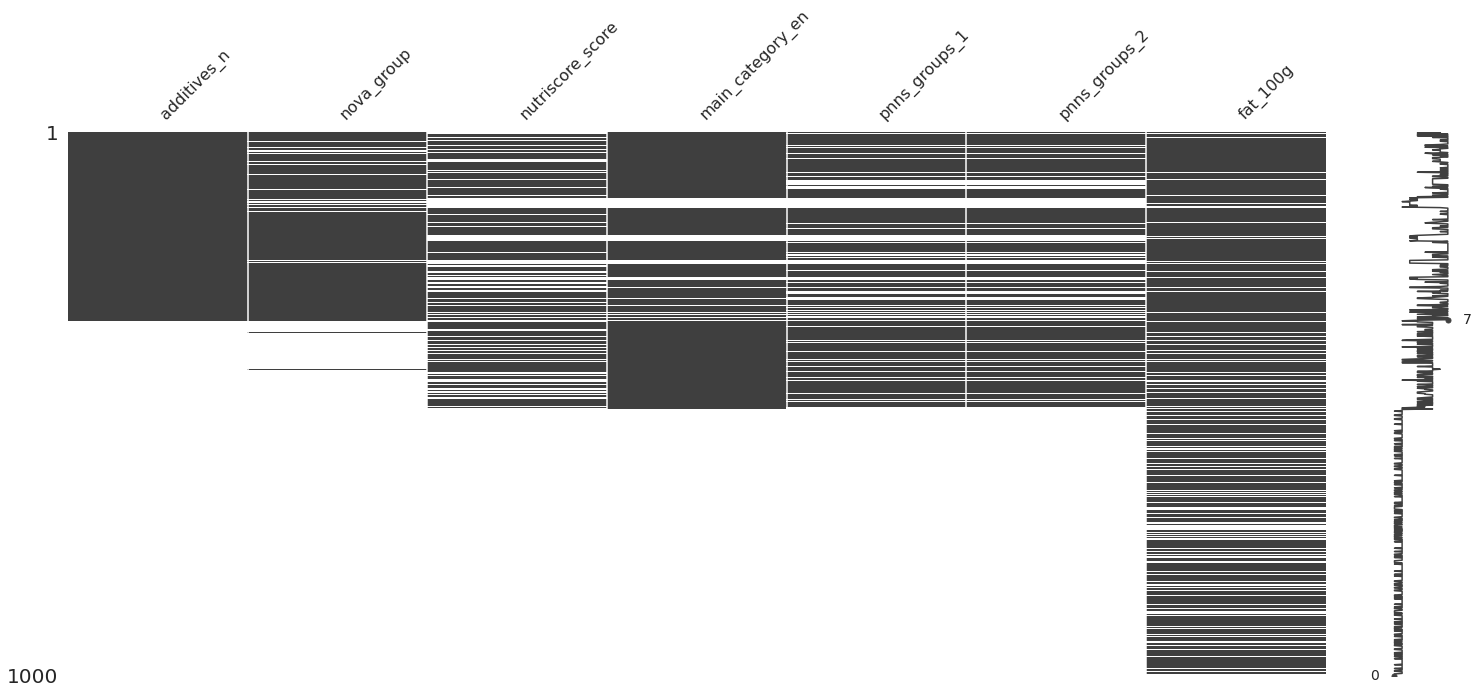

In [70]:
import missingno as msno
def plot_missing_matrix(df, cols=[
    'additives_n','nova_group',
    'nutriscore_score',
    'main_category_en', 'pnns_groups_1', 'pnns_groups_2',
    'fat_100g']):
    msno.matrix(df[cols])

# data_df.pipe(sort_by_points).pipe(plot_missing_matrix)
sample_size=min(1000,len(data_df))
data_df.sample(sample_size).sort_values(by=['additives_n','main_category_en']).pipe(plot_missing_matrix)

#data_df.sample(sample_size).sort_values(by=['additives_n','nova_group','main_category_en','nutriscore_score','fat_100g']).pipe(plot_missing_matrix)
#to_png('3.3.2_etat_remplissage_apres_triage')

#### 3.5.3.3 Élimine les lignes dupliquées après triage par état de remplissage

In [71]:
def drop_lignes_dupliquees(df:pd.DataFrame, subset=['code']):
    nb_avant= df.shape[0]
    """drop duplicates, en indiquant le clé (subset) et le nombre de lignes supprimés"""
    df.drop_duplicates(subset=subset,keep='first',inplace=True)
    nb_apres= df.shape[0]
    print(f'drop_lignes_dupliquées[{subset}], nb. lignes supprimés = {(nb_avant - nb_apres)}')
    return df

data_df=data_df.pipe(drop_lignes_dupliquees,subset=['code'])



drop_lignes_dupliquées[['code']], nb. lignes supprimés = 320


In [72]:
def get_duplicates_index(df,subset):
    return df[df[subset].duplicated(keep=False)]

#data_df=data_df.pipe(drop_lignes_dupliquees,subset=['product_name','brands'])

def get_product_brand_duplicates(df):
    duplicates= get_duplicates_index(data_df, subset=['product_name', 'brands_tags'])
    print(len(duplicates))
    return duplicates[['generic_name','product_name','brands_tags']].head()


get_product_brand_duplicates(data_df)


605541


generic_name            product_name    brands_tags
1987879          NaN                     NaN            NaN
1987877          NaN                Loading…            NaN
446412           NaN  Premium ice cream cake  uncle-harry-s
446424           NaN  Premium ice cream cake            NaN
446426           NaN  Premium ice cream cake            NaN

#### 3.5.3.4 Si on supprime duplicates sur `[product_name, brand]`, tous les produits generiques comme 'poulet', 'spaghetti' seront reduit a une seule produit.


In [73]:
def drop_duplicate_brand_products(df: pd.DataFrame):
    duplicate_brand_products =df[['product_name','brands']].duplicated(keep="first")
    # mantient les produits qui peuvent être défini seulement par code, generic_name, ou ingredients par exemple
    null_brand_products = df[['product_name','brands']].isna().all()
    return df[~duplicate_brand_products | null_brand_products] 
    
def drop_dup_brand_products(df: pd.DataFrame):
    duplicate_brand_products =df.duplicated(subset=['product_name','brands'],keep="first")
    # mantient les produits qui peuvent être défini seulement par code, generic_name, ou ingredients par exemple
    null_brand_products = df['product_name'].isnull() & df['brands'].isnull()
    return df[~duplicate_brand_products | null_brand_products] 

def drop_dup_branded_products(df:pd.DataFrame):
    filtre = (~df.duplicated(['product_name','brands_tags'],keep='first') 
        | ((df['product_name'].isnull()) & (df['brands_tags'].isnull())))
    print(f'drop_dup_branded_products, nb = {filtre.sum()}')
    return df[filtre]

data_df = drop_dup_branded_products(data_df)


drop_dup_branded_products, nb = 1622708


## 3.6 Pipeline pour éliminer lignes dupliquées

In [74]:
def pipeline_eliminer_lignes_dupliquees(df):
    print(f'pipeline_eliminer_lignes_dupliquees, start_time={datetime.now().time():%H:%M:%S}')
    return(df
        .pipe(sort_by_priority)
        .pipe(drop_lignes_dupliquees,subset=['code'])
        .pipe(drop_dup_branded_products)
        .pipe(drop_lignes_dupliquees,subset=['product_name','brands_tags'])
    )

data_df=data_df.pipe(pipeline_eliminer_lignes_dupliquees)

pipeline_eliminer_lignes_dupliquees, start_time=08:42:25
drop_lignes_dupliquées[['code']], nb. lignes supprimés = 0
drop_dup_branded_products, nb = 1622708
drop_lignes_dupliquées[['product_name', 'brands_tags']], nb. lignes supprimés = 56980


# 4. Étude des valeurs manquantes<a name="valeurs-manquants"></a>

Les valeurs manquantes peuvent être imputés si on a assez de données dans la colonne,
et que les valeurs aberrantes ont étés traités. Sinon, la colonne n'est pas utilisable.

Dans cette premiere partie :
   - Suppression de colonnes vides
   - Remplissage des colonnes
   - Valeur 'unknown' est une valeur manquante : le remplace avec la valeur 'null' / NaN
   - Suppression de colonnes trop vides
   - Analyse de la distribution des valeurs manquantes (corrélation entre colonnes)
   - Pipeline pour traiter valeurs manquantes (partie 1)

Après traitement de valeurs aberrantes, on traitera les valeurs manquantes par imputation (partie 2)

## 4.2 Remplissage des colonnes

### 4.2.1 Taux de remplissage des colonnes des 'additifs'

Notre colonne d'intérêt est le nombre d'additifs : Quel est sont taux de remplissage ?

In [75]:
def taux_remplissage(df,col):
    total=len(df)
    cpt=df[col].count()
    print (f'"{col}": {cpt} ({round(100* cpt / total)}%)')
    return df

(data_df
    .pipe(taux_remplissage,'additives_n')
    .pipe(taux_remplissage,'additives_tags'));

"additives_n": 645929 (41%)
"additives_tags": 372664 (24%)


### 4.2.2 Taux de remplissage des autres colonnes

On cherche des colonnes avec un taux de remplissage similaire ou plus que nos colonnes des additifs.
On define le niveau minimum de remplissage à 20%

#### 4.2.2.1 Remplissage comme bars

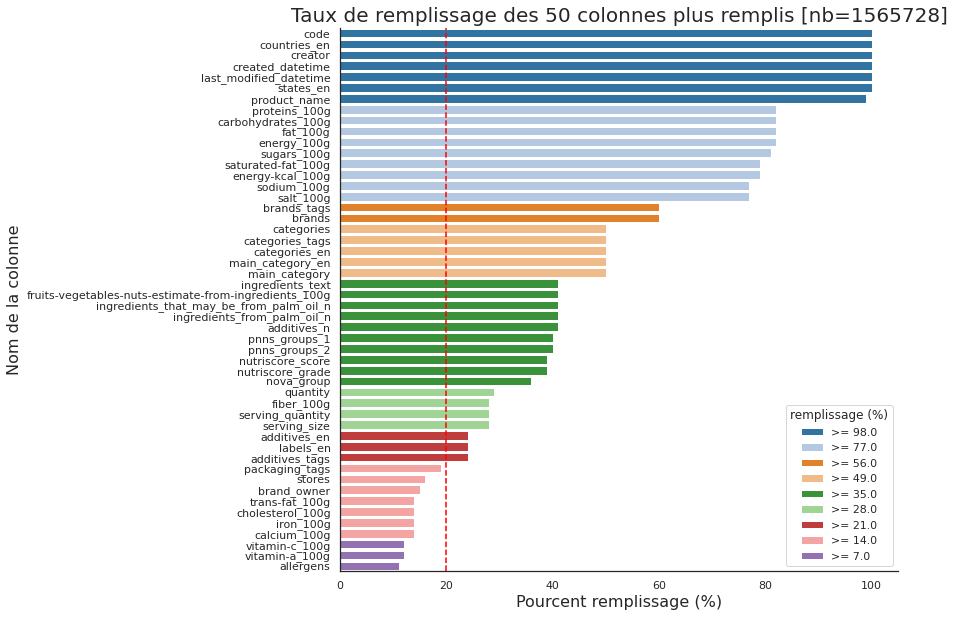

In [76]:
def plot_bar_remplissage(df:pd.DataFrame, nb=50, titre=None, figsize=(10,10)):
    nb = min(nb,df.shape[1])
    ret= round((1-df.isna().mean())*100).sort_values(ascending=False)[:nb]
    plt.figure(figsize=figsize)
    taux = [f'>= {x//7 * 7}' for x in ret.values]
    ax=sns.barplot(y=ret.index, x=ret.values, hue=taux, dodge=False)
    ax.set_xlabel('Pourcent remplissage (%)', size=16)
    ax.set_ylabel('Nom de la colonne', size=16)
    ax.axvline(20, linestyle='--',color='red')
    if titre is None:
        titre = f'Taux de remplissage des {nb} colonnes plus remplis'
    ax.set_title(label=f'{titre} [nb={df.shape[0]}]',size=20)
    plt.legend(title='remplissage (%)')
    sns.despine()

plot_bar_remplissage(data_df)
to_png('4.2.2.1_taux_remplissage_colonnes_bar')
# show_bar_count(data_df)[10:50].plot(kind='bar')
# data_df.notnull()

#### 4.2.2.2 Remplissage comme colonnes

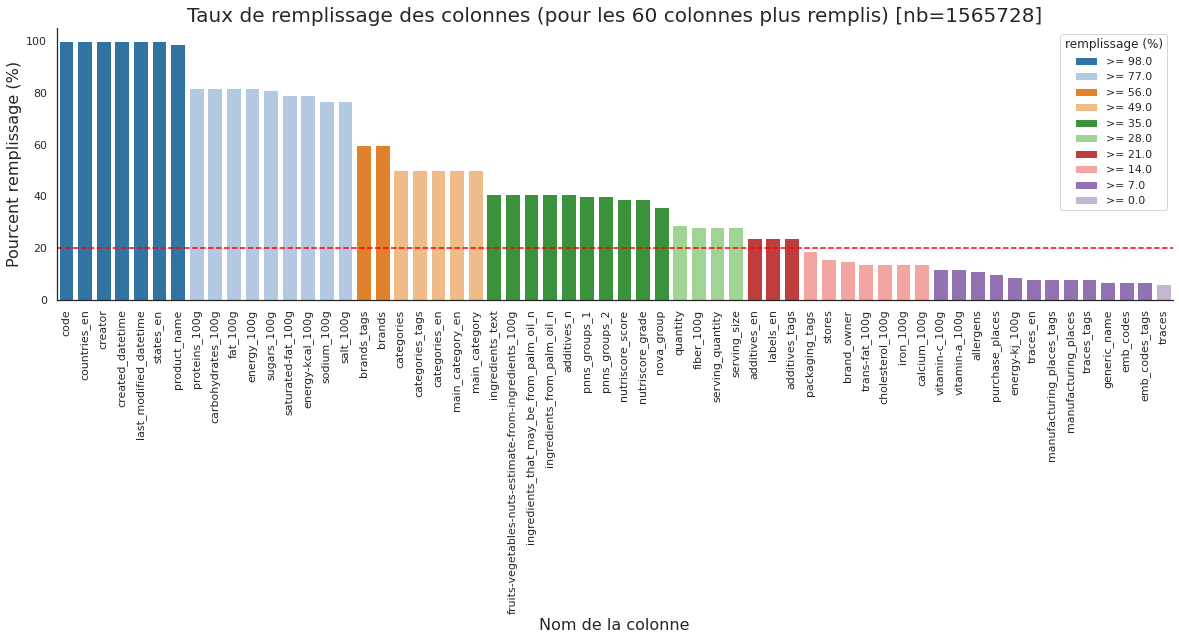

In [77]:
def plot_colonne_remplissage(df:pd.DataFrame, titre='remplissage', figsize=None, head=True, max_colonnes=100):
    """Affiche la remplissage de chaque colonne"""
    remplissage = (round((1-df.isna().mean())*100)
                    .sort_values(ascending=False)
                    .to_frame(name='taux')
                    .rename_axis('colonne').reset_index())
    if head:
        remplissage = remplissage.head(max_colonnes)
    else:
        nb_colonnes = len(remplissage)
        if nb_colonnes > max_colonnes:
            remplissage = remplissage.tail(max_colonnes - nb_colonnes)

    remplissage['hue']= remplissage['taux']//7 * 7
    remplissage['hue'] = '>= ' + remplissage['hue'].astype(str)
    
    _, ax = plt.subplots(figsize=figsize)
    ax=sns.barplot(data=remplissage, ax=ax, x='colonne', y='taux',
         hue='hue', dodge=False )
    ax.set_xlabel('Nom de la colonne', size=16)
    ax.set_ylabel('Pourcent remplissage (%)', size=16)
    plt.xticks(rotation=90)
    ax.axhline(20, linestyle='--',color='red')
    ax.set_title(label=f'{titre} [nb={df.shape[0]}]', size=20)
    plt.legend(title='remplissage (%)')
    sns.despine()

max_cols= min(data_df.shape[1],60)
plot_colonne_remplissage(
    data_df, 
    titre=f'Taux de remplissage des colonnes (pour les {max_cols} colonnes plus remplis)',
    figsize=(20, 5), 
    max_colonnes=max_cols
)
to_png('4.2.2.2_taux_remplissage_colonnes_barplot')

## 4.3 Drop colonnes avec moins de 20% remplissage

In [78]:
keep_columns=['ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 ]

In [79]:
def drop_colonnes_trop_vides(df:pd.DataFrame, threshold=0, keep_cols=[]):
    """supprime les colonnes, sauf des colonnes dans la liste de colonnes à retenir"""
    cols=list(set(df.columns.to_list()) - set(keep_cols))
    freq = 1-df[cols].isnull().mean()
    colonnes_trop_vides = freq[freq <= threshold]
    drop_cols=colonnes_trop_vides.sort_values(ascending=True).index.tolist()
    total = len(df)
    txt=f'drop_colonnes_vides, threshold = {threshold}, drop {len(drop_cols)} colonnes: '
    for col in drop_cols:
        cpt=df[col].count()
        txt += f'"{col}": {cpt} ({round(100* cpt / total)}%); '
    print (txt)   
    return df.drop(colonnes_trop_vides.index, axis=1)

In [80]:
data_df=data_df.pipe(drop_colonnes_trop_vides, threshold=0.05, keep_cols=keep_columns)

drop_colonnes_vides, threshold = 0.05, drop 66 colonnes: "water-hardness_100g": 1 (0%); "nutrition-score-uk_100g": 4 (0%); "glycemic-index_100g": 4 (0%); "chlorophyl_100g": 5 (0%); "ecoscore_score_fr": 38 (0%); "ecoscore_grade_fr": 38 (0%); "beta-glucan_100g": 38 (0%); "carnitine_100g": 43 (0%); "nucleotides_100g": 47 (0%); "casein_100g": 62 (0%); "beta-carotene_100g": 64 (0%); "choline_100g": 71 (0%); "inositol_100g": 73 (0%); "serum-proteins_100g": 76 (0%); "omega-9-fat_100g": 113 (0%); "silica_100g": 140 (0%); "ph_100g": 200 (0%); "chromium_100g": 206 (0%); "taurine_100g": 226 (0%); "collagen-meat-protein-ratio_100g": 306 (0%); "molybdenum_100g": 309 (0%); "fluoride_100g": 372 (0%); "bicarbonate_100g": 380 (0%); "carbon-footprint_100g": 437 (0%); "caffeine_100g": 476 (0%); "starch_100g": 518 (0%); "fruits-vegetables-nuts-dried_100g": 525 (0%); "omega-6-fat_100g": 533 (0%); "chloride_100g": 764 (0%); "energy-from-fat_100g": 889 (0%); "biotin_100g": 1143 (0%); "vitamin-k_100g": 1166 (

In [81]:
data_df=data_df.pipe(drop_colonnes_trop_vides, threshold=0.1, keep_cols=keep_columns)

drop_colonnes_vides, threshold = 0.1, drop 13 colonnes: "origins_tags": 81912 (5%); "origins_en": 81912 (5%); "origins": 82030 (5%); "traces": 98952 (6%); "emb_codes_tags": 104810 (7%); "emb_codes": 104852 (7%); "generic_name": 115222 (7%); "manufacturing_places_tags": 121179 (8%); "manufacturing_places": 121236 (8%); "traces_tags": 121886 (8%); "traces_en": 121886 (8%); "energy-kj_100g": 137483 (9%); "purchase_places": 152831 (10%); 


## 4.4 Pipeline pour traiter les valeurs manquantes

In [82]:
def pipeline_traiter_valeurs_manquantes(df):
    print(f'pipeline_traiter_valeurs_manquantes, start_time={datetime.now().time():%H:%M:%S}')

    # Notre intérêt est des additifs
    keep_columns=cols_in_df(df,['ingredients_from_palm_oil_tags',
                                'ingredients_that_may_be_from_palm_oil_tags'])
    return (df
           #.pipe(drop_unnamed_colonnes)
           .pipe(drop_colonnes_vides)
           .pipe(drop_colonnes_trop_vides, threshold=0.05, keep_cols=keep_columns)
           .pipe(drop_colonnes_trop_vides, threshold=0.10, keep_cols=keep_columns)
           .pipe(drop_colonnes_trop_vides, threshold=0.15, keep_cols=keep_columns)
           .pipe(drop_colonnes_trop_vides, threshold=0.20, keep_cols=keep_columns)
           )

data_df = (data_df
               .pipe(pipeline_traiter_valeurs_manquantes)
               )
print(f'shape : {data_df.shape}')

pipeline_traiter_valeurs_manquantes, start_time=08:43:19
drop  0 colonnes vides: drop []
drop_colonnes_vides, threshold = 0.05, drop 0 colonnes: 
drop_colonnes_vides, threshold = 0.1, drop 0 colonnes: 
drop_colonnes_vides, threshold = 0.15, drop 8 colonnes: "allergens": 170638 (11%); "vitamin-a_100g": 180667 (12%); "vitamin-c_100g": 187044 (12%); "trans-fat_100g": 217207 (14%); "iron_100g": 218032 (14%); "cholesterol_100g": 220387 (14%); "calcium_100g": 223172 (14%); "brand_owner": 233555 (15%); 
drop_colonnes_vides, threshold = 0.2, drop 2 colonnes: "stores": 244143 (16%); "packaging_tags": 290393 (19%); 
shape : (1565728, 42)


In [83]:
print(list(data_df.columns))

['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'quantity', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'labels_en', 'countries_en', 'ingredients_text', 'serving_size', 'serving_quantity', 'additives_n', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'states_en', 'main_category', 'main_category_en', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


## 4.5. Analyse de la distribution des valeurs manquantes
Le graphique de taux remplissage montre des groupes de taux de remplissage

In [84]:
def liste_percent_remplissage(df):
    return ((1 - df.isnull().mean()) * 100).sort_values(ascending=False)

taux=liste_percent_remplissage(data_df)
print(taux)
print(taux.index.to_list())

code                                          100.000000
created_datetime                              100.000000
last_modified_datetime                        100.000000
states_en                                     100.000000
creator                                        99.999808
                                                 ...    
additives_tags                                 23.801324
additives_en                                   23.801324
labels_en                                      23.718743
ingredients_that_may_be_from_palm_oil_tags      2.507396
ingredients_from_palm_oil_tags                  0.879399
Length: 42, dtype: float64
['code', 'created_datetime', 'last_modified_datetime', 'states_en', 'creator', 'countries_en', 'product_name', 'energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'energy-kcal_100g', 'saturated-fat_100g', 'salt_100g', 'sodium_100g', 'brands', 'brands_tags', 'categories', 'main_category_en', 'main_category', 'categor

In [85]:

analyse_cols = data_df.pipe(cols_in_df,[
     'creator','countries_en',
      # colonnes nutritionnels
     'energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'sugars_100g','saturated-fat_100g','sodium_100g',
     'nutriscore_score', 'nutriscore_grade', 'nutrition-score-fr_100g',
      'ingredients_text','ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n',
      'nova_group',
      'main_category_en', 'categories_en',
      'pnns_groups_1', 'pnns_groups_2',
      'ecoscore_grade_fr', 'brands'
      ])

to_analyse=data_df[analyse_cols]

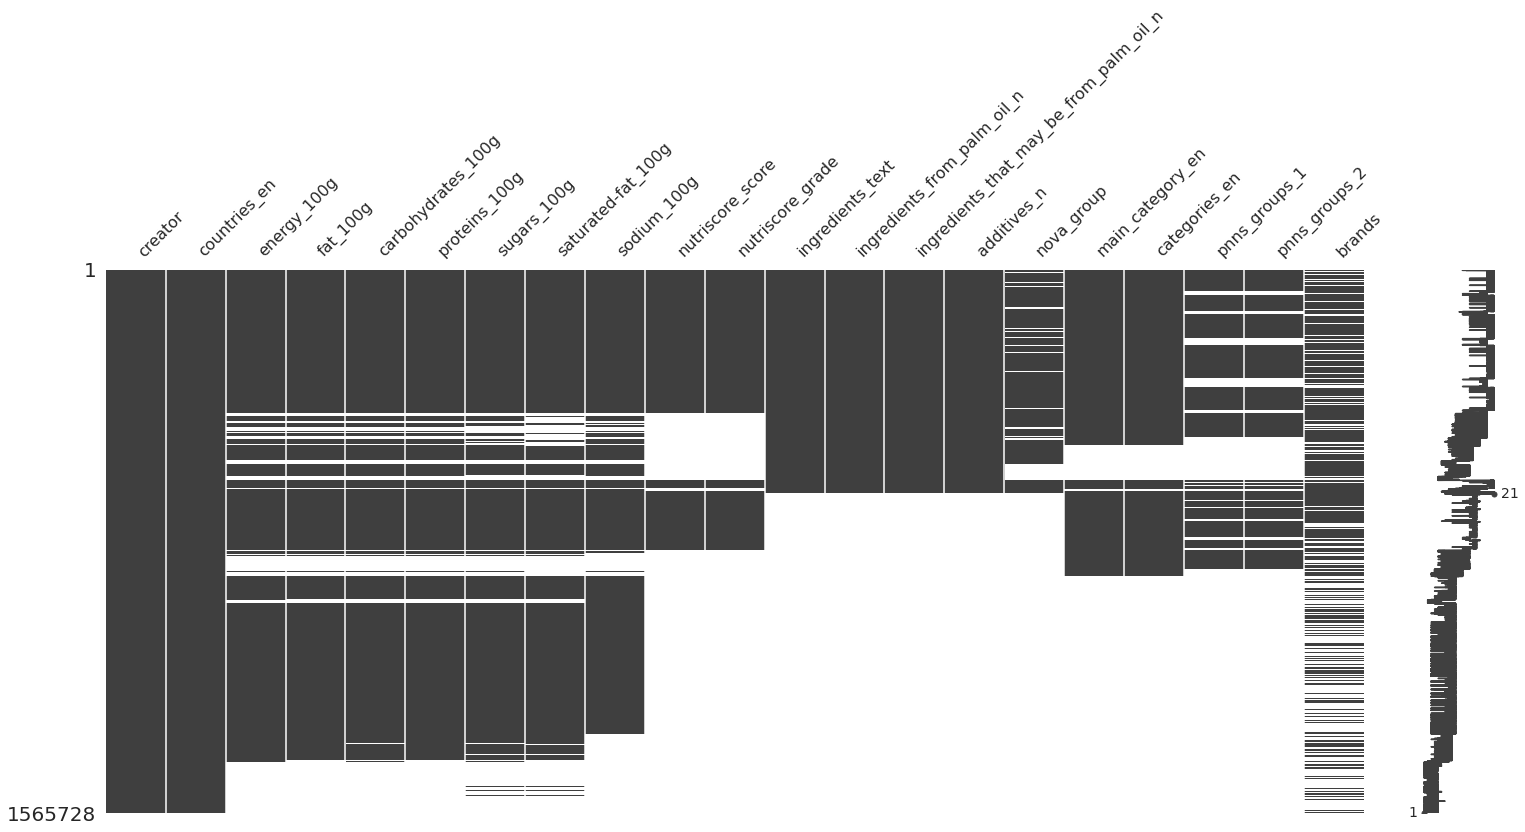

In [86]:
import missingno as msno


to_analyse=to_analyse.sort_values(by=cols_in_df(to_analyse,[
    'ingredients_that_may_be_from_palm_oil_n', # ingredients
    'nutriscore_grade',                        # nutrition
    'pnns_groups_1','main_category_en',        # category
    'nova_group',
'sodium_100g','fat_100g','energy_100g',]))
msno.matrix(to_analyse)
to_png('4.5_distribution_des_valeurs_manquantes')

### 4.5.1 Analyse des données manquantes par contributeur

In [87]:
top_contributeurs = (to_analyse['creator'].value_counts(normalize=True)
    .to_frame(name='freq').head(7))
top_contributeurs

freq
kiliweb                     0.564174
usda-ndb-import             0.099855
openfoodfacts-contributors  0.083389
org-database-usda           0.058103
foodvisor                   0.017409
date-limite-app             0.015728
elcoco                      0.013186

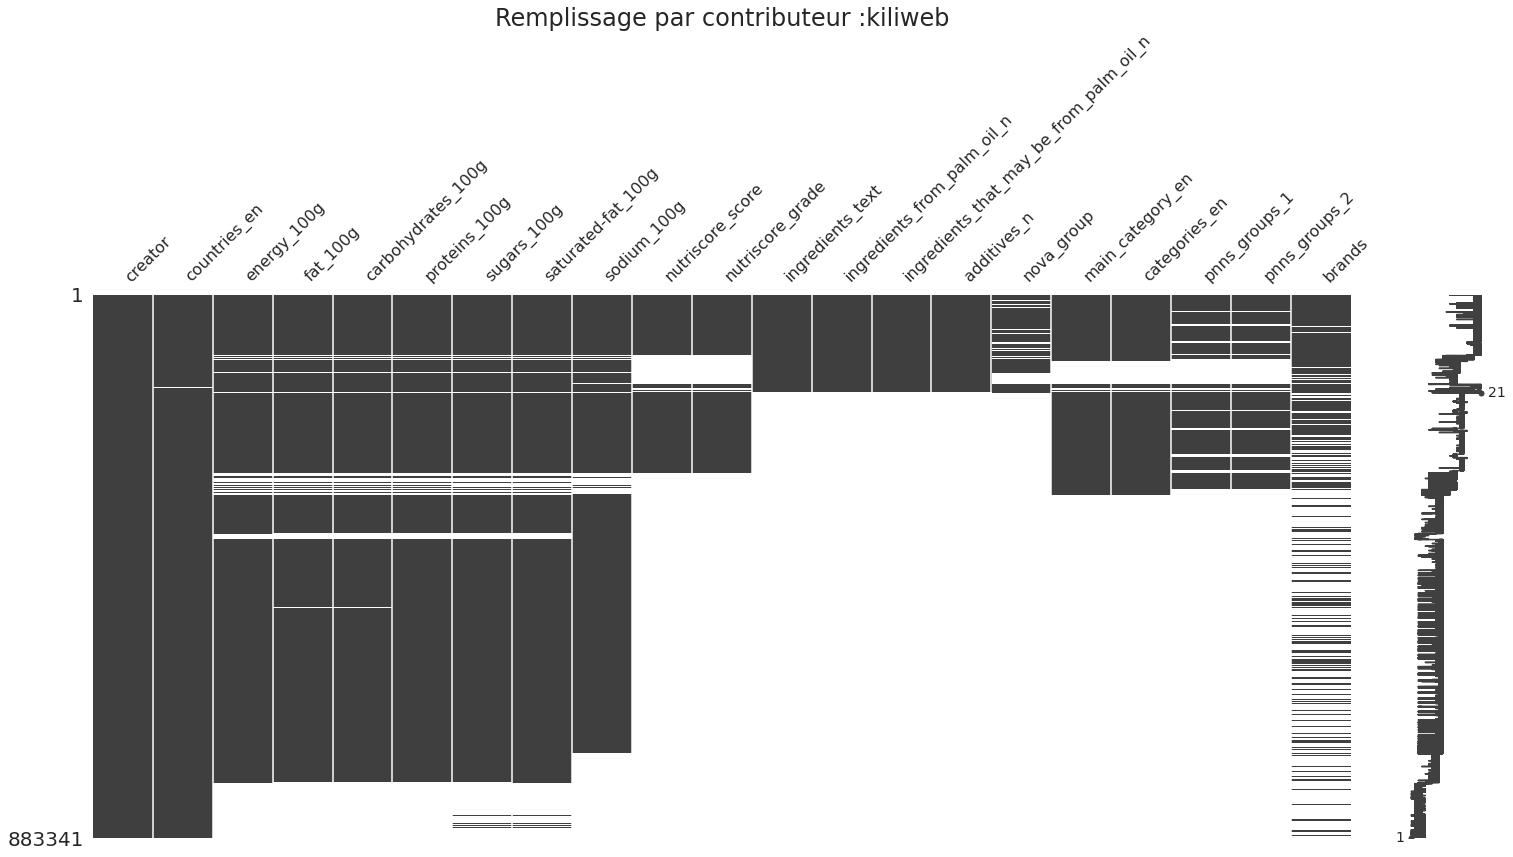

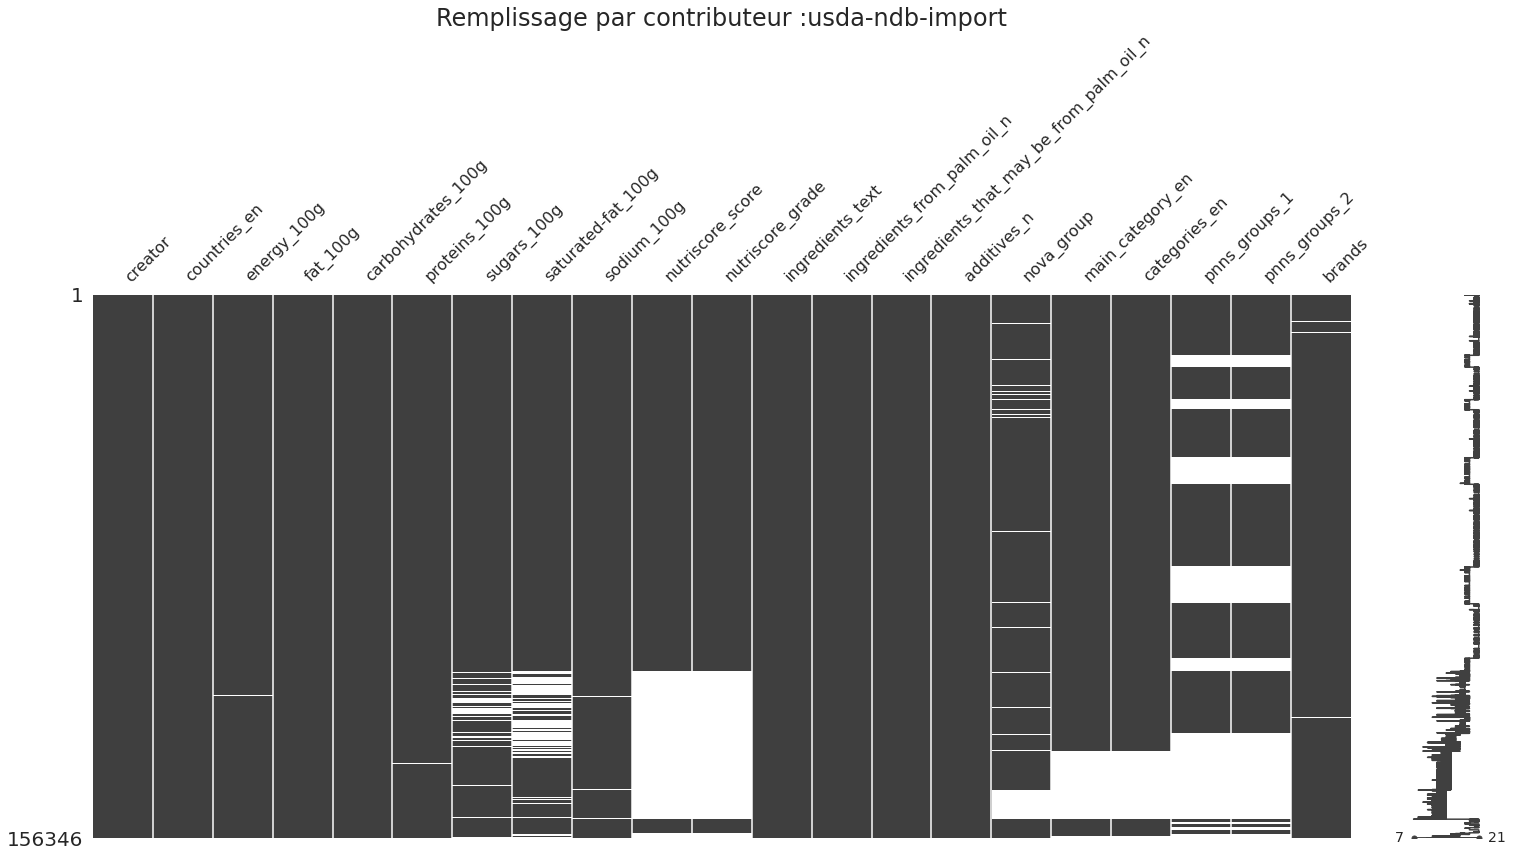

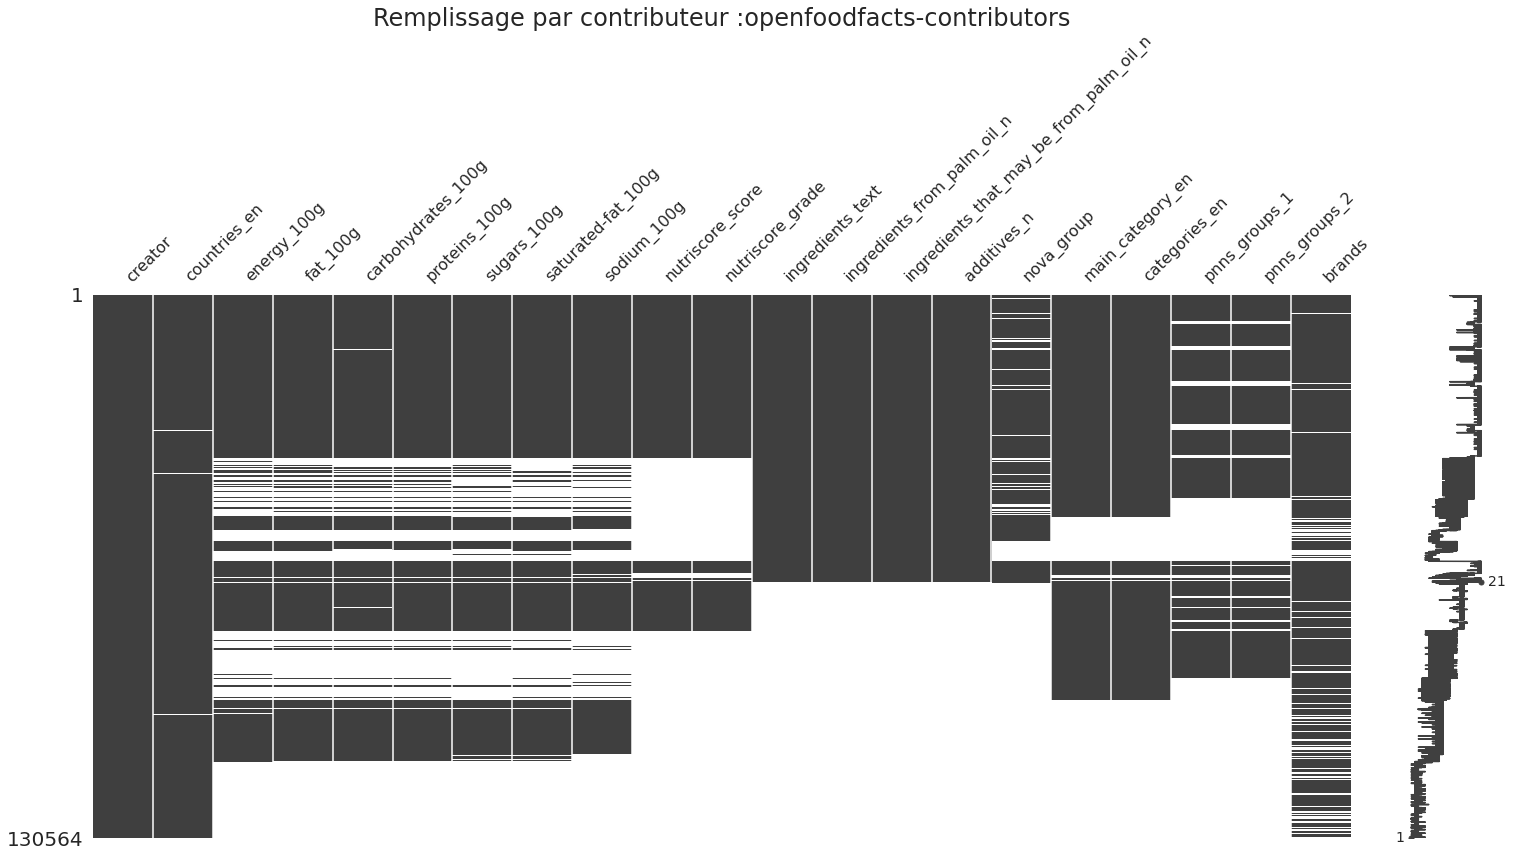

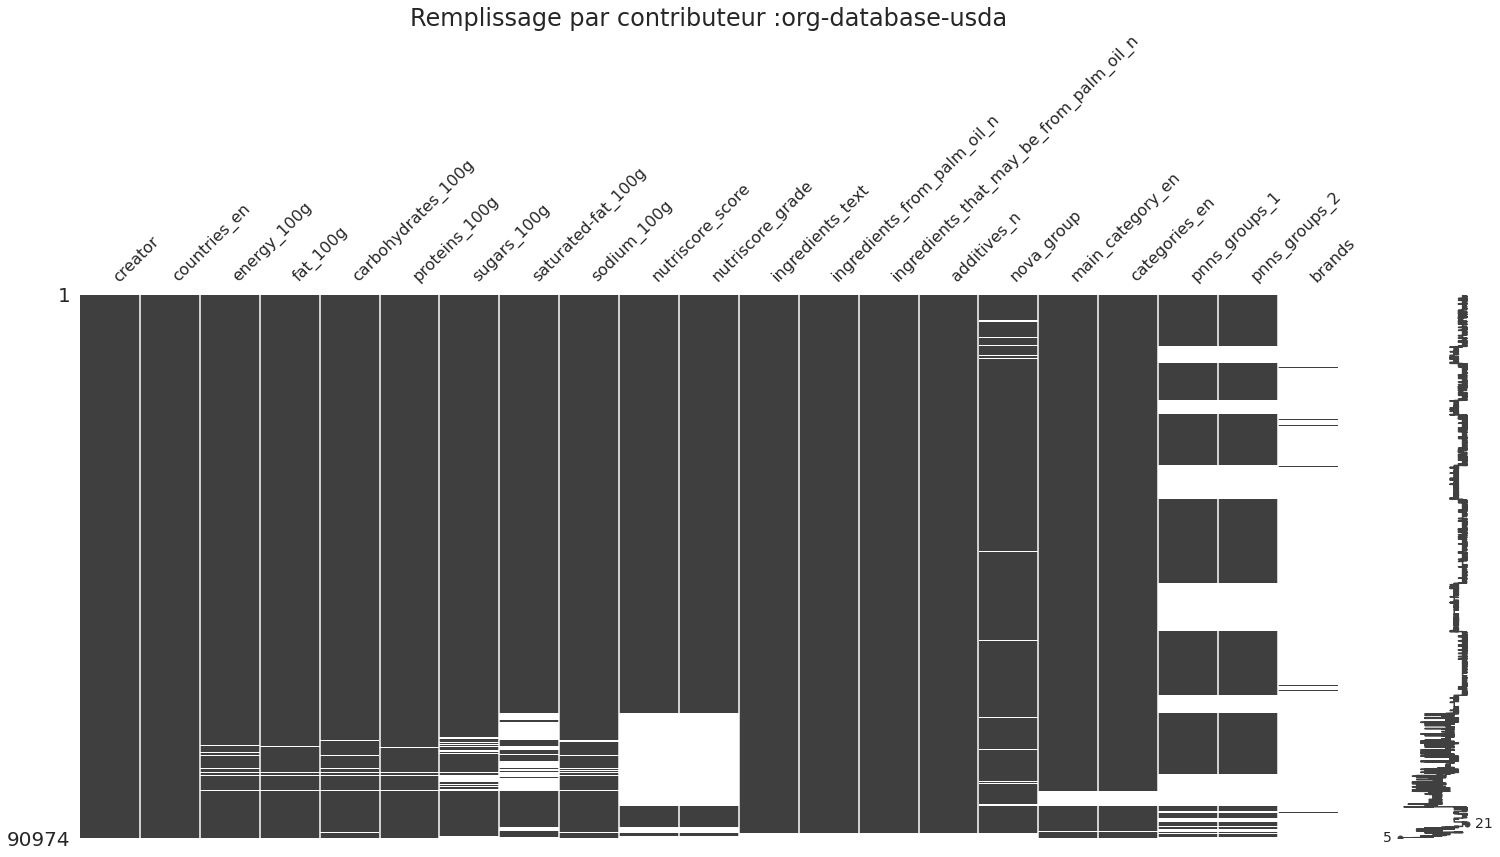

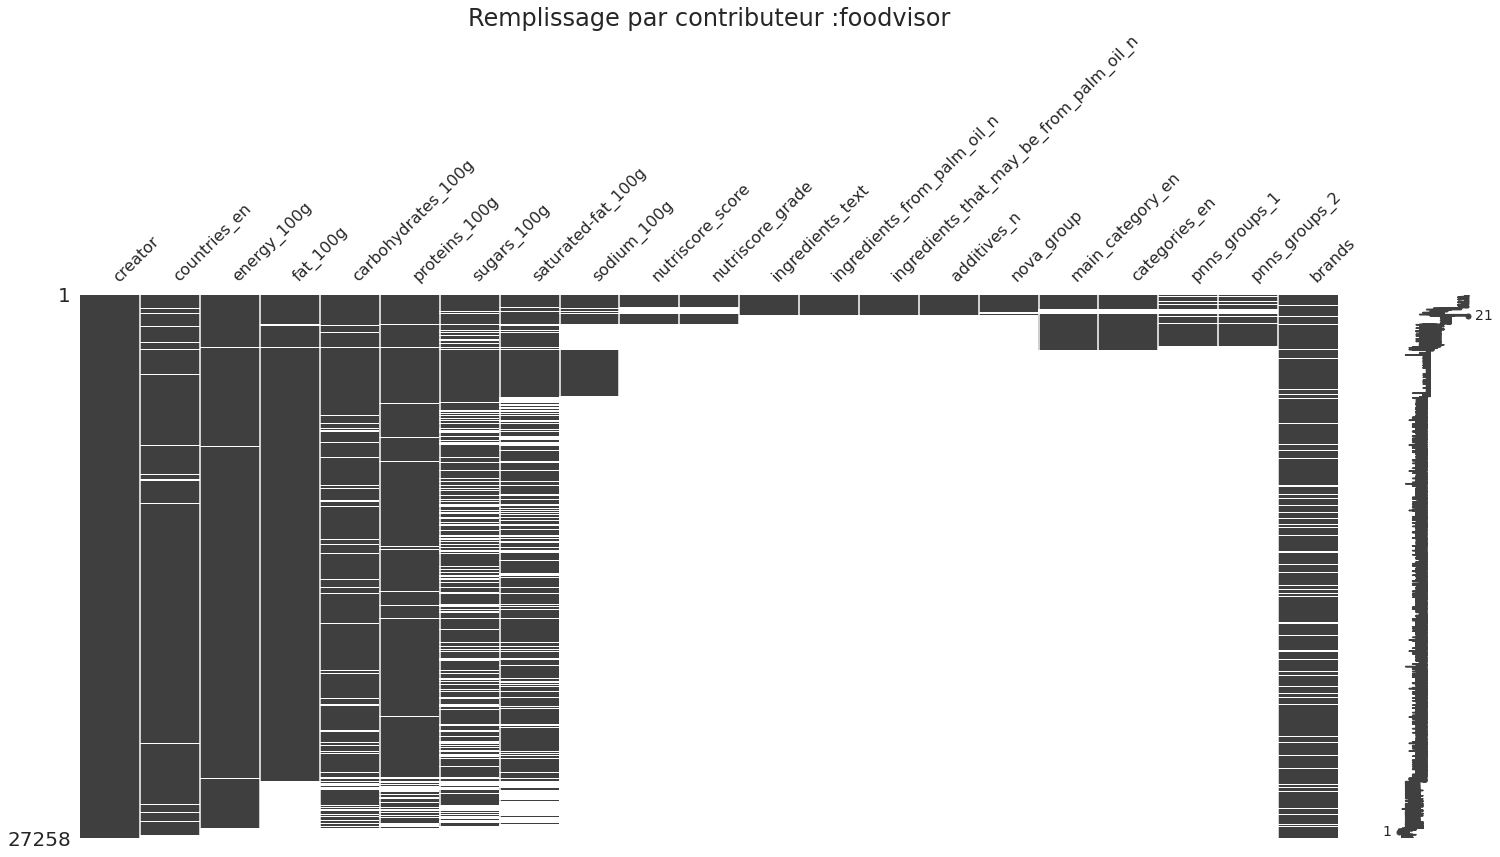

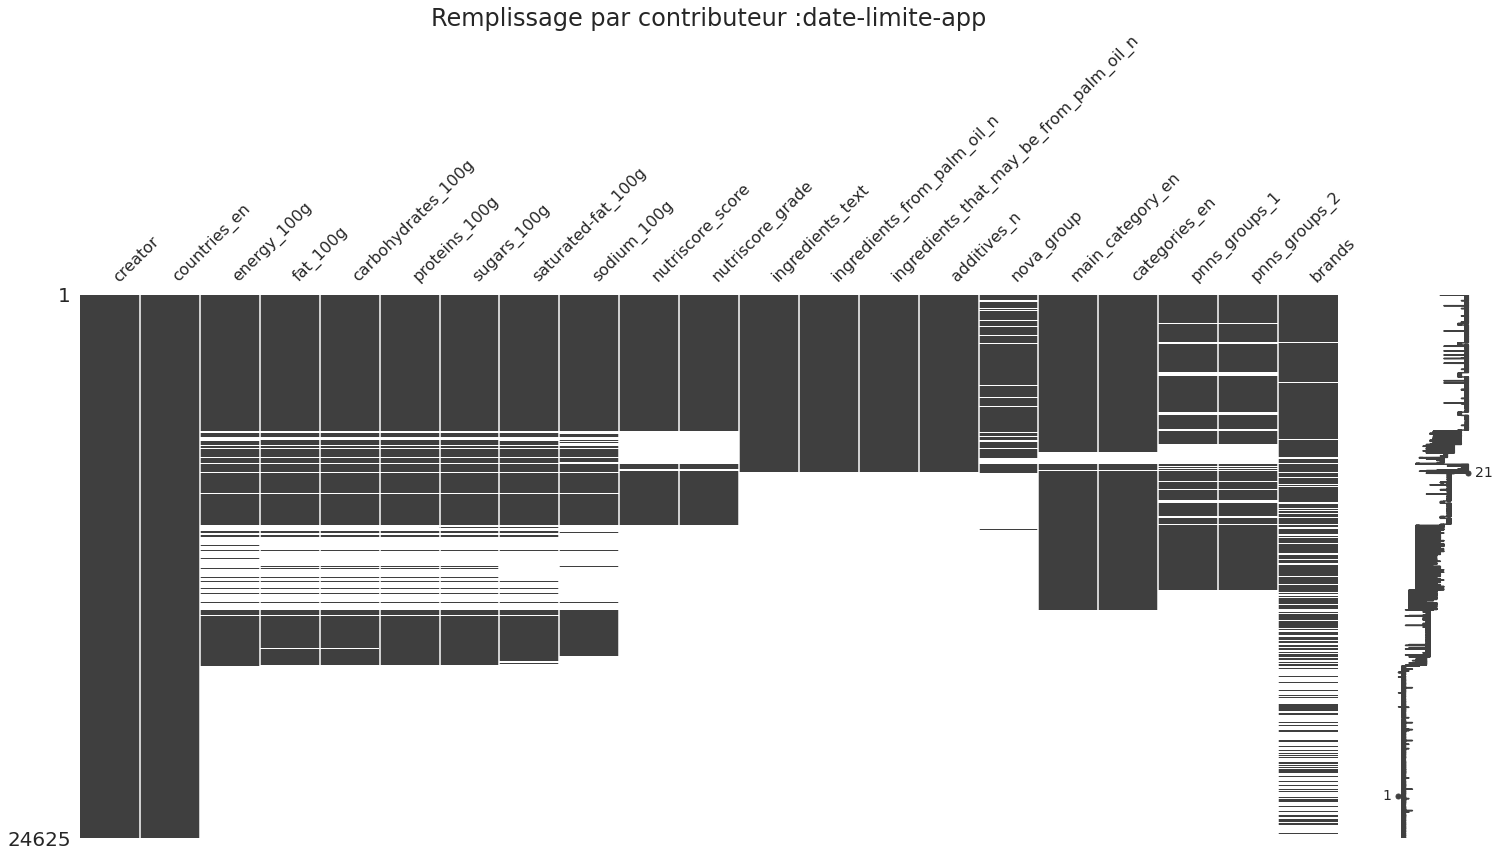

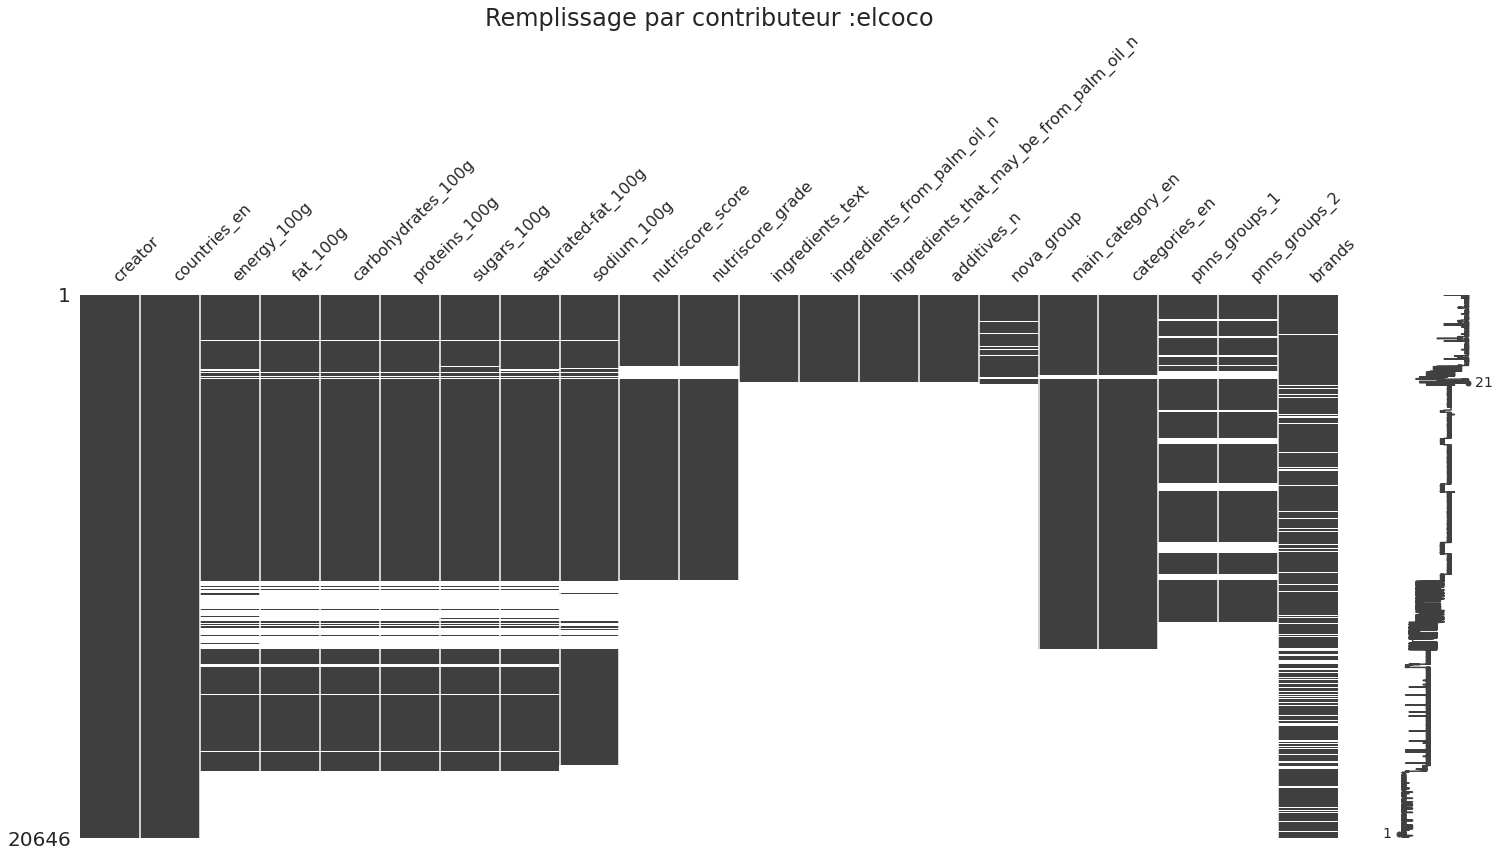

In [88]:
for contributeur in top_contributeurs.index.to_list():
    anal=to_analyse[to_analyse['creator']==contributeur]
    msno.matrix(anal)
    plt.gca().set_title(label=f'Remplissage par contributeur :{contributeur}',size=24)
    to_png(f'4.5.1_remplissage_par_contributeur_{contributeur}')

### 4.5.2 Analyse des données manquantes par pays

#### Unique values from a tags column

```python
import pandas as pd
my_df=pd.DataFrame(['a,b,c','d,e','f'], columns={'some_tags_column'})
my_df['some_tags_column'].str.split(',', expand=True).stack().unique().tolist()
```
Simplifier avec `explode_series(my_df[col]).unique().tolist()`

In [89]:
def explode_series(series:pd.Series) -> pd.Series:
    """convertir ['a,b,c','d,e','f']--> ['a','b','c','d','e','f']  """
    if series.str.contains(',').any():
        return series.str.split(',').explode()
    else:
        return series.explode()

def top_tags(df,col,normalize=True, nb=7):
    return (explode_series(df[col])
            .value_counts(normalize=normalize)
            .to_frame(name='freq').head(nb))

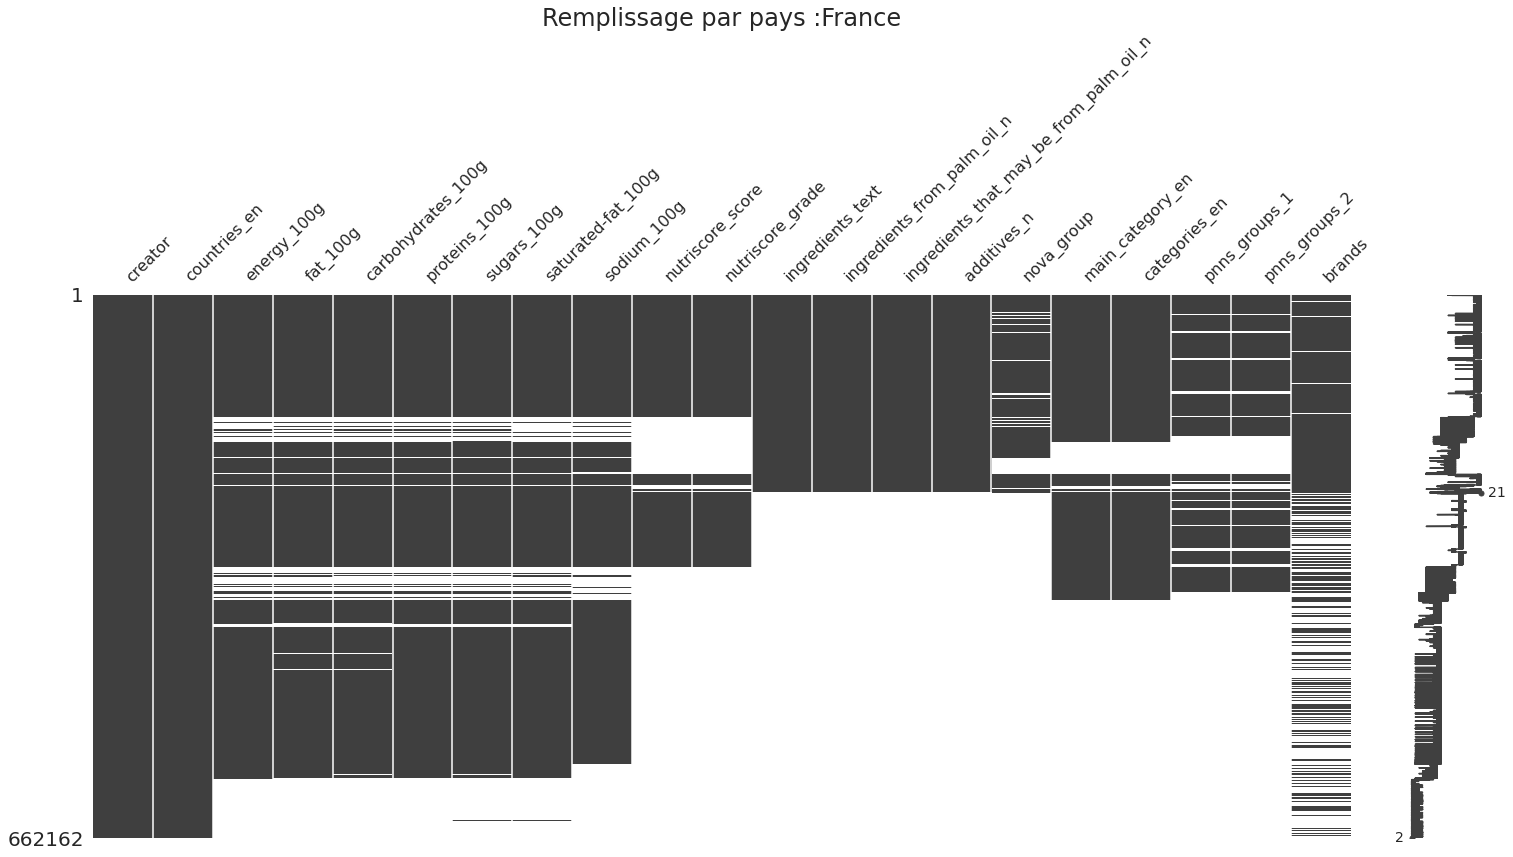

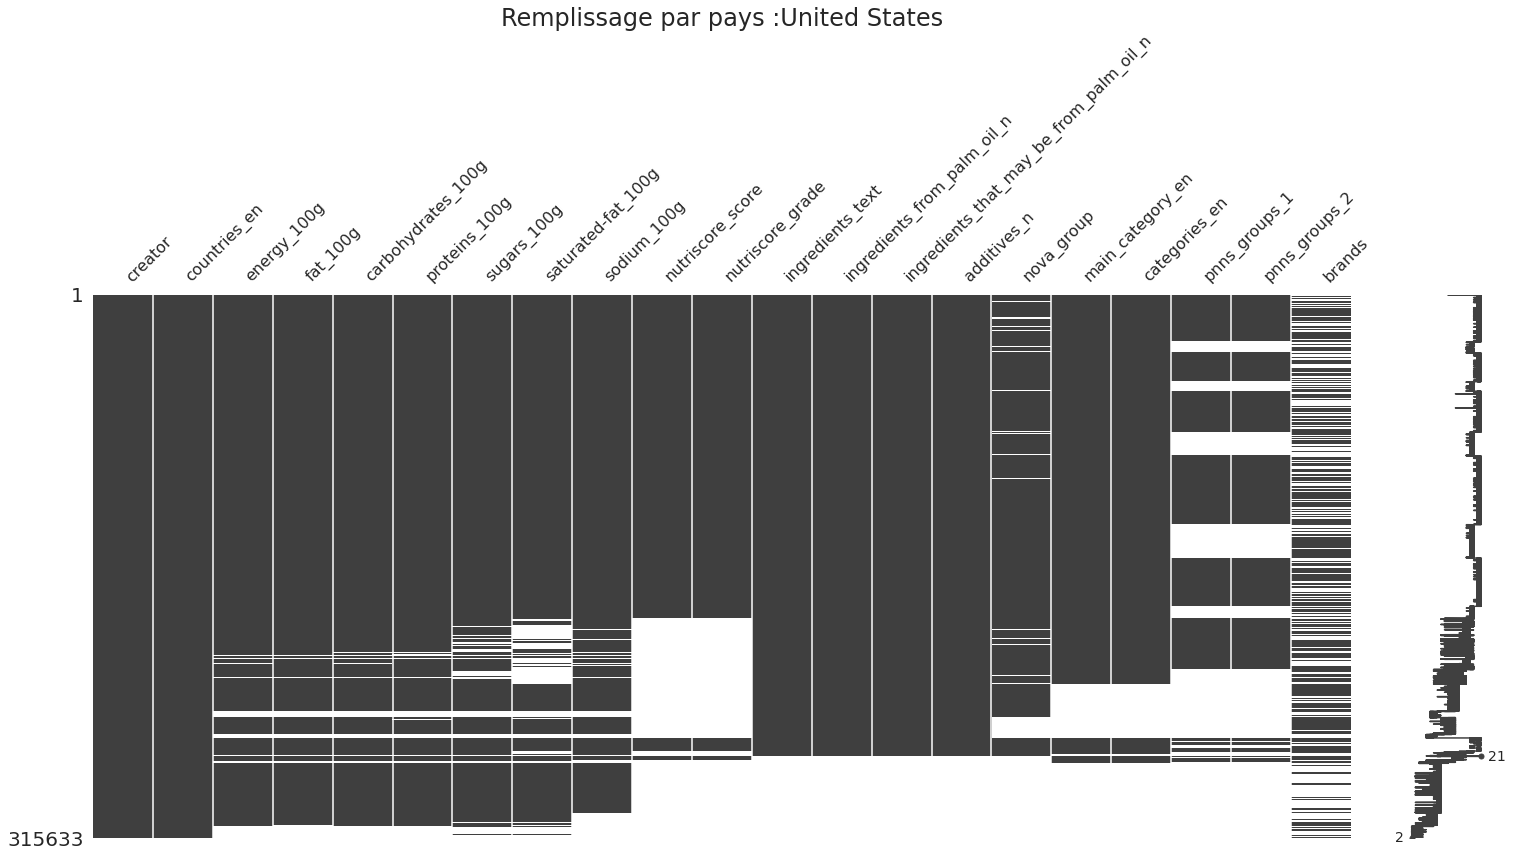

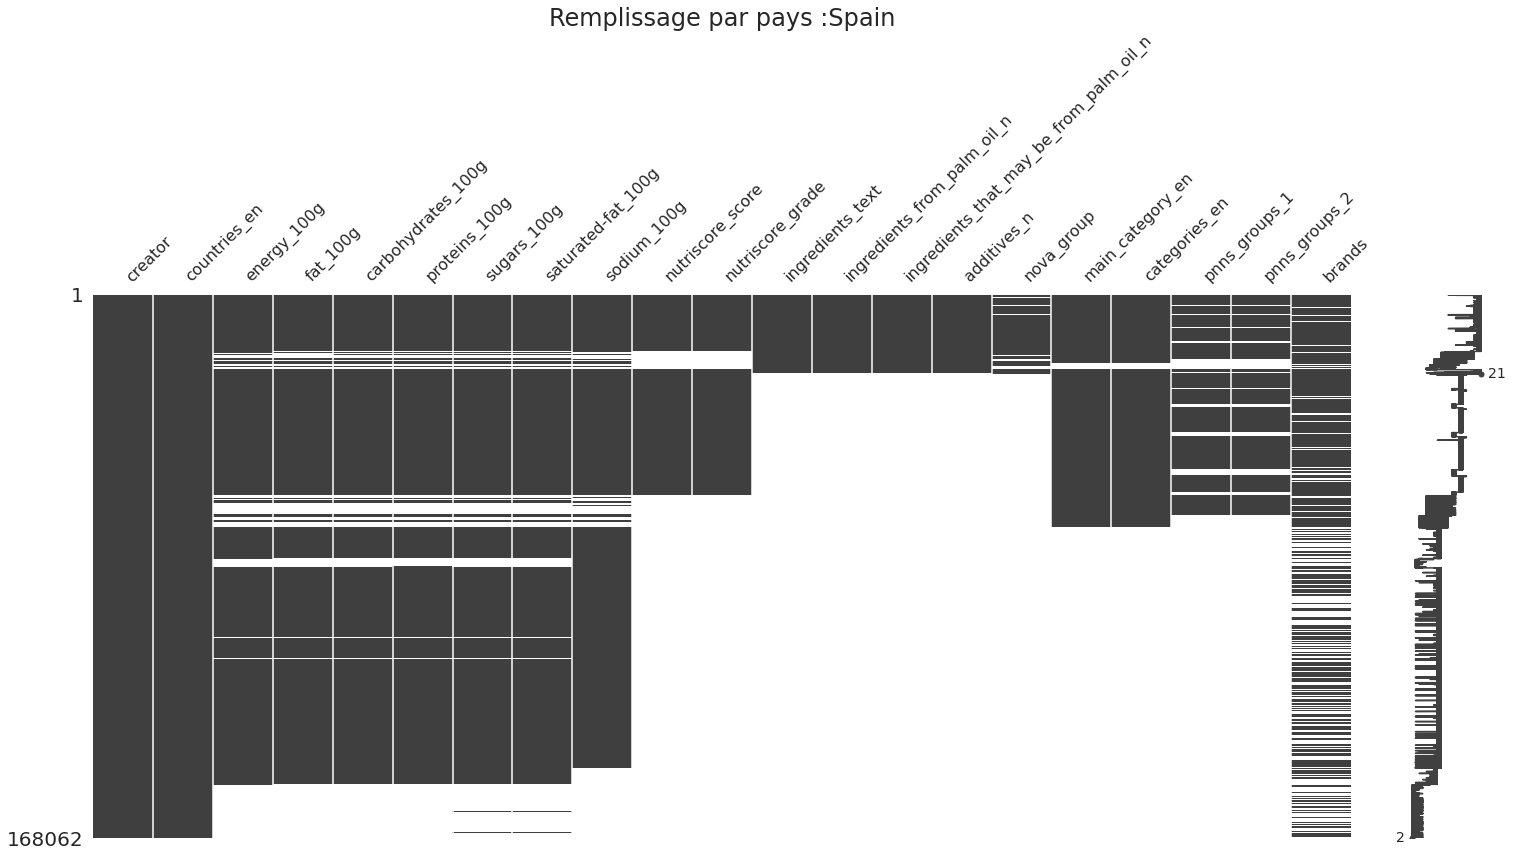

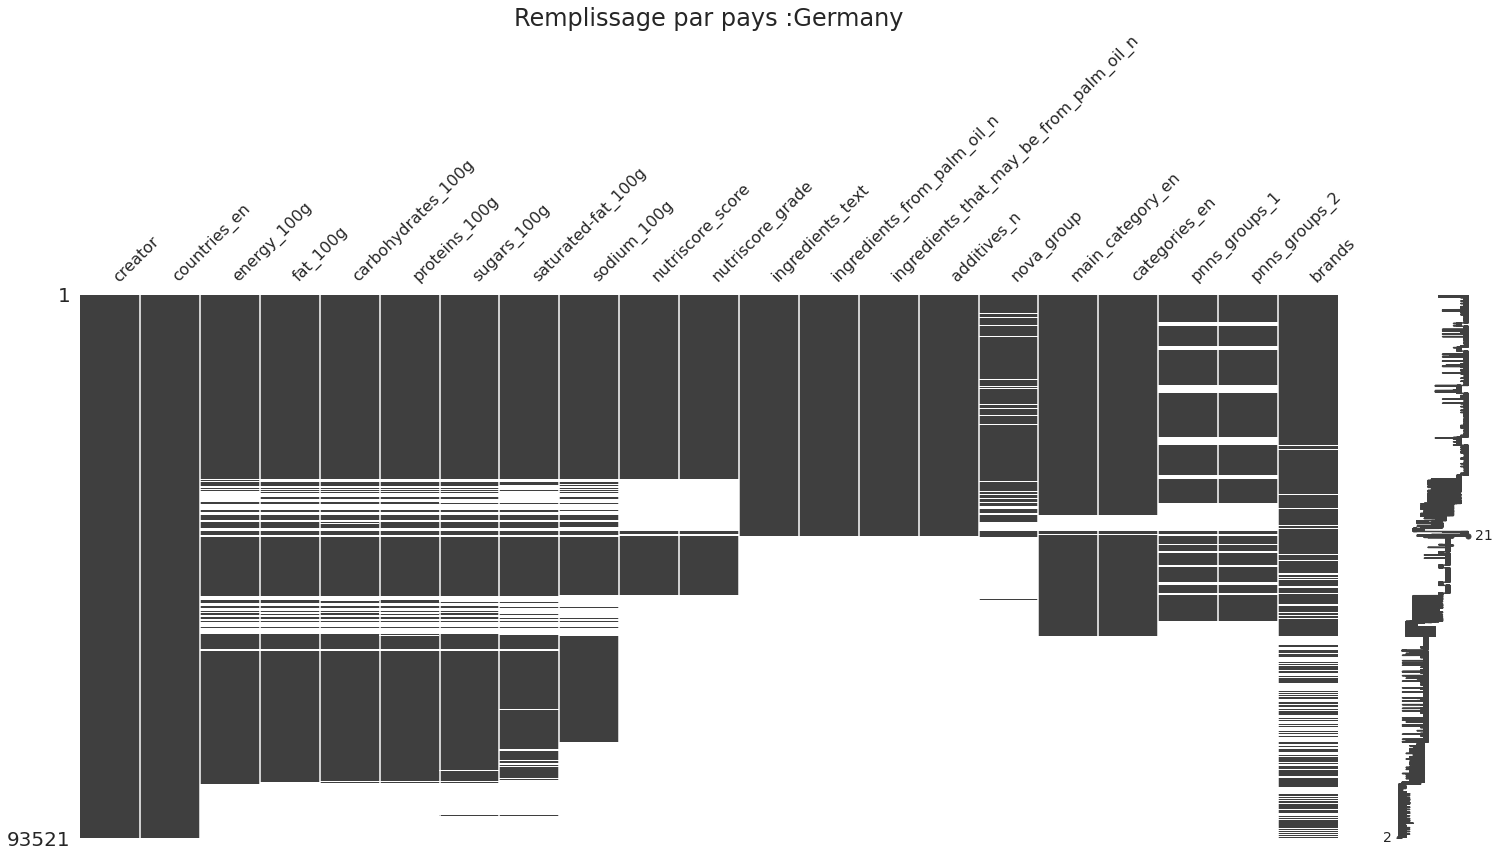

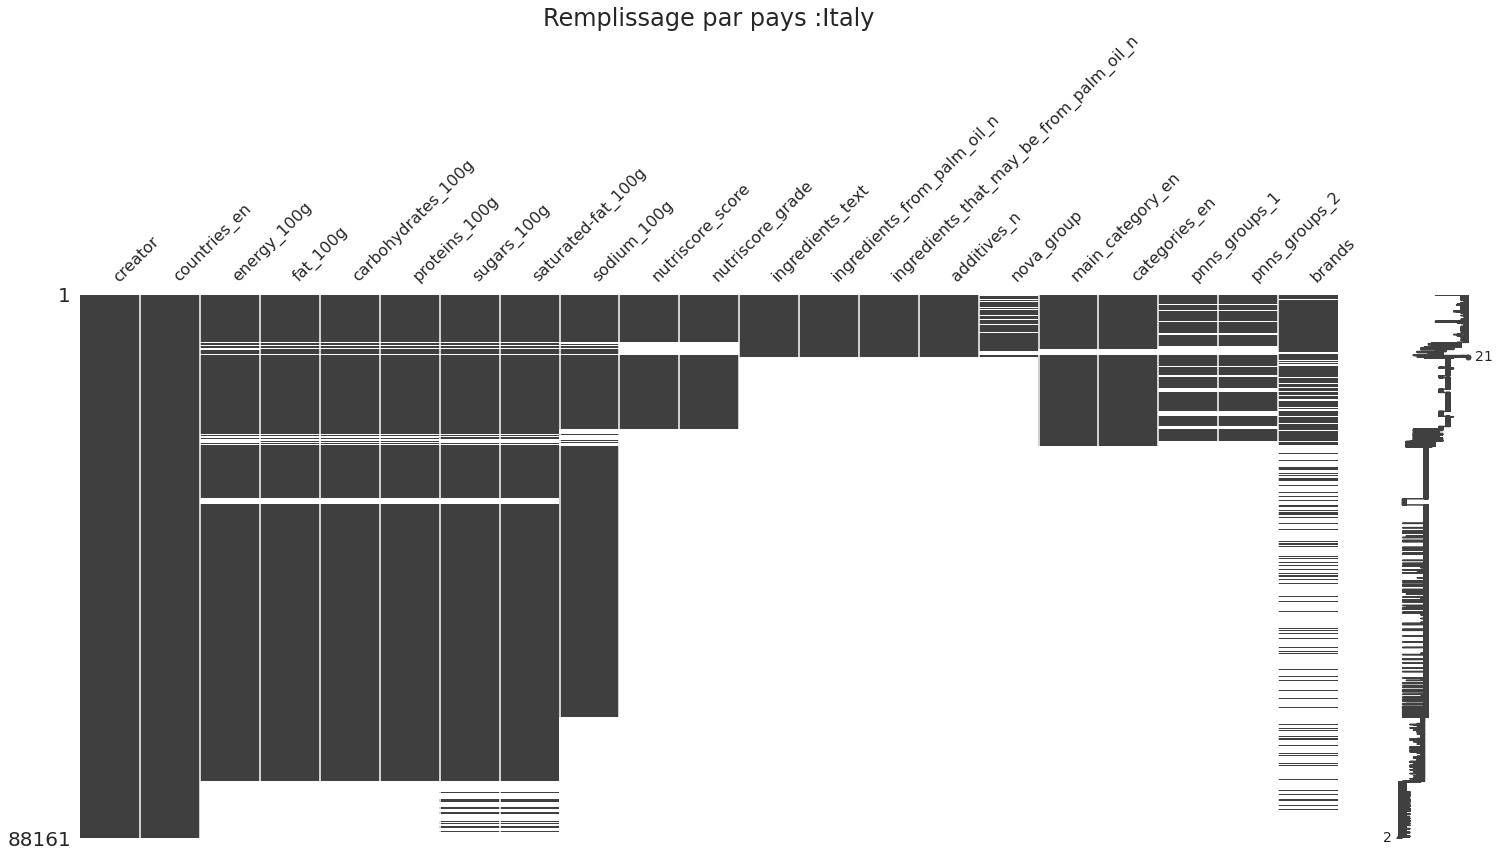

In [90]:
def remplissage_par_pays(df=to_analyse, nb=5):
    df2=df.dropna(subset=['countries_en'])
    top_pays=top_tags(df2,col='countries_en',nb=nb)
    for pays in top_pays.index.to_list():
        anal_pays=df2[df2['countries_en'].str.contains(pays)]
        msno.matrix(anal_pays)
        plt.gca().set_title(label=f'Remplissage par pays :{pays}',size=24)
        to_png(f'4.5.2_remplissage_par_pays_{pays}')

remplissage_par_pays(to_analyse, nb=5)

Intéressant, la distribution de remplissage des champs varie beaucoup entre les pays
Additives(ingredients) 
- presque complet pour produits d'Etats Unis
- bien remplis pour Allemagne
- mal remplis pour la France
- presque pas remplis pour les produits d'Espagne et d'Italie

In [91]:
to_analyse=None

### Conclusion de l'analyse de données manquantes

Les données fournies par chaque contributeur sont groupées :
- les ingredients (qui inclut les additifs)
- les valeurs nutritionnelles
- les categories / groupes PNNS
- le 'nova' group
- le nutriscore
- l'ecoscore
- les brands

Notre intérêt est comment éviter les mauvais additifs
1. un nouvel indicateur de niveau d'additifs méritant attention
2. voir si on peut éviter les additifs en choisissant le meilleur nutriscore
3. voir si on peut éviter les additifs en évitant certain brands
4. voir si on peut éviter les additifs en évitant certain categories/ groupes PNNS

Ces critères seront utilisés pour développer un système de recommendation

# 5. Nettoyage des valeurs aberrantes<a name="valeurs-aberrants"></a>

On inspire sur les contrôles de qualité de données d'Openfoodfacts
- <https://github.com/openfoodfacts/openfoodfacts-server/blob/main/taxonomies/data_quality.result.txt>

Les valeurs aberrantes considérées sont :
- produits qui ne sont pas de nourriture / sans nom : les élimine
- valeurs nutritionnelles < 0
- valeurs nutritionnelles > 100 g per serving de 100 g
- la somme des valeurs nutritionnelles pour 100 g > 100 g.
- sucres + amidon > glucides
- énergie pour 100 g > 3800 kJ, ce qui n'est pas possible.
- énergie kcal > (énergie en kJ / 4.184)
- whitespace (colonne 'product_name' par exemple)

## 5.1 Produits qui ne sont pas de nourriture / sans nom

### 5.1.1 Supprimer les produits sans nom

In [92]:
print(data_df['product_name'].isnull().sum())
data_df= data_df.dropna(subset=['product_name'])


9324


### 5.1.2 Trouver produits aberrantes

In [93]:
NONE_FOOD_WORD_LIST: list = ('non food,dog food,bird food,cat food,pour chien,pour chat,'
                             + 'shampoo,savon,dentifrice,toothpaste,transpirant,nivea,garnier,beauty,visage,'
                             + 'detergent,vaisselle,wash,cleaner,softener,adoucissant,lessive,éponge,'
                             + 'clothes,books,kitchenware,medicine,poubelle').split(',')

# categories à exclure de la recherche
FOOD_CATEGORIES: list = ['cheeses']  # exemple: 'washed-rind cheeses'


def liste_non_foods(df: pd.DataFrame, col='product_name', non_foods=NONE_FOOD_WORD_LIST, 
            food_categories=FOOD_CATEGORIES, nb=20):
    """Trouver les produits qui ne sont pas des aliments"""
    if not col in df.columns:
         """retourné dataframe vide"""
         return pd.DataFrame([],columns=df.columns) 
    non_foods = '|'.join(non_foods)
    food_categories = '|'.join(food_categories)
    # tagged 'Non food product'
    filtre_tagged_non_food = df['categories_en'].fillna(
        '').str.contains('non food', case=False, regex=True)
    # chercher d'autres produits qui ne sont pas alimentation
    filtre_non_foods = df[col].fillna('').str.contains(
        non_foods, case=False, regex=True)
    # eviter d'inclure les food categories qui contient les mots des non foods
    filtre_foods = df['categories_en'].fillna('').str.contains(
        food_categories, case=False, regex=True)
    filtre = filtre_tagged_non_food | (~filtre_foods & filtre_non_foods)
    print(f'liste_non_foods [{col}] (nb={filtre.sum()})')
    non_food_df = df[filtre]

    filtre_washington=non_food_df['product_name'].fillna('').str.contains('washington',case=False)
    non_food_df=non_food_df[~filtre_washington]
    # print(f'{non_food_df[col].unique()[:nb].tolist()}')
    return non_food_df

def trouve_non_food(df):
    """liste les non_food trouver par mot clé dans plusieurs colonnes. 
       On utilise index.name du dataframe pour identifier le dataframe 
       retourné par liste_non_foods: Il ne doit pas avoir le nom d'un des colonnes"""
    non_food_categ = data_df.pipe(
        liste_non_foods, col='categories_en').rename_axis('categ')
    non_food_main_categ = data_df.pipe(
        liste_non_foods, col='main_category_en').rename_axis('main_categ')
    non_food_brands = data_df.pipe(
        liste_non_foods, col='brands_tags').rename_axis('brand')
    non_food_products = data_df.pipe(
        liste_non_foods, col='product_name').rename_axis('product')

    def not_in_dataframe(df1: pd.DataFrame, df2: pd.DataFrame, nb=10):
        """trouve les (non-food) produits dans df1 qui ne sont pas dans df2"""
        ret = df1[~df1.index.isin(df2.index)]
        print(
            f'produits dans {df1.index.name} pas dans {df2.index.name}: {len(ret)}')
        # print(ret['product_name'].value_counts().index[:nb].tolist())
        return ret

    # Produits trouvés par filtre sur 'main_category' mais pas par 'product_name'
    for df1 in [non_food_categ, non_food_main_categ, non_food_brands, non_food_products]:
        for df2 in [non_food_categ, non_food_main_categ, non_food_brands, non_food_products]:
            if df1.index.name != df2.index.name:
                not_in_dataframe(df1, df2)
    return non_food_products

non_food_products = data_df.pipe(trouve_non_food)

liste_non_foods [categories_en] (nb=2010)
liste_non_foods [main_category_en] (nb=2009)
liste_non_foods [brands_tags] (nb=2137)
liste_non_foods [product_name] (nb=3268)
produits dans categ pas dans main_categ: 1
produits dans categ pas dans brand: 86
produits dans categ pas dans product: 59
produits dans main_categ pas dans categ: 0
produits dans main_categ pas dans brand: 85
produits dans main_categ pas dans product: 58
produits dans brand pas dans categ: 213
produits dans brand pas dans main_categ: 213
produits dans brand pas dans product: 175
produits dans product pas dans categ: 1297
produits dans product pas dans main_categ: 1297
produits dans product pas dans brand: 1286


In [94]:
pd.set_option('display.max_rows', 30) 
explode_series(non_food_products['main_category_en']).value_counts().to_frame()[:10]

main_category_en
Open Beauty Facts                 624
Non food products                 512
Tests                             112
Toothpaste                        110
Cat food                           80
Medicine                           72
Dog food                           55
Open Products Facts                53
Pet food                           43
Dry cat food                       25

In [95]:
nb=len(non_food_products)
non_food_products[['product_name','brands','categories_en', 'main_category_en']].sample(min(nb,10))

product_name  \
product                                                               
882937                                                  UDV for men   
1586595                                             Collagen beauty   
1660973                                         gel hydroalcoolique   
1781686                    Flex con keratina acondicionador clásico   
990539                              Disc Duo Démaquillant carrefour   
1917558                                  Sensitive pasta de dientes   
1171540                                 desodorante nivea naturally   
1209612  Select Gold Mini Senior Sensitive mit Ente & Kartoffel 4kg   
1949997                                              Dove Body Wash   
983075                  Terrines Pour Chien, Dinde, Lapin Et Agneau   

                  brands  \
product                    
882937   Ulric de Varens   
1586595         Sqin Tea   
1660973         Primagel   
1781686           Revlon   
990539               NaN   
1917558         Deliplus   
1171540            nivea   
1209612      Select Gold   
1949997             Dove   
983075               NaN   

                                                                             categories_en  \
product                                                                                      
882937                                                 Non food products,Open Beauty Facts   
1586595                                                                                NaN   
1660973                         Non food products,Open Beauty Facts,fr:gel-hydroalcoolique   
1781686                                                Non food products,Open Beauty Facts   
990539                                                                   Non food products   
1917558                                                Non food products,Open Beauty Facts   
1171540                                                                                NaN   
1209612  Non food products,Open Pet Food Facts,Pet food,Dry pet food,Dog food,Dry Dog Food   
1949997                                                                                NaN   
983075                                                                                 NaN   

               main_category_en  
product                          
882937        Open Beauty Facts  
1586595                     NaN  
1660973  fr:gel-hydroalcoolique  
1781686       Open Beauty Facts  
990539        Non food products  
1917558       Open Beauty Facts  
1171540                     NaN  
1209612            Dry Dog Food  
1949997                     NaN  
983075                      NaN

In [96]:
def list_additif_counts(df):
  return (df['additives_en'].dropna().str.split(',')
  .explode().value_counts().head(20))

list_additif_counts(non_food_products)

E422 - Glycerol                                             207
E330 - Citric acid                                          175
E211 - Sodium benzoate                                      129
E415 - Xanthan gum                                           86
E1519 - Benzyl alcohol                                       67
E420 - Sorbitol                                              64
E202 - Potassium sorbate                                     63
E1520 - Propylene Glycol                                     56
E466 - Sodium carboxy methyl cellulose                       52
E487 - Sodium dodecyl sulfate                                50
E133 - Brilliant blue FCF                                    39
E900 - Dimethylpolysiloxane and Methylphenylpolysiloxane     38
E900a - Dimethyl polysiloxane                                37
E943a - Butane                                               30
E171 - Titanium dioxide                                      30
E570 - Fatty acids                      

In [97]:
def list_maybe_food(df):
    maybe_food=df[df['additives_en'].fillna('').str.contains('Citric acid')]
    print(maybe_food['product_name'].unique()[:10])

list_maybe_food(non_food_products)


['soin protection intense' 'Aloe vera puro 100% retinol'
 'Q10 crema de día antiarrugas'
 'Lunar Peppermint Stain Removal Whitening Toothpaste'
 'Garnier Olia Coloration Permanente Midnight Noir Saphir'
 'candès lait clarifiant sublime corps'
 "Dentifrice Extra Fraîcheur Mode d'action naturel antibactérien"
 'huile de coco lait hydratant corps'
 'Jelly beans, stink bug, toasted marshmallow, dirty dishwater, birthday cake, rotten egg, buttered popcorn, toothpaste, berry blue, barf, peach, canned dog food, chocolate pudding, booger, juicy pear, spoiled milk, coconut, stinky socks, tutti-fruitti, dea'
 'body wash']


In [98]:
del non_food_products

### 5.1.3 Supprimer les produits aberrants

In [99]:
def drop_non_foods(df, col='product_name',non_foods=NONE_FOOD_WORD_LIST,food_categories=FOOD_CATEGORIES,showlist=False):
    non_foods_df=liste_non_foods(df,col,non_foods=non_foods,food_categories=food_categories )
    print(f'drop_non_foods [{col}], nb={len(non_foods_df)}')
    if showlist:
        print(f'{non_foods_df[col].unique().tolist()[:20]}')
    return df.drop(non_foods_df.index)

data_df=data_df.pipe(drop_non_foods,col='product_name',showlist=True);



liste_non_foods [product_name] (nb=3268)
drop_non_foods [product_name], nb=3248
['Hydraderm Hyal C-Vit Hidraderm Hyal  C-Vit', 'soin protection intense', 'Crest Complete Plus Scope', 'Aloe vera puro 100% retinol', 'Q10 crema de día antiarrugas', 'Lunar Peppermint Stain Removal Whitening Toothpaste', 'Compressé anti-transpirant femme spray original protection 48h', 'Garnier Olia Coloration Permanente Midnight Noir Saphir', 'candès lait clarifiant sublime corps', "Dentifrice Extra Fraîcheur Mode d'action naturel antibactérien", 'huile de coco lait hydratant corps', 'Anti-rides crème de nuit', 'REXONA Déodorant Femme Spray Antibactérien Invisible Aqua', 'Jelly beans, stink bug, toasted marshmallow, dirty dishwater, birthday cake, rotten egg, buttered popcorn, toothpaste, berry blue, barf, peach, canned dog food, chocolate pudding, booger, juicy pear, spoiled milk, coconut, stinky socks, tutti-fruitti, dea', 'crest toothpaste', 'body wash', 'toothpaste', 'Pomegranate Beauty', 'Sérum hydrat

## 5.2 Valeurs nutritionnelles aberrantes (<0 ou > 100 pour 100 g)
- valeur nutritionnelle < 0
- valeur nutritionnelle > 100 pour 100 g

## 5.2.1 Liste les colonnes nutritionnelles

In [100]:
def get_colonnes_nutritionnelles_100g(df:pd.DataFrame)-> list:
    servings = df.columns.str.endswith('_100g')
    not_servings = (df.columns.str.contains('score|footprint|energy', regex=True))
    ret = df.columns[servings & ~not_servings]
    return ret.tolist()

col_servings = get_colonnes_nutritionnelles_100g(data_df)
col_servings

['fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g']

### 5.2.2 Souligne les colonnes avec des valeurs < 0 ou valeurs > 100 per 100 g

In [101]:
def get_servings_colonnes_min_max(df:pd.DataFrame)->pd.DataFrame:
    servings_colonnes = get_colonnes_nutritionnelles_100g(df)
    return df[servings_colonnes].agg([min, max]).T

def is_negative(cell_value, color='pink'):
    return f'background-color: {color};' if cell_value < 0 else None

def is_over100(cell_value, color='#FF99FF'):
    return f'background-color: {color};' if cell_value > 100 else None

(get_servings_colonnes_min_max(data_df).style
     .applymap(is_over100, subset=['max'])
     .applymap(is_negative, subset=['min'])
     .set_precision(2))

### 5.2.2 Drop lignes avec valeurs nutritionnelles < 0 ou valeurs nutritionnelles > 100 per 100 g

In [102]:
def get_aberrant_valeurs_nutritionnelles(df):
    servings = get_colonnes_nutritionnelles_100g(df)
    # servings avec valeurs < 0 ou > 100
    serv = df[servings].agg([min, max]).T
    aberrant_cols = serv[(serv['min'] < 0) | (serv['max'] > 100)].index
    if len(aberrant_cols) > 1:
        filtre = False
        for col in aberrant_cols:
            filtre |= (df[col] < 0) | (df[col] > 100)
        aberrant_rows = df[filtre]
    else:
        aberrant_rows = df[df['code']==-1]

    print(f'get_aberrant_valeurs_nutritionnels, nb={len(aberrant_rows)}')
    colonnes = cols_in_df(df,['code', 'product_name', 'brands','brands_tags']) + aberrant_cols.tolist()
    return aberrant_rows[colonnes]

data_df.pipe(get_aberrant_valeurs_nutritionnelles).head(5).style.set_precision(2)

get_aberrant_valeurs_nutritionnels, nb=2561


In [103]:
def drop_aberrant_valeurs_nutritionnelles(df):
    aberrant_rows = get_aberrant_valeurs_nutritionnelles(df)
    print(f'drop_aberrant_valeurs_nutritionnelles, nb registres aberrants : {len(aberrant_rows)}')
    if len(aberrant_rows)>0:
        return df.drop(aberrant_rows.index)
    else:
        return df

data_df = data_df.pipe(drop_aberrant_valeurs_nutritionnelles);

get_aberrant_valeurs_nutritionnels, nb=2561
drop_aberrant_valeurs_nutritionnelles, nb registres aberrants : 2561


## 5.3 Somme des valeurs nutritionnelles > 105 g per serving de 100 g

On met la limite à 105 g (pas 100 g) pour la somme, car les valeurs peuvent être arrondies (65.51 -> 66)



In [104]:
def get_sum_valeur_nutritionnelle_trop_grand(df:pd.DataFrame):
    servings = cols_in_df(df,['fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g'])
    filtre_ignore_incomplete= df[servings].notnull().all(1) 
    filtre_total_trop_grand =  df[servings].sum(axis=1) >= 105 
    filtre= filtre_ignore_incomplete & filtre_total_trop_grand
    nb_rows= filtre.sum()
    print(f'get_sum_valeur_nutritionnelle_trop_grand, nb registres ou total(servings)=0 : {nb_rows}')
    example=df[filtre][servings].head(5)
    print(f'example :\n{example}')
    return df[filtre]

data_df.pipe(get_sum_valeur_nutritionnelle_trop_grand)[['product_name','main_category_en']].head(10)

get_sum_valeur_nutritionnelle_trop_grand, nb registres ou total(servings)=0 : 622
example :
         fat_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g
1118293     25.00        40.00        34.0           9.60      0.180
1916104      0.10         5.90         1.0           4.60    100.000
156122      21.43        39.29        42.9           3.57      0.670
1526472      6.67        40.00        60.0           6.67      0.333
205577       0.00        62.50         0.0           0.00     75.000


product_name    main_category_en
1118293                             8 macarons gourmands            Macarons
1916104                               Yogurt 0%con fruta  Strawberry yogurts
156122                           Lemon cake bites, lemon               Cakes
1526472                                           Sponch            Biscuits
205577                                   Original Fruits             Candies
1596612  Confite sabor a chocolate cubierto con caramelo     Confectioneries
495435                                  Merry Crunch Bar   Chocolate candies
267339                         Huckle Bunny With Gumball                 NaN
411282                    Dallies Tombstones & Sprinkles                 NaN
1459231             fitness pharma protein bites karamel              da:160

In [105]:
def drop_aberrant_servings(df:pd.DataFrame):
    aberrant_servings = get_sum_valeur_nutritionnelle_trop_grand(df)
    return df.drop(aberrant_servings.index)

data_df=data_df.pipe(drop_aberrant_servings);

get_sum_valeur_nutritionnelle_trop_grand, nb registres ou total(servings)=0 : 622
example :
         fat_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g
1118293     25.00        40.00        34.0           9.60      0.180
1916104      0.10         5.90         1.0           4.60    100.000
156122      21.43        39.29        42.9           3.57      0.670
1526472      6.67        40.00        60.0           6.67      0.333
205577       0.00        62.50         0.0           0.00     75.000


### 5.3.1 sodium_100g > salt_100g / 2.5

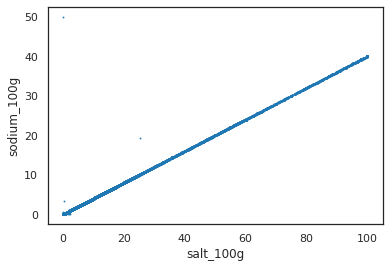

In [106]:
def plot_salt_sodium(df):
    if len(cols_in_df(data_df,['salt_100g','sodium_100g'])) == 2:
        sns.regplot(data=df,x='salt_100g',y='sodium_100g',scatter_kws={'s':1}, fit_reg=False)
        to_png('5.3.1_plot_salt_sodium_regplot')
        #sns.scatterplot(data=df,x='salt_100g',y='sodium_100g',size=1)

data_df.pipe(plot_salt_sodium);

In [107]:
def drop_aberrant_sodium_100g(df):
    """le sodium_100g doit être salt/2.5
    Il se peut que le sodium_100g et salt_100g sont simplement invertis
    Si c'est le cas, cette procédure supprime le registre car c'est abérrant
    """
    if ('sodium_100g' in df.columns) and ('salt_100g' in df.columns): 
        filtre = df['sodium_100g']>df['salt_100g']/2.4 
        nb_rows= filtre.sum()
        print(f'drop_aberrant_sodium_100g, nb registres aberrants : {nb_rows}')
        return df[~filtre]
    else: return df

data_df=data_df.pipe(drop_aberrant_sodium_100g);

drop_aberrant_sodium_100g, nb registres aberrants : 32


## 5.4 energy_100g > 3800 kJ


In [108]:
def drop_aberrant_energy(df):
    if not ('energy_100g' in df.columns): 
        return df
    filtre = df['energy_100g']>3800
    nb_rows= filtre.sum()
    print(f'drop_aberrant_energy, nb registres aberrants : {nb_rows}')
    return df[~filtre]

data_df=data_df.pipe(drop_aberrant_energy);

drop_aberrant_energy, nb registres aberrants : 4254


### 5.4.1 energy_kcal_100g > energy_100g / 4.184



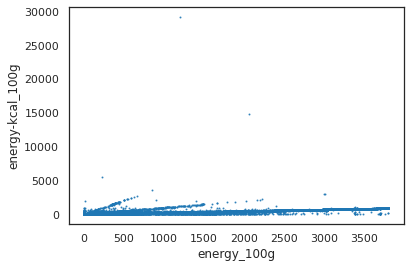

In [109]:
def plot_energy_kcal(df):
    if len(cols_in_df(data_df,['energy_100g','energy-kcal_100g'])) == 2:
        sns.regplot(data=df,x='energy_100g',y='energy-kcal_100g',scatter_kws={'s':1}, fit_reg=False)
        
        
data_df.pipe(plot_energy_kcal)
to_png('5.4.1_plot_energy_kcal_regplot_avant_nettoyage')



drop_aberrant_energy_kcal[1], nb registres aberrants : 18951


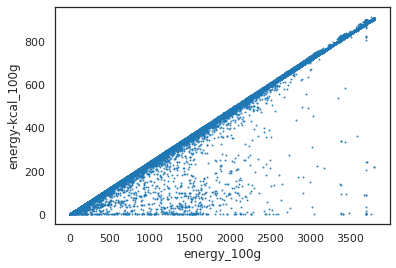

In [110]:
def drop_aberrant_energy_kcal(df):
    """l'énergie en kcal ne doit pas être plus que l'énergie en kJ
    Il se peut que l'energie en kJ et énergie en kcal sont simplement invertis
    Si c'est le cas, cette procédure supprime le registre car c'est abérrant
    """
    if ('energy-kcal_100g' in df.columns) and ('energy_100g' in df.columns): 
        filtre = df['energy-kcal_100g']>df['energy_100g']/4.1
        nb_rows= filtre.sum()
        print(f'drop_aberrant_energy_kcal[1], nb registres aberrants : {nb_rows}')
        if 'energy-kj_100g' in df.columns: 
            filtre2 = df['energy-kcal_100g']>df['energy-kj_100g']/4.1
            nb_rows= filtre2.sum()
            print(f'drop_aberrant_energy_kcal[2], nb registres aberrants : {nb_rows}')
            filtre = filtre | filtre2
        return df[~filtre]
    else: return df

data_df=data_df.pipe(drop_aberrant_energy_kcal)
data_df.pipe(plot_energy_kcal)
to_png('5.4.1_plot_energy_kcal_regplot_apres_nettoyage')

In [111]:
def plot_energy_kj_kcal(df):
    if len(cols_in_df(data_df,['energy-kj_100g','energy-kcal_100g'])) == 2:
        sns.regplot(data=df,x='energy-kj_100g',y='energy-kcal_100g',scatter_kws={'s':1}, fit_reg=False)
        to_png('5.4.1_plot_energy_kj_kcal_regplot')
    else:
        print("'energy-kj_100g' pas dans dataframe")
        
        
data_df.pipe(plot_energy_kj_kcal)


'energy-kj_100g' pas dans dataframe


## 5.5 Whitespace

On peut aussi (si besoin) appliquer majuscule, minuscule, enlève les accents, ...

In [112]:
print(data_df['product_name'].nunique())
print(data_df['product_name'].str.strip().nunique())

1246276
1245430


In [113]:
def trim_whitespace(df,col='labels'):
    if col in df.columns:
        df[col] = df[col].str.strip()
        print(f'trim_whitespace [{col}]')    
    return df

data_df=data_df.pipe(trim_whitespace,col='labels_en');
data_df=data_df.pipe(trim_whitespace,col='product_name');
# colonnes ou le whitespace change les nombre de valeurs uniques
# product_name	0.0%
# generic_name	0.2%
# quantity	0.6%
# brands	0.2%
# categories	0.0%
# labels	7.5%
# ingredients_text	0.0%
# serving_size	0.0%

trim_whitespace [labels_en]
trim_whitespace [product_name]


## 5.6 Pipeline pour traiter les valeurs aberrantes

In [114]:
def pipeline_traiter_valeurs_aberrantes(df):
    print(f'pipeline_traiter_valeurs_aberrantes, start_time={datetime.now().time():%H:%M:%S}')

    return (df
            .pipe(drop_non_foods,col='main_category_en')
            .pipe(drop_non_foods,col='product_name')
            .pipe(drop_aberrant_valeurs_nutritionnelles)
            .pipe(drop_aberrant_servings)
            .pipe(drop_aberrant_sodium_100g)
            .pipe(drop_aberrant_energy)
            .pipe(drop_aberrant_energy_kcal)
            .pipe(trim_whitespace)
            )

data_df=data_df.pipe(pipeline_traiter_valeurs_aberrantes)

pipeline_traiter_valeurs_aberrantes, start_time=08:46:37
liste_non_foods [main_category_en] (nb=58)
drop_non_foods [main_category_en], nb=58
liste_non_foods [product_name] (nb=19)
drop_non_foods [product_name], nb=0
get_aberrant_valeurs_nutritionnels, nb=0
drop_aberrant_valeurs_nutritionnelles, nb registres aberrants : 0
get_sum_valeur_nutritionnelle_trop_grand, nb registres ou total(servings)=0 : 0
example :
Empty DataFrame
Columns: [fat_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g]
Index: []
drop_aberrant_sodium_100g, nb registres aberrants : 0
drop_aberrant_energy, nb registres aberrants : 0
drop_aberrant_energy_kcal[1], nb registres aberrants : 0


# 6. Etude des valeurs atypiques
Les valeurs atypiques sont des outliers, par exemple :
- aucune valeur nutritionnelle 
- beaucoup d'additifs (ex M&Ms)
- beaucoup de sel (paquet de sel)
- beaucoup de sucre (paquet de sucre)
- beaucoup de gras (bouteille d'huile d'olive)
- score très haut ou très bas
- date très ancien

## 6.1 Produits avec zero valeur nutritionnelle
Par exemple : bouteille d'eau, boissons zero calories

In [115]:
def get_zero_valeur_nutritionnelle(df:pd.DataFrame):
    servings = cols_in_df(df,['fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g'])
    filtre_ignore_incomplete= df[servings].notnull().all(1) 
    filtre_total_is_zero =  df[servings].sum(axis=1) <= 0 
    filtre= filtre_ignore_incomplete & filtre_total_is_zero
    nb_rows= filtre.sum()
    print(f'get_zero_valeur_nutritionnelle, nb registres ou total(servings)=0 : {nb_rows}')
    zero_val_nutr=df[filtre]
    print(zero_val_nutr['pnns_groups_2'].value_counts().head(4))
    return zero_val_nutr
     

data_df.pipe(get_zero_valeur_nutritionnelle)[['product_name','pnns_groups_2']].head(10)

get_zero_valeur_nutritionnelle, nb registres ou total(servings)=0 : 3533
Unsweetened beverages               460
Sweets                              283
Waters and flavored waters          255
Artificially sweetened beverages    157
Name: pnns_groups_2, dtype: int64


product_name pnns_groups_2
354396                             Perfectly powerful minits        Sweets
1182436                       Airwaves menthol et eucalyptus        Sweets
1182389  Chewing-gum sans sucres aux goûts menthol et menthe        Sweets
1252848                              Airwaves Cherry Menthol        Sweets
924906                     Merck Bion 3 Séniors 90 Comprimés           NaN
407337                                Gefen, wonder confetti           NaN
118927                                         Tropical Pops           NaN
1182850                                      Freedent Fraise        Sweets
463902   Elite, bazooka, sugar free bubble gum, tutti frutti        Sweets
1182336                                  Dragées chlorophyle        Sweets

## 6.2 Variables numériques : Identification des outliers via box_plots
Les box plots montre visuellement 5 des valeurs fourni par dataframe.describe

Le box indique ou la moitié des observations tombe (IQR = Inter Quartile Range = Q1 à Q3)

- Q3 = 75th percentile (max valeur de la boite)
- Q2 = 50th percentile (médiane ligne au 'milieu' de la boite)
- Q1 = 25th percentile (min valeur de la boite)

Les lignes (whisker) represent 1.5 * (Q2-Q1) en bas ; 1.5 * (Q3-Q2) en haut

Valeurs hors de ces lignes sont considérés des 'outliers'

Les outliers peut avoir trop d'influence sur l'analyse :
- les statistiques
- les correlations
- les imputations

Donc, il faut les supprimer ou ignorer dans certaines analyses

numeric_cols : ['serving_quantity', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


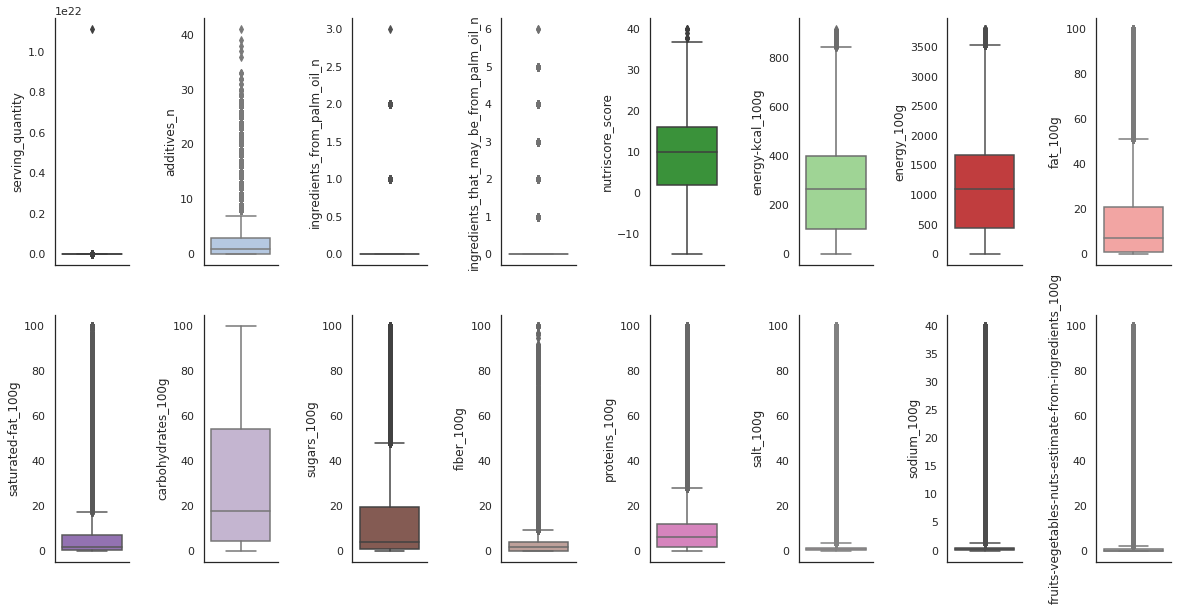

In [116]:
def plot_colonnes_as_box(df:pd.DataFrame):
    # mean and median in centre if normal
    numeric_cols=df.select_dtypes('number').columns.tolist()
    print(f'numeric_cols : {numeric_cols}')
    n_rows= 2
    n_cols=(len(numeric_cols)+1) // n_rows
    if (len(numeric_cols) % n_cols) > 0: n_rows+=1
    colors= sns.color_palette("tab20").as_hex()[:len(numeric_cols)+1]
    if len(colors)< len(numeric_cols):
        colors = colors + colors # max 40 colonnes
    _, ax = plt.subplots(figsize=(20,10), ncols=n_cols, nrows= n_rows)
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=plt.subplot(n_rows, n_cols, i+1), color=colors[i])
        sns.despine()
    # espace entre les plots
    plt.subplots_adjust(wspace=1, hspace=0.2)
    to_png(f'6.2_identification_outliers_par_boxplot')

data_df.pipe(plot_colonnes_as_box)

## 6.3 Variables numériques : distributions (Histograms)
Pas besoin de calculer les bins pour toutes les données, un échantillon nous donne une bonne representation

numeric_cols : ['serving_quantity', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


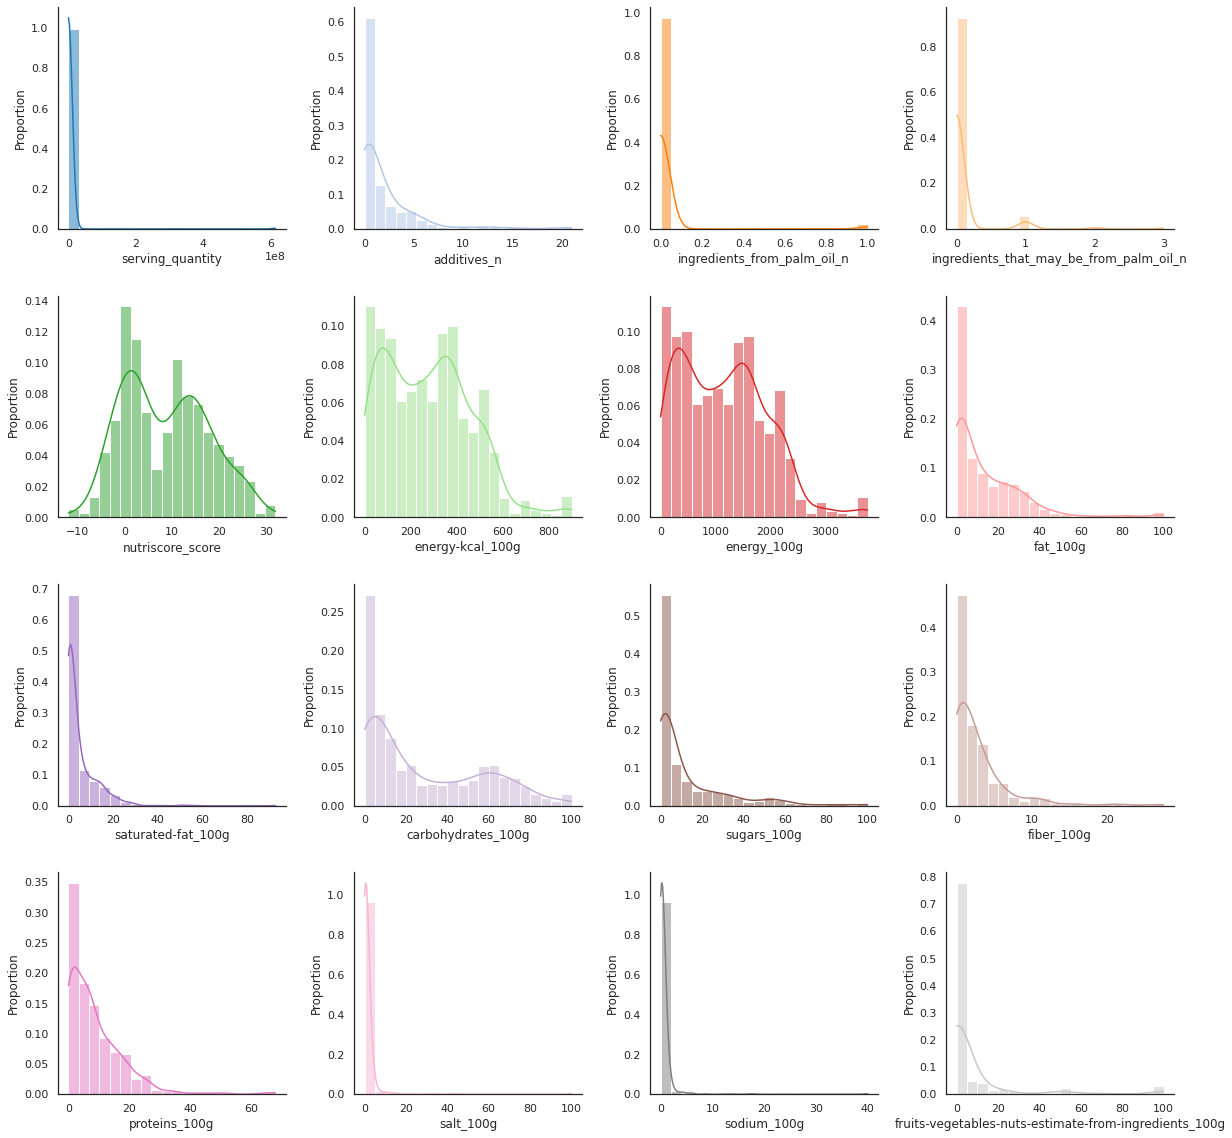

In [117]:
def plot_colonnes_as_histogram(df):
    numeric_cols=df.select_dtypes('number').columns.tolist()
    print(f'numeric_cols : {numeric_cols}')
    n_cols=4
    n_rows=len(numeric_cols) // n_cols 
    if (len(numeric_cols) % n_cols) > 0: n_rows+=1
    colors= sns.color_palette("tab20").as_hex()[:len(numeric_cols)]
    if len(colors)< len(numeric_cols):
        colors = colors + colors # max 40 colonnes
    _, ax = plt.subplots(figsize=(20,20), ncols=n_cols, nrows= n_rows)
    sample_size=min(1000,len(df))
    dfs=df[numeric_cols].sample(sample_size)
    for i, col in enumerate(numeric_cols):
        ax=sns.histplot(dfs[col].dropna().astype(float), ax=plt.subplot(n_rows, n_cols, i+1), 
        bins=20, kde=True, stat='proportion',color=colors[i])
        ax.set_xlabel(col)
        sns.despine()

    # espace entre les plots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    to_png(f'6.3_distribution_colonnes_numeriques_histogram')

data_df.pipe(plot_colonnes_as_histogram)

## 6.4 Variables numériques : description avec skew et kurtosis
On peut résumer les distributions avec mean, var, skew et kurtosis

In [118]:
def decrire_distribution(df:pd.DataFrame):
    stats = df.describe(include=[np.number],datetime_is_numeric=True)
    cols=stats.columns.tolist()
    # stats.loc['var'] = df[cols].var().tolist()
    stats.loc['skew'] = df[cols].skew().tolist()
    stats.loc['kurt'] = df[cols].kurtosis().tolist()
    return stats

stats=data_df.pipe(decrire_distribution)
print(len(stats.columns.tolist()))
stats

16


serving_quantity    additives_n  ingredients_from_palm_oil_n  \
count      4.243900e+05  633697.000000                633697.000000   
mean       2.618137e+16       2.025143                     0.021655   
std        1.705591e+19       2.902195                     0.147516   
min        0.000000e+00       0.000000                     0.000000   
25%        2.800000e+01       0.000000                     0.000000   
50%        5.300000e+01       1.000000                     0.000000   
75%        1.130000e+02       3.000000                     0.000000   
max        1.111111e+22      41.000000                     3.000000   
skew       6.514522e+02       2.409036                     6.842302   
kurt       4.243900e+05       8.645634                    47.195145   

       ingredients_that_may_be_from_palm_oil_n  nutriscore_score  \
count                            633697.000000     595074.000000   
mean                                  0.072882          9.144765   
std                                   0.311859          8.857363   
min                                   0.000000        -15.000000   
25%                                   0.000000          2.000000   
50%                                   0.000000         10.000000   
75%                                   0.000000         16.000000   
max                                   6.000000         40.000000   
skew                                  5.309658          0.108271   
kurt                                 36.099426         -0.942685   

       energy-kcal_100g   energy_100g      fat_100g  saturated-fat_100g  \
count      1.212494e+06  1.258836e+06  1.252845e+06        1.212025e+06   
mean       2.726682e+02  1.138233e+03  1.339927e+01        4.995664e+00   
std        1.878898e+02  7.850906e+02  1.707486e+01        7.646339e+00   
min        0.000000e+00  0.000000e+00  0.000000e+00        0.000000e+00   
25%        1.040000e+02  4.350000e+02  8.400000e-01        1.000000e-01   
50%        2.630000e+02  1.096000e+03  7.000000e+00        1.800000e+00   
75%        4.000000e+02  1.674000e+03  2.100000e+01        7.000000e+00   
max        9.150000e+02  3.800000e+03  1.000000e+02        1.000000e+02   
skew       4.947427e-01  4.979410e-01  2.162378e+00        3.412222e+00   
kurt      -1.913883e-01 -1.980885e-01  6.220437e+00        2.191643e+01   

       carbohydrates_100g   sugars_100g     fiber_100g  proteins_100g  \
count        1.252633e+06  1.233493e+06  435802.000000   1.254056e+06   
mean         2.934109e+01  1.363380e+01       3.076540   8.386201e+00   
std          2.794043e+01  1.953769e+01       4.936157   9.673759e+00   
min          0.000000e+00  0.000000e+00       0.000000   0.000000e+00   
25%          4.400000e+00  8.000000e-01       0.000000   1.400000e+00   
50%          1.769000e+01  4.000000e+00       1.700000   5.900000e+00   
75%          5.400000e+01  1.960000e+01       3.600000   1.200000e+01   
max          1.000000e+02  1.000000e+02     100.000000   1.000000e+02   
skew         6.397593e-01  1.848167e+00       5.330836   2.822320e+00   
kurt        -9.469559e-01  2.988849e+00      53.850061   1.426306e+01   

          salt_100g   sodium_100g  \
count  1.179077e+06  1.179074e+06   
mean   1.334751e+00  5.338990e-01   
std    4.680398e+00  1.872156e+00   
min    0.000000e+00  0.000000e+00   
25%    8.000000e-02  3.200000e-02   
50%    5.600000e-01  2.240000e-01   
75%    1.345000e+00  5.380000e-01   
max    1.000000e+02  4.000000e+01   
skew   1.375017e+01  1.375015e+01   
kurt   2.341671e+02  2.341665e+02   

       fruits-vegetables-nuts-estimate-from-ingredients_100g  
count                                          632259.000000  
mean                                                8.206134  
std                                                21.514008  
min                                                 0.000000  
25%                                                 0.000000  
50%                                                 0.000000

## 6.5 Variables catégoriques : description
Pour analyser les catégories, il faut savoir :
- le nombre de valeurs uniques
- la longueur des colonnes


In [119]:
def count_unique(df: pd.DataFrame):
    uniq_df = pd.DataFrame(columns=['column', 'unique'])
    categs= df.select_dtypes('category').columns.to_list()
    for col in categs:
        uniq_df = uniq_df.append({'column': col, 'unique': len(df[col].cat.categories)}, ignore_index=True)
    for col in df.columns:
        if df[col].dtype == 'object':
            # uniq= df[col].str.split(',', expand=True).stack().unique().tolist()
            # uniq = explode_series(df[col]).nunique()
            uniq = explode_series(pd.Series(df[col].unique())).nunique()
            uniq_df = uniq_df.append({'column': col, 'unique': uniq}, ignore_index=True)
    uniq_df = uniq_df.set_index('column')
    return uniq_df

# count_unique(data_df[['additives_en']])
count_unique(data_df)

unique
column                                             
nutriscore_grade                                  5
nova_group                                        4
pnns_groups_1                                    11
pnns_groups_2                                    41
code                                        1526678
creator                                       13000
product_name                                1263152
quantity                                      32802
brands                                       163681
brands_tags                                  121312
categories                                    71083
categories_tags                               35616
categories_en                                 35614
labels_en                                     18876
countries_en                                    551
ingredients_text                            1576811
serving_size                                  43584
additives_tags                                  567
additives_en                                    567
ingredients_from_palm_oil_tags                    6
ingredients_that_may_be_from_palm_oil_tags       19
states_en                                        41
main_category                                 31006
main_category_en                              31006

In [120]:
def max_len_colonnes(df: pd.DataFrame, sample_size=10000):
    """
    Retourne (un estimé du) largeur maximum des colonnes text d'un dataframe 
    - aide à valider l'uniformité des clés et autres données
    """
    if len(df) > sample_size :
        df=df.sample(sample_size)
    mesurer = np.vectorize(len)
    max_df = pd.DataFrame(columns=['column', 'max_len'])
    for col in df.columns:
        if df[col].dtype == 'object':
            uniq = df[col].dropna().explode().unique()
            # print(f'max_len_colonnes, nb uniq = {len(uniq)}')
            if len(uniq) > 1000:
                uniq = uniq[:1000]
            # print(f'max_len_colonnes, cut nb uniq = {len(uniq)}')
            max_len = mesurer(uniq.astype(str)).max(axis=0)
            max_df = max_df.append(
                {'column': col, 'max_len': max_len}, ignore_index=True)
    max_df = max_df.set_index('column')
    return max_df

max_len_colonnes(data_df[['additives_en']])


max_len
column              
additives_en     834

In [121]:
def decrire_dataframe(df: pd.DataFrame,calc_max_len=False):
    """
    Retourner un dataframe avec des informations sur les colonnes d'un dataframe
    """
    ret = df.columns.to_frame(name="column").set_index('column')
    ret['count'] = df.notnull().sum()
    # ret['unique'] = df.nunique() # ne marche pas avec des colonnes tag
    ret['unique'] = count_unique(df)
    ret['dtype'] = df.dtypes
    if calc_max_len:
        ret['max_length'] = max_len_colonnes(df)
    return ret.reset_index()

decrire_dataframe(data_df[['additives_en']], calc_max_len=True)


column   count unique   dtype max_length
0  additives_en  366087    567  object        734

In [122]:

def decrire_colonnes_object(df: pd.DataFrame,calc_max_len=False):
    """
    Retourner un dataframe avec des informations sur les colonnes objet d'un dataframe
    """
    obj_cols=df.select_dtypes(['object','category']).columns
    ret = obj_cols.to_frame(name="column").set_index('column')
    ret['count'] = df.notnull().sum()
    # ret['unique'] = df.nunique() # ne marche pas avec des colonnes tag
    ret['unique'] = count_unique(df)
    ret['dtype'] = df.dtypes
    for col in list(obj_cols):
        if (str(df[col].dtype) =='category'):
            ret.loc[col,'dtype']='category'
        #elif df[col].str.contains(',').any(): 
        #    ret.loc[col,'dtype']='list'
        else:
            ret.loc[col,'dtype']='str'
    if calc_max_len:
        ret['max_length'] = max_len_colonnes(df)
    return ret.reset_index()

decrire_colonnes_object(data_df[['pnns_groups_1']], calc_max_len=True)

column   count unique     dtype max_length
0  pnns_groups_1  619766     11  category        NaN

In [123]:
data_df.shape

(1526678, 42)

In [124]:
pd.set_option('display.max_rows', 200)
data_df.pipe(decrire_colonnes_object, calc_max_len=False)

column    count   unique     dtype
0                                         code  1526678  1526678       str
1                                      creator  1526675    13000       str
2                                 product_name  1526678  1263152       str
3                                     quantity   445076    32802       str
4                                       brands   905333   163681       str
5                                  brands_tags   905283   121312       str
6                                   categories   760901    71083       str
7                              categories_tags   760894    35616       str
8                                categories_en   760894    35614       str
9                                    labels_en   361409    18876       str
10                                countries_en  1523051      551       str
11                            ingredients_text   633695  1576811       str
12                                serving_size   428211    43584       str
13                              additives_tags   366087      567       str
14                                additives_en   366087      567       str
15              ingredients_from_palm_oil_tags    13542        6       str
16  ingredients_that_may_be_from_palm_oil_tags    38620       19       str
17                            nutriscore_grade   595074        5  category
18                                  nova_group   551184        4  category
19                               pnns_groups_1   619766       11  category
20                               pnns_groups_2   619768       41  category
21                                   states_en  1526678       41       str
22                               main_category   760894    31006       str
23                            main_category_en   760894    31006       str

In [125]:
# data_dict.to_csv(os_path_join(OUT_FOLDER, RAW_DATA_DICT), encoding='UTF-8',index=False))

# 7. Imputation de valeurs manquantes
Maintenant qu'on a compris la distribution des colonnes numériques et traité les outliers,
on peut imputer les valeurs manquantes

- Avec la fonction `.describe()` pour voir les min/max ou en faisant des boxplot pour visualiser la distribution, tu devrais y voir plus clair.
- En regardant les règles de (data quality)[https://github.com/openfoodfacts/openfoodfacts-server/blob/main/taxonomies/data_quality.result.txt]
  de OpenFoodFacts

  

## 7.1 Objectifs : 

Notre application se base sur les produits dont on connait les additifs :
1. remplir les valeurs nutriscore manquantes
2. imputer les valeurs nutritionnelles manquantes
3. remplir le main_category manquantes

### 7.1.1 Ordre de remplissage des valeurs manquantes
- On trie par taux de remplissage, pour déterminer l'ordre de rémplissage 

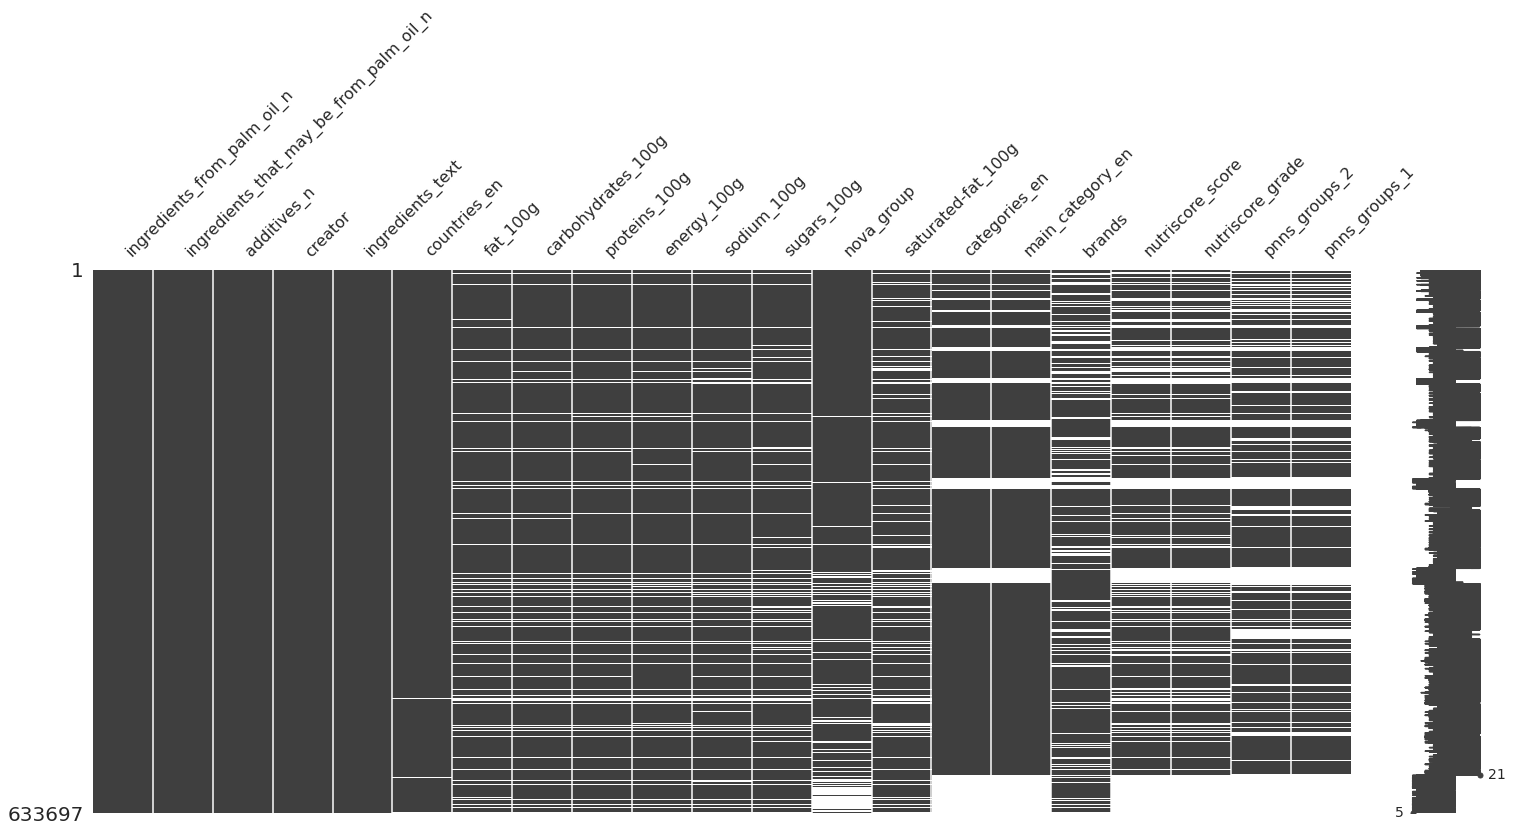

In [126]:
def sort_columns_by_remplissage(df):
    return df.isnull().mean().sort_values().index.to_list()

def plot_ordre_remplissage_valeurs_manquantes(df):    
    data_to_explore=df.dropna(subset=['additives_n'])
    anal_cols= cols_in_df(data_to_explore,analyse_cols)
    cols= sort_columns_by_remplissage(data_to_explore[anal_cols])
    data_to_explore.pipe(plot_missing_matrix, cols=cols)
    to_png(f'7.1.1_ordre_de_remplissage_valeurs_manquantes')

data_df.pipe(plot_ordre_remplissage_valeurs_manquantes)

### Ordre d'imputation des valeurs manquantes

La stratégie de remplissage des valeurs manquantes est:
1. Remplir les valeurs nutritionnelles manquantes
1. remplir les valeurs nutriscore manquantes par 
2. imputer les valeurs nutritionnelles manquantes
3. remplir le main_category manquantes

## 7.2 Tests de normalité des distributions
Pour pouvoir choisir une stratégie de remplissage des valeurs manquantes,
il faut determiner si les variables sont distribuées normalement

- histogram / kde (ci-dessus, comparer avec distribution normal)
- box plot (ci-dessus, moyenne et médiane au centre si la distribution est normal)
- describe() (ci-dessus, skew=0 et kurtosis=0 si normal)
- QQ plot (ligne et droite si la distribution normale)
- tests:
        - Kolmogorov-smirnov, très susceptible aux outliers
        - Shapiro Wilk 

Référence :
- https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
- https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

### 7.2.2 Tests de normalité - distribution plots (histograms / kde), boxplots, quantile-quantile plots

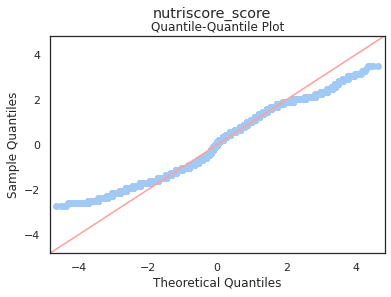

In [127]:
# Quantile Quantile Plot
# Ordered values versus theoretical quantiles
import statsmodels.api as sm
import pandas.util.testing as tm
# from scipy.stats import norm

def plot_qq(df,series='nutriscore_score',titre='Quantile-Quantile Plot'):
    sm.qqplot(df[series].dropna(), line='45',fit=True)
    plt.title(titre)
    plt.suptitle(series)

plot_qq(data_df,series='nutriscore_score')
to_png(f'7.2.1_test_normalite_qq_plot_nutriscore_score')


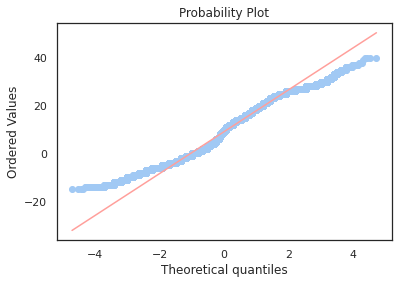

In [128]:
import scipy.stats as stats
# generate a normal distrib
def plot_qq2(df,series):
    stats.probplot(df[series].dropna(), dist='norm', fit=True,plot=plt)
    # x = stats.norm.rvs(loc=0, scale=1, size=1000)
    # stats.probplot(x, dist='norm', plot=plt)

plot_qq2(data_df,'nutriscore_score')
to_png(f'7.2.1_test_normalite_qq2_plot_nutriscore_score')


### 7.2.2 Tests de normalité - statistiques et p-values

In [129]:


def print_stat_p(testname,stat,p):
    print (f'{testname}: stat={stat:.3f}, p={p:.3f}')
    # reject H0 if p<=0.05
    if p> 0.05:
        print('probably Gaussian')
    else:
        print('probably not Gaussian')

def format_stat_p(stat, p):
    ch= f'stat={stat:.3f}, p={p:.3f} '
    if p<0.001: ch +='***'
    elif p<0.01: ch +='**'
    elif p<0.05: ch +='*'
    return ch

In [130]:
# Shapiro-Wilk test (1965)
from scipy.stats import norm,shapiro

def test_shapiro(series):
    my_data = norm.rvs(size=500)
    stat, p = shapiro(series)
    # print_stat_p('Shapiro-Wilk', stat,p)
    return format_stat_p(stat,p)

In [131]:
#D’Agostino’s K-squared test
# D’Agostino’s K-squared test check’s normality of a variable based on skew (symmetry) and kurtosis.
from scipy.stats import normaltest
def test_k_squared(series):
    (stat,p)=normaltest(series)
    # print_stat_p('D’Agostino’s K-squared',stat,p)
    return format_stat_p(stat,p)

# Jarque-Bera (based on Skew and kurtosis, n > 2000)
from scipy.stats import jarque_bera
def test_jarque_bera(series):
    stat,p=jarque_bera(series)
    # print_stat_p('Jarque-Bera',stat,p)
    return format_stat_p(stat,p)


#Chi-square test for normality
from scipy.stats import chisquare
def test_chi_square(series):
    stat,p=chisquare(series)
    # print_stat_p('Chi-square',stat,p)
    return format_stat_p(stat,p)

#lilliefors
from statsmodels.stats.diagnostic import lilliefors
def test_lilliefors(series):
    stat,p=lilliefors(series)
    # print_stat_p('Lilliefors',stat,p)
    return format_stat_p(stat,p)

In [132]:
# Kolmogorov-Smirnov goodness of fit test
# tests the distribution F(x) of an observed random variable against the normal distribution
from scipy.stats import kstest
def test_kolmogorov_smirnov(series):
    stat, p = kstest(series, 'norm')
    # print_stat_p('Kolmogorov-Smirnov',stat,p)
    return format_stat_p(stat,p)

In [133]:
def test_normality(df):
    stats= decrire_distribution(df)
    cols=stats.columns.tolist()
    for col in cols:
        series=df[col].dropna()
        sample_size=min(4000,len(series))
        vals=series.sample(sample_size)
        stats.loc['K-squared',col]=test_k_squared(vals)
        stats.loc['Shapiro',col]=test_shapiro(vals)
        stats.loc['Chi-square',col]=test_chi_square(vals)
        # stats.loc[col,'Kolmogorov_Smirnov']=test_kolmogorov_smirnov(vals)
    
    return stats

data_df.pipe(test_normality)

serving_quantity                  additives_n  \
count                             424390                       633697   
mean                         2.61814e+16                      2.02514   
std                          1.70559e+19                      2.90219   
min                                    0                            0   
25%                                   28                            0   
50%                                   53                            1   
75%                                  113                            3   
max                          1.11111e+22                           41   
skew                             651.452                      2.40904   
kurt                              424390                      8.64563   
K-squared     stat=3651.215, p=0.000 ***   stat=2160.859, p=0.000 ***   
Shapiro          stat=0.654, p=0.000 ***      stat=0.714, p=0.000 ***   
Chi-square  stat=575128.145, p=0.000 ***  stat=16455.290, p=0.000 ***   

           ingredients_from_palm_oil_n  \
count                           633697   
mean                         0.0216555   
std                           0.147516   
min                                  0   
25%                                  0   
50%                                  0   
75%                                  0   
max                                  3   
skew                            6.8423   
kurt                           47.1951   
K-squared   stat=4911.240, p=0.000 ***   
Shapiro        stat=0.128, p=0.000 ***   
Chi-square     stat=4087.778, p=0.160    

           ingredients_that_may_be_from_palm_oil_n  \
count                                       633697   
mean                                     0.0728818   
std                                       0.311859   
min                                              0   
25%                                              0   
50%                                              0   
75%                                              0   
max                                              6   
skew                                       5.30966   
kurt                                       36.0994   
K-squared               stat=4437.019, p=0.000 ***   
Shapiro                    stat=0.246, p=0.000 ***   
Chi-square              stat=5566.814, p=0.000 ***   

                       nutriscore_score              energy-kcal_100g  \
count                            595074                   1.21249e+06   
mean                            9.14477                       272.668   
std                             8.85736                        187.89   
min                                 -15                             0   
25%                                   2                           104   
50%                                  10                           263   
75%                                  16                           400   
max                                  40                           915   
skew                           0.108271                      0.494743   
kurt                          -0.942685                     -0.191388   
K-squared     stat=773.365, p=0.000 ***     stat=141.660, p=0.000 ***   
Shapiro         stat=0.973, p=0.000 ***       stat=0.959, p=0.000 ***   
Chi-square  stat=35116.649, p=0.000 ***  stat=505160.310, p=0.000 ***   

                              energy_100g                     fat_100g  \
count                         1.25884e+06                  1.25284e+06   
mean                              1138.23                      13.3993   
std                               785.091                      17.0749   
min                                     0                            0   
25%                                   435                         0.84   
50%                                  1096                            7   
75%                                  1674                           21   
max                                  380

On voit qu'aucun des colonnes numériques a une distribution normale

## 7.3 Evaluation des techniques d'imputation de valeurs manquantes 
- <https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py>
-<https://towardsdatascience.com/preprocessing-regression-imputation-of-missing-continuous-values-f612179bafb4>

### 7.3.1 Techniques d'imputation différentes :

- SimpleImputer : imputation avec une valeur constante (0)
- SimpleImputer : imputation avec la moyenne
- KNNImputer    : imputation avec k nearest neighbor
- IterativeImputer: imputation iterative (MICE)


L'imputation iterative fait plusieurs iterations, exige encodage des variables catégoriques et peut prend beaucoup de temps

#### Étapes pour évaluer la performance d'une méthode d'imputation
1. Choisir des colonnes X pour imputer la variable y
2. Créer un jeu de données sans valeurs manquantes `[X,y].dropna()`
3. Diviser en jeux de données `train` et `test`
4. entrainer le model sur des données `train`
5. tester la performance du model sur de données `test`, pas connu du model

Basé sur les résultats, choisir la meilleure méthode d'imputation


### 7.3.2 Création de jeu de données X(features) et y(target)

On crée un jeu de données complet pour entrainer le model et tester sont performance

In [134]:
def get_jeu_x_y(df, x_vars=[], y_vars=['nutriscore_score'], sample_size=10000, dropna=True):
    """Créer un jeu de données pour entrainer et évaluar plusieurs classifiers
    - Pas besoin de toute les registres 
    """
    if x_vars is None or len(x_vars) ==0:
        x_vars= get_colonnes_nutritionnelles_100g(df)
    x_vars=cols_in_df(df,x_vars)    
#    x_vars=['energy_100g','sugars_100g','saturated-fat_100g','sodium_100g','fat_100g','proteins_100g','fiber_100g','carbohydrates_100g']
    y_vars=cols_in_df(df,y_vars)  
    ret=df[x_vars + y_vars].dropna() if dropna else df[x_vars + y_vars].dropna(subset=x_vars,how='all')
    sample_size=min(len(ret), sample_size)
    ret=ret.sample(sample_size)
    return ret[x_vars], ret[y_vars]

# Pour entrainement et comparaison d'estimateurs, pas besoin de toutes les registres
# On limite la taille
SAMPLE_SIZE=10000
x_vars= get_colonnes_nutritionnelles_100g(data_df)
X, y = get_jeu_x_y(data_df, sample_size=SAMPLE_SIZE)
print (X.shape)
print (y.shape)

(10000, 9)
(10000, 1)


On note que seulement 20% des données sont complétement remplis

### 7.3.2 Étape 1 : Création des jeux de données train et test

Division des données X et y en jeu d'entrainement du model ('train') et jeu d'évaluation du model ('test')

Pour comparer la performance des différentes imputations, on entraîne chaque model sur le jeu de données train et puis fait un evaluation de performance sur un jeu de données test.
- `random_state` permet de reproduire les résultats identiques à chaque run de ce notebook.

In [135]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(X,y.to_numpy().ravel(),test_size=0.2,random_state=2)

print(f'x_train: {x_train.shape}; y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}; y_test: {y_test.shape}')

# data={'x_train':x_train,'x_test':x_test,'y_train':y_train,'y_test':y_test}

x_train: (8000, 9); y_train: (8000,)
x_test: (2000, 9); y_test: (2000,)


### 7.3.3 Model 1 : régression linéaire sur les variables X, sans normalisation

In [136]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Entraine sur le jeu de données 'train'
model.fit(x_train,y_train)

# Evaluation de précision de nutriscore_score
model.score(x_test,y_test)

0.6426295437031379

#### Autres mesures de performance
- r2_score (défaut): le coefficient de determination R^2 of the prediction.
- MAE (mean_absolute_error)
- MSE (mean_square_error)
- RMSE (root_mean_square_error).

Nutriscore_score est discrete -> on peut aussi considéré un problème de classification
- accuracy_score. 

In [137]:
# Prédire sur le jeu de données 'test'
y_pred = model.predict(x_test).round()

from sklearn import metrics
print(f'R2={metrics.r2_score(y_test,y_pred)}')
print(f'MAE={metrics.mean_absolute_error(y_test,y_pred)}')
print(f'MSE={metrics.mean_squared_error(y_test,y_pred)}')
print(f'Accuracy={metrics.accuracy_score(y_test,y_pred)}')

R2=0.639652099203843
MAE=4.196
MSE=29.492
Accuracy=0.0645


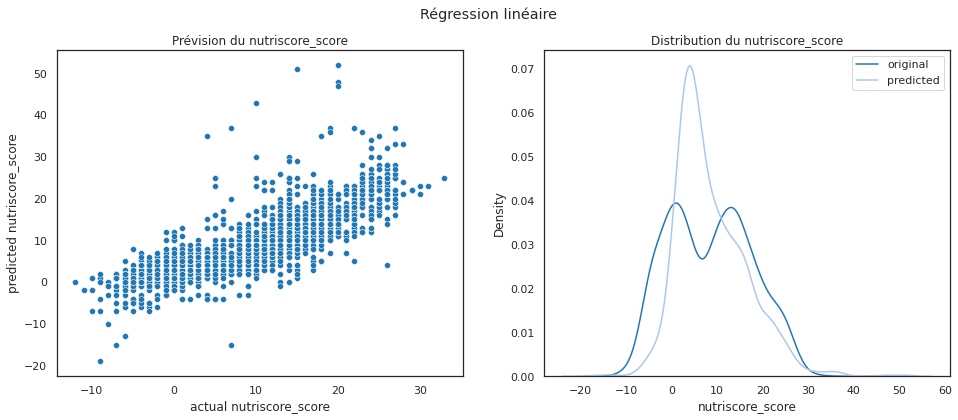

In [138]:
def plot_predict_vs_actual(y_test=[1,2,3],y_pred=[1,2,3], hue=None,titre=''):
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax=plt.subplot(1,2,1)
    sns.scatterplot(x=y_test,y=y_pred,hue=hue,legend=None, ax=ax)
    if not (isinstance(y_test[0], str)):
        r2=metrics.r2_score(y_test,y_pred)
        ax.annotate(f'R2 = {r2:.3f}',xy=(-15,20))
    # plt.text(f'R2 = {r2:.3f}',xy=(0,0.9))
    ax.set_xlabel('actual nutriscore_score')
    ax.set_ylabel('predicted nutriscore_score')
    ax.set_title('Prévision du nutriscore_score')
    if not hue is None:
        plt.legend(labels=hue)
    plt.suptitle(titre)
    ax=ax=plt.subplot(1,2,2)
    # Plot the original distribution
    sns.kdeplot(y_test, label='Original Distribution', ax=ax)
    sns.kdeplot(y_pred, label='Predicted Distribution',ax=ax)
    plt.legend(labels=['original', 'predicted'])
    ax.set_xlabel('nutriscore_score')
    # ax.set_ylabel('')
    ax.set_title('Distribution du nutriscore_score')

plot_predict_vs_actual(y_test,y_pred, titre='Régression linéaire')
to_png('7.3.3_imputation_nutriscore_par_regression_lineaire')

On voit que l'imputation par régression linéaire n'est pas adaptée pour le nutriscore, car
- la distribution n'est pas normal,
- la regression linéaire des valeurs manquantes change beaucoup la distribution
- il est très susceptible à des outliers 

### 7.3.4 Model 2 : KNeighbors estimation de Nutriscore, sans normalisation

- <https://www.ritchieng.com/machine-learning-k-nearest-neighbors-knn/>

KNN score=0.2705
Accuracy=0.2705
R2=0.7918762387016364
MAE=2.6165
MSE=17.0335


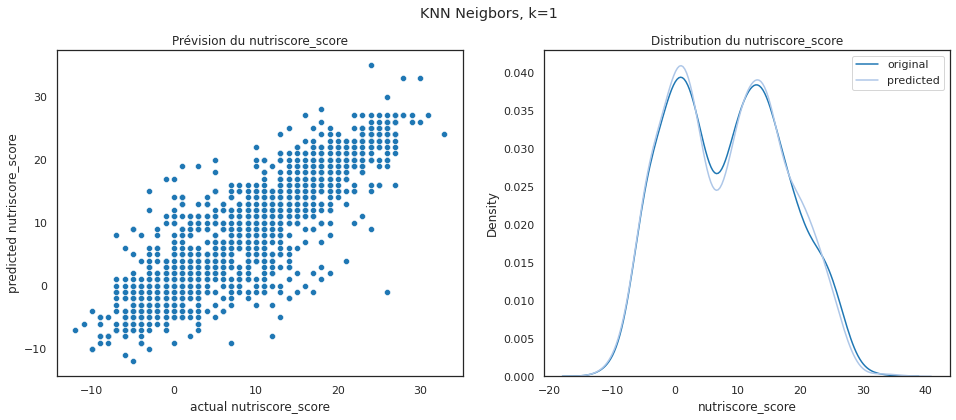

In [139]:

from sklearn.neighbors import KNeighborsClassifier

def plot_knn_estimates(k_val=1):
    knn = KNeighborsClassifier(n_neighbors=k_val)
    knn.fit(x_train, y_train)
    print(f'KNN score={knn.score(x_test,y_test)}')

    y_pred = knn.predict(x_test)

    print(f'Accuracy={metrics.accuracy_score(y_test,y_pred)}')
    print(f'R2={metrics.r2_score(y_test,y_pred)}')
    print(f'MAE={metrics.mean_absolute_error(y_test,y_pred)}')
    print(f'MSE={metrics.mean_squared_error(y_test,y_pred)}')
    plot_predict_vs_actual(y_test,y_pred,titre=f'KNN Neigbors, k={k_val}')

plot_knn_estimates(k_val=1)
to_png('7.3.4_imputation_nutriscore_par_KNN_1')

### 7.3.5 Model 3 : Essaie avec plusieurs valeurs de k voisins

In [140]:
def score_knn_model( x_train, x_test,y_train,y_test,k_max=15):
    k_range = range(1, k_max)
    scores = {}

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        scores[k]=metrics.accuracy_score(y_test, y_pred)
    return scores
    
scores=score_knn_model(x_train, x_test,y_train,y_test, k_max=15)
print(scores)

{1: 0.2705, 2: 0.249, 3: 0.2305, 4: 0.2255, 5: 0.2255, 6: 0.233, 7: 0.225, 8: 0.2265, 9: 0.2315, 10: 0.231, 11: 0.223, 12: 0.2235, 13: 0.2195, 14: 0.215}


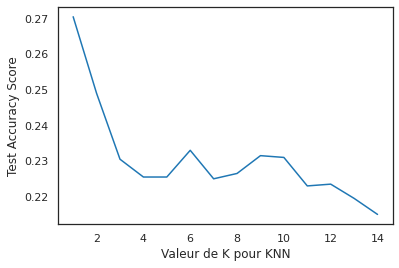

In [141]:
def plot_knn_elbow_curve(k_values,scores):
    """plot the relationship between K and testing accuracy"""
    ax=sns.lineplot(x=k_values, y=scores)
    ax.set_xlabel('Valeur de K pour KNN')
    ax.set_ylabel('Test Accuracy Score')

plot_knn_elbow_curve(k_values=scores.keys(),scores=scores.values())
to_png('7.3.5_imputation_nutriscore_par_KNN_elbow_curve')

- Ayant une valeur de K trop petit produit trop de bruit
- Si k est trop grand on perd le precision
- Meilleure valeur sera d'utiliser une valeur impar au coude du plot ci-dessus

Donc, on utilise la valeur k=3

KNN score=0.2305
Accuracy=0.2305
R2=0.7370335168542355
MAE=3.048
MSE=21.522


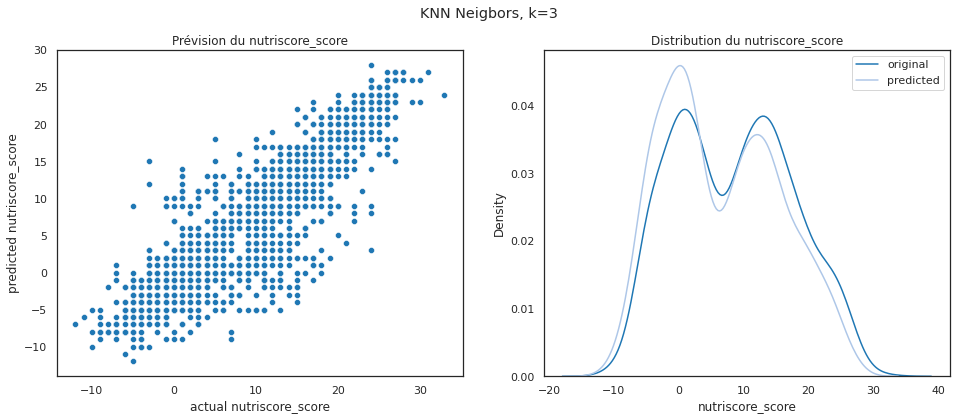

In [142]:
plot_knn_estimates(k_val=3)
to_png('7.3.5.1_imputation_nutriscore_par_KNN_3')

KNN score=0.2255
Accuracy=0.2255
R2=0.7236542631118038
MAE=3.118
MSE=22.617


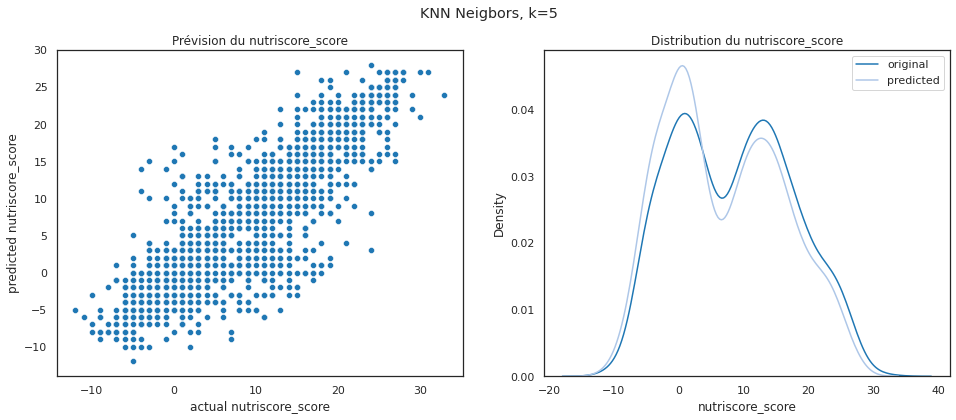

In [143]:
plot_knn_estimates(k_val=5)
to_png('7.3.5.2_imputation_nutriscore_par_KNN_5')

### 7.3.6 Model 4: Avec normalisation (Standard Scaler) des valeurs nutritionnels (via pipelines)

#### 7.3.6.1 Regression linéaire
Normalisation des valeurs ne change pas les résultats de régression linéaire - les coefficients de regression font la 'normalisation'

In [144]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(x_train, y_train)  # apply scaling on training data
score=pipe.score(x_test, y_test)  # apply scaling on testing data, without leaking training data.
y_pred=pipe.predict(x_test).round()

print(f'score = {score}')
if not isinstance(y_test,str):
    r2=metrics.r2_score(y_test,y_pred)
    accuracy=metrics.accuracy_score(np.round(y_test),np.round(y_pred))
    print(f'r2 = {r2}')
    print(f'accuracy = {accuracy}')





score = 0.6426295437031373
r2 = 0.639652099203843
accuracy = 0.0645


#### 7.3.6.2 KNN avec standard scalar

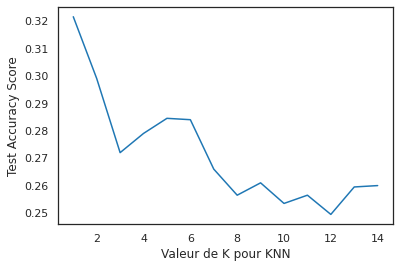

In [145]:
from sklearn.pipeline import Pipeline,make_pipeline

def score_knn_pipeline(x_train, x_test,y_train,y_test,k_max=15):
    k_range = range(1, k_max)
    scores = {}

    for k in k_range:
        # knn = KNeighborsClassifier(n_neighbors=k)
        model: Pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        scores[k]=metrics.accuracy_score(y_test, y_pred)
    return scores
    
scores=score_knn_pipeline(x_train, x_test,y_train,y_test,k_max=15)
plot_knn_elbow_curve(k_values=scores.keys(),scores=scores.values())
to_png('7.3.6.2_imputation_nutriscore_par_KNN_elbow_curve')

On voit la prevision (accuracy_score) est améliorée avec scaling

On utilise k=3 (le coude)


### 7.3.7 Améliorer le score en prenant compte de PNNS_group_1 et 2

['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fat_100g',
                                                   'saturated-fat_100g',
                                                   'carbohydrates_100g',
                                                   'sugars_100g', 'fiber_100g',
                                                   'proteins_100g', 'salt_100g',
                                    

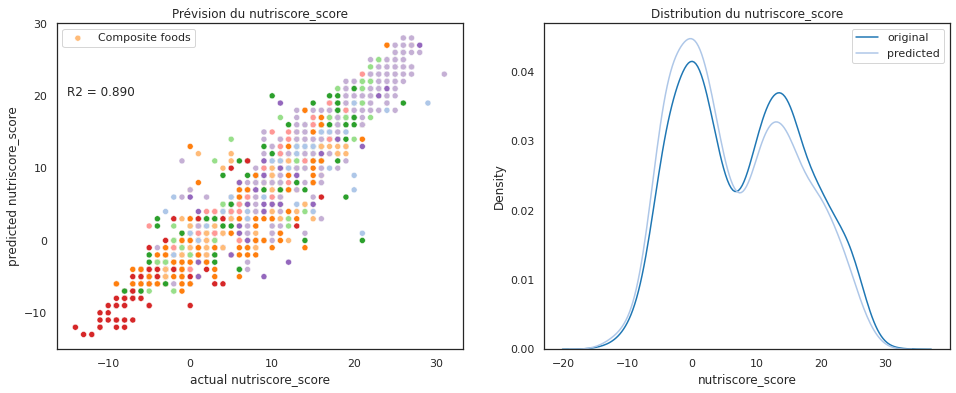

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer


numeric_features = ['energy_100g','sugars_100g','saturated-fat_100g','sodium_100g','fat_100g','proteins_100g','fiber_100g']
numeric_features=get_colonnes_nutritionnelles_100g(data_df)
#numeric_features=['energy_100g','fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
print(numeric_features)
numeric_transformer = Pipeline(
    steps=[
        ("imputer", KNNImputer()),
         ("scaler", StandardScaler())
         ]
)

categorical_features = ['pnns_groups_1','pnns_groups_2']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# define pipeline with an arbitrary number of transformer in a tuple array
model = Pipeline([
    ("pre", preprocessor),
    ("clf", KNeighborsClassifier(n_neighbors = 3))
])

print(model)
print('--------------------------')

# sample size = 100000 prend quelques minutes
SAMPLE_SIZE=min(10000, len(data_df))

x_vars= numeric_features + categorical_features
X, y = get_jeu_x_y(data_df, x_vars=x_vars, sample_size=SAMPLE_SIZE)
x_train, x_test,y_train,y_test = train_test_split(X,y.to_numpy().ravel(),test_size=0.2,random_state=2)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'KNN score = {model.score(x_test,y_test)}')
print(f'accuracy score = {metrics.accuracy_score(y_test,y_pred)}')

plot_predict_vs_actual(y_test,y_pred,hue=x_test['pnns_groups_1'])
to_png('7.3.7 KNN_k_3_avec_pnns_groups_1_et_2')

print(f'Misclassified samples: {(y_test != y_pred).mean():.4f}')


L'addition des variables catégoriques pnns_groups_1 et pnns_groups_2 améliore la prévision;

On a trés peu de données de `fiber_100g` et FLN(fruit légumes noix) - ce qui peux expliquer pourquoi on a toujours une grande écarte entre des prévisions et le nutriscore

In [147]:
x_train=y_train=x_test=y_test=y_pred=X=y=None
#del x_train; del y_train; del x_test; del y_test; del y_pred; del X; del y

### 7.3.8 Imputation avec des Imputers

Le scoring était fait avec des Classifiers

L'imputation est faite avec les Imputers
KNN imputation

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


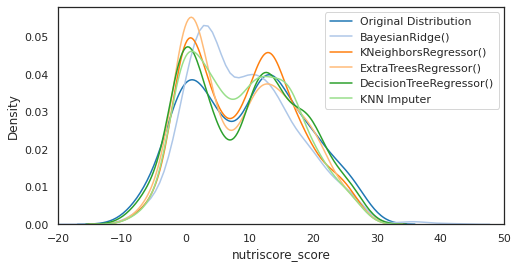

In [148]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer,KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

numeric_features = get_colonnes_nutritionnelles_100g(data_df)
    
#numeric_features=['energy_100g','sugars_100g','saturated-fat_100g','sodium_100g','fat_100g','proteins_100g','fiber_100g','carbohydrates_100g']
labels='nutriscore_score'

def plot_imputer_distributions(df,labels='nutriscore_score',features=numeric_features,show_features=False):
    data=df[features + [labels]].dropna(how='all')
    sample_size=min(1000,len(data))
    data=data.sample(sample_size).copy(deep=True)
    nb_rows = len(features)+1 if show_features else 1
    _, axs = plt.subplots(nrows=nb_rows, ncols=1 , figsize=(8,4*nb_rows))
    axs = axs if show_features else [axs]
    # Plot the original distribution
    sns.kdeplot(data[labels], label="Original Distribution", ax=axs[0])
    if show_features:
        for i in range(0,len(features)):
            sns.kdeplot(data[features[i]], label="Original Distribution", ax=axs[i+1])
    strategies = [
       IterativeImputer(estimator=BayesianRidge()),
       IterativeImputer(estimator=KNeighborsRegressor()),
       IterativeImputer(estimator=ExtraTreesRegressor()),
       IterativeImputer(estimator=DecisionTreeRegressor()),
    ]
    for imputer in strategies:
        imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
        sns.kdeplot(imputed_data[labels], label=imputer.estimator, ax=axs[0])
        if show_features:
            for i in range(0,len(features)):
                sns.kdeplot(imputed_data[features[i]], label=imputer.estimator, ax=axs[i+1])

    imputer=KNNImputer(n_neighbors=3)
    imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    sns.kdeplot(imputed_data[labels], label='KNN Imputer', ax=axs[0])
    if show_features:
        for i in range(0,len(features)):
            sns.kdeplot(imputed_data[features[i]], label='KNN Imputer', ax=axs[i+1])
    
    axs[0].set_xlim([-20, 50])
    for ax in axs:
        ax.legend()
    if show_features:
        plt.gcf().subplots_adjust(hspace=0.5)

SAMPLE_SIZE=min(10000, len(data_df))
plot_imputer_distributions(data_df.sample(SAMPLE_SIZE))
to_png('7.3.8_imputation_distributions_nutriscore')
  

Les meilleures distributions sont produites par KNNImputer et DecisionTreeRegressor, mais ça a du mal à converger

On utilise KNNImputer, car les distributions des colonnes nutritionnelles reste les plus similaires

## 7.4 Imputation des valeurs nutritionnelles

In [149]:
from datetime import datetime
from sklearn.impute import KNNImputer
numeric_features=['energy_100g','sugars_100g','sodium_100g','saturated-fat_100g','fat_100g','proteins_100g','fiber_100g']
labels=['nutriscore_score']
features_nutritionnelles = numeric_features + labels

def impute_valeurs_nutritionnelles_manquantes(df:pd.DataFrame, 
                                              features_to_impute=features_nutritionnelles, 
                                              sample_size=100000):
    features_to_impute=cols_in_df(df,features_to_impute)
    sample_size= max(len(df[features_to_impute].dropna(how='all')),1000)

    data_sample = df[features_to_impute].dropna(how='all').sample(sample_size)
    print(f'impute_valeurs_nutritionnelles_manquantes, data_sample.shape = {data_sample.shape}')
    # Init the transformer
    imputer =  make_pipeline(StandardScaler(), KNNImputer(n_neighbors=3, missing_values=np.nan))
    # imputer = KNNImputer(n_neighbors=3, missing_values=np.nan)
    # Fit (entraine) sur l'échantillon de registres
    print(f'impute_valeurs_nutritionnelles_manquantes, start_fit : {datetime.now().time():%H:%M:%S}')
    imputer.fit(data_sample)
    print(f'impute_valeurs_nutritionnelles_manquantes,   end_fit : {datetime.now().time():%H:%M:%S}')



    # Impute seulement ou il y a des données des additives et la nutriscore et inconnu 
    filtre= df['additives_n'].notnull() & df['nutriscore_score'].isna()
    print(f'nb. nutriscore to impute= {filtre.sum()}')
    data=df[filtre].copy()
    print(f'impute_valeurs_nutritionnelles_manquantes: \n{data[features_to_impute].isnull().sum()}')

    #other=df[~filtre]
    if len(data)>0:
        print(f'impute_valeurs_nutritionnelles_manquantes,   start_transform : {datetime.now().time():%H:%M:%S}')
        imputed_features_df = pd.DataFrame(
            imputer.transform(data[features_to_impute]),
            columns=features_to_impute)
        print(f'impute_valeurs_nutritionnelles_manquantes,   end_transform : {datetime.now().time():%H:%M:%S}')
    
        # Copié les valeurs imputés dans la dataframe
        data=data.copy()
        print(f'impute_valeurs_nutritionnelles_manquantes,   start_copy : {datetime.now().time():%H:%M:%S}')
        for col in features_to_impute:
            data[col] = imputed_features_df[col].values
        print(f'impute_valeurs_nutritionnelles_manquantes,   end_copy : {datetime.now().time():%H:%M:%S}')
        df=pd.concat([data,df[~filtre]],axis=0)
    
    return df

#check
#test_df=data_df.sample(min(1000000,len(data_df))) # 100000 lignes = 2 h
#test_df=data_df.sample(min(200000,len(data_df))) # 20000 lignes = 7 minutes
#test_df=data_df.sample(min(100000,len(data_df))) # 13000 lignes= 2 minutes
#test_df=data_df.sample(min(50000,len(data_df))) # 7000 lignes= 30 secondes
test_df=data_df.sample(min(20000,len(data_df))) # 2600 lignes= 5 secondes
new_df= test_df.pipe(impute_valeurs_nutritionnelles_manquantes)

#print(test_df[features_nutritionnelles].isnull().sum() )
print('----\nNombre de valeurs manquantes imputées')
print(new_df[features_nutritionnelles].isnull().sum()-test_df[features_nutritionnelles].isnull().sum()  )
del test_df; del new_df;

impute_valeurs_nutritionnelles_manquantes, data_sample.shape = (16866, 8)
impute_valeurs_nutritionnelles_manquantes, start_fit : 08:49:52
impute_valeurs_nutritionnelles_manquantes,   end_fit : 08:49:52
nb. nutriscore to impute= 2543
impute_valeurs_nutritionnelles_manquantes: 
energy_100g            807
sugars_100g            990
sodium_100g            858
saturated-fat_100g    1252
fat_100g               760
proteins_100g          782
fiber_100g            1745
nutriscore_score      2543
dtype: int64
impute_valeurs_nutritionnelles_manquantes,   start_transform : 08:49:52
impute_valeurs_nutritionnelles_manquantes,   end_transform : 08:49:57
impute_valeurs_nutritionnelles_manquantes,   start_copy : 08:49:57
impute_valeurs_nutritionnelles_manquantes,   end_copy : 08:49:57
----
Nombre de valeurs manquantes imputées
energy_100g           -807
sugars_100g           -990
sodium_100g           -858
saturated-fat_100g   -1252
fat_100g              -760
proteins_100g         -782
fiber_100g     

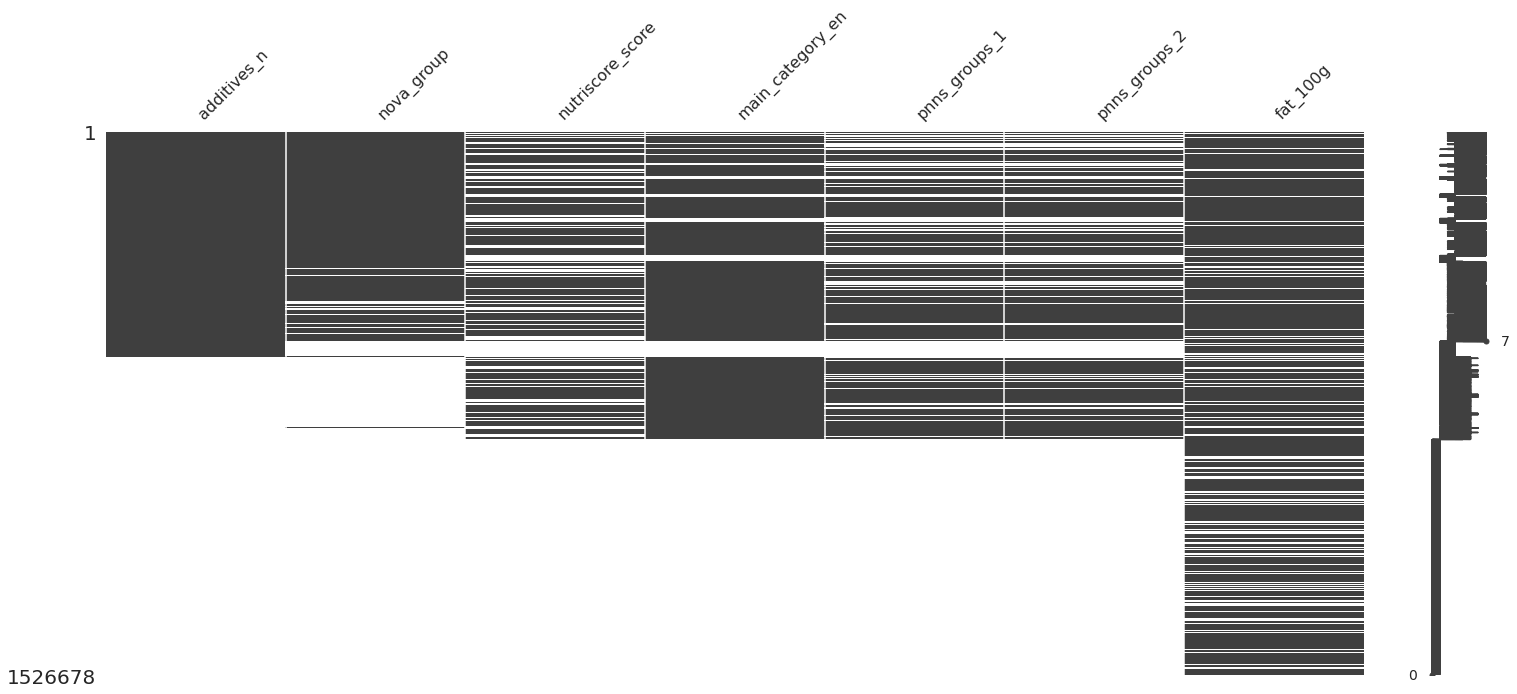

In [150]:
#plot_missing_matrix(data_df[~data_df['additives_n'].isna()])
plot_missing_matrix(data_df)
to_png('7.4_missing_matrix_apres_imputation')

## 7.5 Pipeline pour imputer ou traiter les valeurs manquantes

L'imputation des valeurs manquantes avec KNN Imputer est désactivée, 
en attendant améliorer la vitesse d'imputation et accuracy.

Le pipeline d'imputation sera :

- Imputer les valeurs nutritionnelles manquantes avec KNNImputer
- On n'impute pas la catégorie nutriscore grade, car il depend du nutriscore et PNNS groupe
- On n'impute pas les valeurs catégoriques manquantes, car l'analyse est pour explorer les relations avec ces categories
- On supprime les données pour lequel ont n'a pas des informations sur les ingrédients, car on n'a aucune information sur les additifs

Ce derniere suppression des données (sans information sur les additifs) est fait
dans le notebook d'exploration, car on analyse les contributions à la base avant.


drop_produits_sans_info_additif (nb = 892981 = 892983)
(1526678, 42)


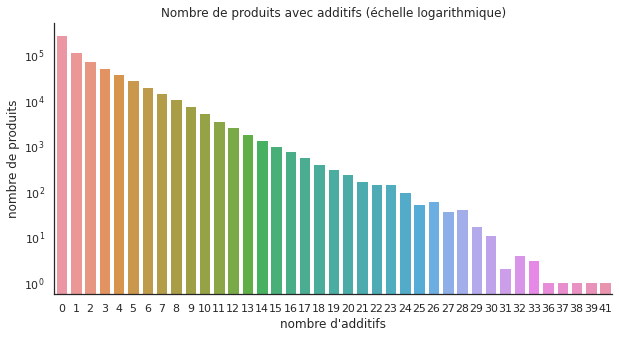

In [151]:
def drop_produits_sans_info_additif(df):
    nb_sans_ingredients = df['ingredients_text'].isna().sum()
    nb_sans_info= df['additives_n'].isna().sum()
    print(f'drop_produits_sans_info_additif (nb = {nb_sans_info} = {nb_sans_ingredients})')
    return df.dropna(subset=['additives_n'])

data_df.pipe(drop_produits_sans_info_additif)
print(data_df.shape)
def plot_additifs_log_scale(df):
    plt.figure(figsize=(10,5))
    additives_n=df['additives_n'].value_counts()
    g=sns.barplot(x=additives_n.index, y=additives_n.values)
    g.set_yscale("log")
    g.set_xlabel("nombre d'additifs")
    g.set_ylabel('nombre de produits')
    g.set_title('Nombre de produits avec additifs (échelle logarithmique)')
    sns.despine()
    to_png('7.3.1_produits_avec_additifs_logscale')

plot_additifs_log_scale(data_df)

In [152]:
def pipeline_imputer_valeurs_manquantes(df):
    print(f'pipeline_imputer_valeurs_manquantes, start_time={datetime.now().time():%H:%M:%S}')
    return (df
        .pipe(drop_produits_sans_info_additif)
        #.pipe(impute_valeurs_nutritionnelles_manquantes)
    )

data_df = data_df.pipe(pipeline_imputer_valeurs_manquantes)

pipeline_imputer_valeurs_manquantes, start_time=08:50:06
drop_produits_sans_info_additif (nb = 892981 = 892983)


# 8. Élimination des colonnes redondantes<a name="colonnes-redondantes"></a>
La plupart de colonnes non-pertinentes ont été supprimés imédiatement après import pour réduire l'usage de mémoire RAM
Il reste à supprimer
- Colonnes nutritionelles en double 


## 8.1 Drop colonnes_nutritionnelles en double

### 8.1.1 salt_100g (duplique les données de sodium_100g) 
- pas besoin de colonne salt_100g car il est un multiple de sodium_100g

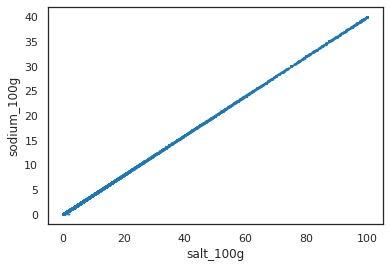

In [153]:
def plot_test_salt_sodium(df):
    if len(cols_in_df(data_df,['salt_100g','sodium_100g'])) == 2:
        sns.regplot(data=df,x='salt_100g',y='sodium_100g',scatter_kws={'s':1}, fit_reg=False)
        to_png('8.1.3.1_test_salt_sodium_regplot')
    
data_df.pipe(plot_test_salt_sodium);


### 8.1.2 energy-kcal_100g (duplique les données de energy_100g) 

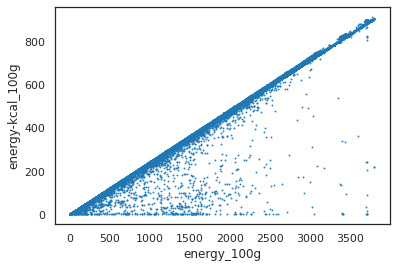

In [154]:
def plot_test_energy_kcal(df):
    if len(cols_in_df(data_df,['energy_100g','energy-kcal_100g'])) == 2:
        sns.regplot(data=df,x='energy_100g',y='energy-kcal_100g',scatter_kws={'s':1}, fit_reg=False)
        #sns.scatterplot(data=df,x='salt_100g',y='sodium_100g',size=1)
        to_png('8.1.3.2_test_energy_kcal_regplot')

data_df.pipe(plot_test_energy_kcal);


In [155]:
def drop_nutrition_cols_dupliques(df):
    cols=['salt_100g','energy-kcal_100g']
    for col in cols:
        if col in df.columns:
            print(f'drop_nutrition_cols_dupliques [{col}]')
            df=df.drop(col,axis=1)
    return df

data_df=data_df.pipe(drop_nutrition_cols_dupliques);

drop_nutrition_cols_dupliques [salt_100g]
drop_nutrition_cols_dupliques [energy-kcal_100g]


## 8.2 Elimination des colonnes en double, composées de listes de chaines, tags etc
- <https://world.openfoodfacts.org/data/data-fields.txt>
- **inférence** en regardant df_sample


In [156]:
def find_list_colonnes(df:pd.DataFrame)-> list:
    """Liste des colonnes du dataframe qui contient des listes """
    cols= df.select_dtypes('object').columns.tolist()
    ret=[]
    for col in cols:
        if col in ['product_name', 'abbreviated_product_name', 'generic_name']: continue 
        elif df[col].dropna().str.contains(',').any(): ret.append(col)
    return ret

tag_cols=find_list_colonnes(data_df)
print(tag_cols)

['quantity', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'labels_en', 'countries_en', 'ingredients_text', 'serving_size', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'states_en']


In [157]:
list_cols= ['packaging', 'brands', 'categories','labels','countries','states', 'emb', 'main_category']

def decrire_liste_cols(df,racine='states'):
   liste_cols=cols_in_df(df,[racine,f'{racine}_text',f'{racine}_tags',f'{racine}_en'])
   liste_df= df[liste_cols].dropna(how='all')
   print(liste_df.tail(1).T)
   return liste_df.describe()

data_df.pipe(decrire_liste_cols,'brands')

                2042077
brands       Tarczynski
brands_tags  tarczynski


brands brands_tags
count      509321      509304
unique     116533       94101
top     Carrefour   carrefour
freq         7033        7226


On voit que la colonne de base est en plusieurs langues,
qui explique pourquoi il y a plus de categories que de tags
(qui sont en general avec prefix en:)

- la colonne `categories_en` fournie la traduction anglaise des catégories

Pour éliminer les données en duple ou triple :
- garder la colonne qui termine avec `_en` s'il reste dans la base
- sinon, garder la colonne qui termine avec `_tags`
- sinon, garder la colonne de base

On fera ça avec toutes les colonnes des tags : ['packaging', 'brands', 'categories','labels','countries','additives','states']


In [158]:
def drop_tag_cols_dupliques(df, cols=['packaging', 'brands', 'categories','labels','countries','states', 'main_category']):
    df_cols= list(df.columns)
    cols_to_drop=[]
    for col in cols:
        dup_tag_cols=[]
        if f'{col}_en' in df_cols: dup_tag_cols.append(f'{col}_en')
        if f'{col}_tags' in df_cols: dup_tag_cols.append(f'{col}_tags')     
        if col in df_cols: dup_tag_cols.append(col)
        if len(dup_tag_cols)>1:
            print (f'keep [{dup_tag_cols[0]}], drop {dup_tag_cols[1:]}')
            cols_to_drop += dup_tag_cols[1:]
    if len(cols_to_drop)>0:
        return df.drop(cols_to_drop,axis=1)
    else: return df

data_df=data_df.pipe(drop_tag_cols_dupliques);

keep [brands_tags], drop ['brands']
keep [categories_en], drop ['categories_tags', 'categories']
keep [main_category_en], drop ['main_category']


## 8.3 Drop colonnes de quantity de servings

In [159]:
def drop_colonnes_servings(df):
    cols = cols_in_df(df,['quantity','serving_size','serving_quantity'])
    if len(cols) > 0:
        print(f'drop_colonnes_servings {cols}')
        return df.drop(cols,axis=1)
    else: return df

data_df=data_df.pipe(drop_colonnes_servings);

drop_colonnes_servings ['quantity', 'serving_size', 'serving_quantity']


## 8.4 Pipeline pour éliminer les colonnes redondantes

In [160]:
def pipeline_eliminer_colonnes_redondantes(df):
    print(f'pipeline_eliminer_colonnes_redondantes, start_time={datetime.now().time():%H:%M:%S}')
    return (df
            .pipe(drop_nutrition_cols_dupliques)
            .pipe(drop_tag_cols_dupliques)
            .pipe(drop_colonnes_servings)
            )

data_df=data_df.pipe(pipeline_eliminer_colonnes_redondantes)

pipeline_eliminer_colonnes_redondantes, start_time=08:50:22


# 9. Enregistrement du dataframe nettoyé<a name="enregistrement"></a>

In [161]:
colonnes_a_importer=data_df.columns.to_list()
data_df = None
del data_df

In [162]:
data_df = (read_raw_data(colonnes=colonnes_a_importer)
               .pipe(pipeline_corriger_types)
               .pipe(pipeline_eliminer_colonnes_inutiles)
               .pipe(pipeline_eliminer_lignes_dupliquees)
               .pipe(pipeline_traiter_valeurs_manquantes)
               .pipe(pipeline_traiter_valeurs_aberrantes)
               #.pipe(pipeline_imputer_valeurs_manquantes)
               .pipe(pipeline_eliminer_colonnes_redondantes)
               )


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,52,55) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pipeline_corriger_types, start_time=08:51:43
convertir to datetime [created_datetime]
convertir to datetime [last_modified_datetime]
convertir_to_int : [additives_n] (type=float64)
additives_n as int64 is of type Int64
additives_n as int is of type Int64
convertir_to_int : [ingredients_from_palm_oil_n] (type=float64)
ingredients_from_palm_oil_n as int64 is of type Int64
ingredients_from_palm_oil_n as int is of type Int64
convertir_to_int : [ingredients_that_may_be_from_palm_oil_n] (type=float64)
ingredients_that_may_be_from_palm_oil_n as int64 is of type Int64
ingredients_that_may_be_from_palm_oil_n as int is of type Int64
convertir_to_int : [nova_group] (type=float64)
nova_group as int64 is of type Int64
nova_group as int is of type Int64
peut convertir_to_category, colonne [nutriscore_grade]
peut convertir_to_category, colonne [nova_group]
peut convertir_to_category, colonne [pnns_groups_1]
peut convertir_to_category, colonne [pnns_groups_2]
remplace valeurs de categorie 'unknown' pa

In [163]:

print(data_df_shape)
print(data_df.shape)

print(list(data_df.columns))

(2042129, 187)
(1555277, 33)
['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'brands_tags', 'categories_en', 'labels_en', 'countries_en', 'ingredients_text', 'additives_n', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'states_en', 'main_category_en', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


## 9.1. Enregistre les données et un dictionnaire de données

In [165]:
clean_data_dict=data_df.pipe(decrire_dataframe, calc_max_len=True)
clean_data_dict.to_csv(os_path_join(OUT_FOLDER,CLEAN_DATA_DICT), encoding='UTF-8', sep='\t', index=False)
clean_data_dict

column    count   unique  \
0                                                    code  1555277  1555277   
1                                                 creator  1555274    13290   
2                                        created_datetime  1555277      NaN   
3                                  last_modified_datetime  1555277      NaN   
4                                            product_name  1546101  1279206   
5                                             brands_tags   925889   124634   
6                                           categories_en   772940    36448   
7                                               labels_en   369284    19412   
8                                            countries_en  1551530      558   
9                                        ingredients_text   642530  1601614   
10                                            additives_n   642532      NaN   
11                                         additives_tags   370688      567   
12                                           additives_en   370688      567   
13                            ingredients_from_palm_oil_n   642532      NaN   
14                         ingredients_from_palm_oil_tags    13708        6   
15                ingredients_that_may_be_from_palm_oil_n   642532      NaN   
16             ingredients_that_may_be_from_palm_oil_tags    39050       19   
17                                       nutriscore_score   603275      NaN   
18                                       nutriscore_grade   603275        5   
19                                             nova_group   558502        4   
20                                          pnns_groups_1   627841       11   
21                                          pnns_groups_2   627843       41   
22                                              states_en  1555277       42   
23                                       main_category_en   772940    31743   
24                                            energy_100g  1281051      NaN   
25                                               fat_100g  1274821      NaN   
26                                     saturated-fat_100g  1232934      NaN   
27                                     carbohydrates_100g  1274623      NaN   
28                                            sugars_100g  1255189      NaN   
29                                             fiber_100g   441284      NaN   
30                                          proteins_100g  1275996      NaN   
31                                            sodium_100g  1199111      NaN   
32  fruits-vegetables-nuts-estimate-from-ingredients_100g   641094      NaN   

             dtype max_length  
0           object         24  
1           object         28  
2   datetime64[ns]        NaN  
3   datetime64[ns]        NaN  
4           object        166  
5           object         67  
6           object        313  
7           object        275  
8           object        106  
9           object       2300  
10           Int64        NaN  
11          object        256  
12          object        831  
13           Int64        NaN  
14          object         41  
15           Int64        NaN  
16          object        159  
17         float64        NaN  
18        category        NaN  
19        category        NaN  
20        category        NaN  
21        category        NaN  
22          object        473  
23          object        223  
24         float64        NaN  
25         float64        NaN  
26         float64        NaN  
27         float64        NaN  
28         float64        NaN  
29         float64        NaN  
30         float64        NaN  
31         float64        NaN  
32         float64        NaN

In [166]:
data_df.to_csv(os_path_join(OUT_FOLDER,CLEAN_DATA_FILENAME), 
                encoding='UTF-8', sep='\t',index=False)


In [167]:
sample_size=min(100000,len(data_df))
data_df.sample(sample_size).to_csv(os_path_join(OUT_FOLDER,CLEAN_DATA_SAMPLE),
                              encoding='UTF-8', sep='\t',index=False)

## 9.2 Données nettoyés - Taux de remplissage
Il y a deux parties de l'analyse exploratoire: 
- analyse des contributeurs (est-ce qu'on peux intégrer les données d'additifs de tous les pays et contributeurs?)
- analyse des additifs (seulement avec données ou l'information des additifs est présent)

### 9.2.1 Données pour l'analyse des contributeurs - taux de remplissage 
La premier partie d'analyse exploratoire analyse les données manquantes : l'effet de pays et contributeur 

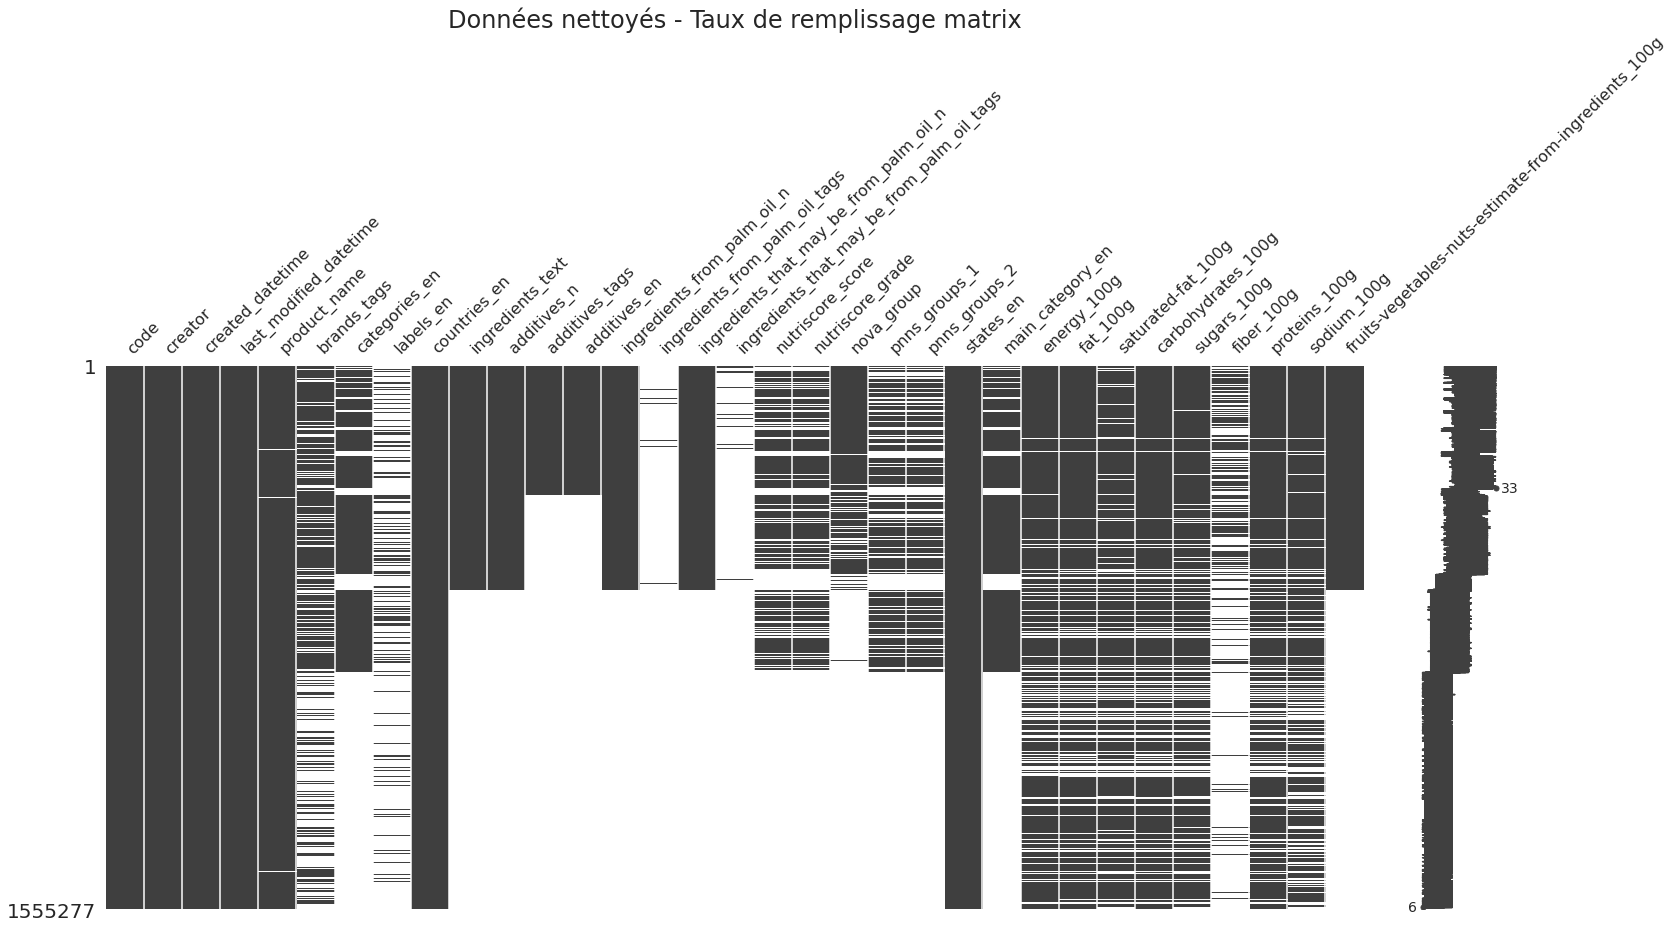

In [168]:
(data_df
 .pipe(sort_by_priority)
 .pipe(msno.matrix))
plt.title(label="Données nettoyés - Taux de remplissage matrix", size=24)
to_png('10_cleaned_data_taux_de_remplissage_matrix')

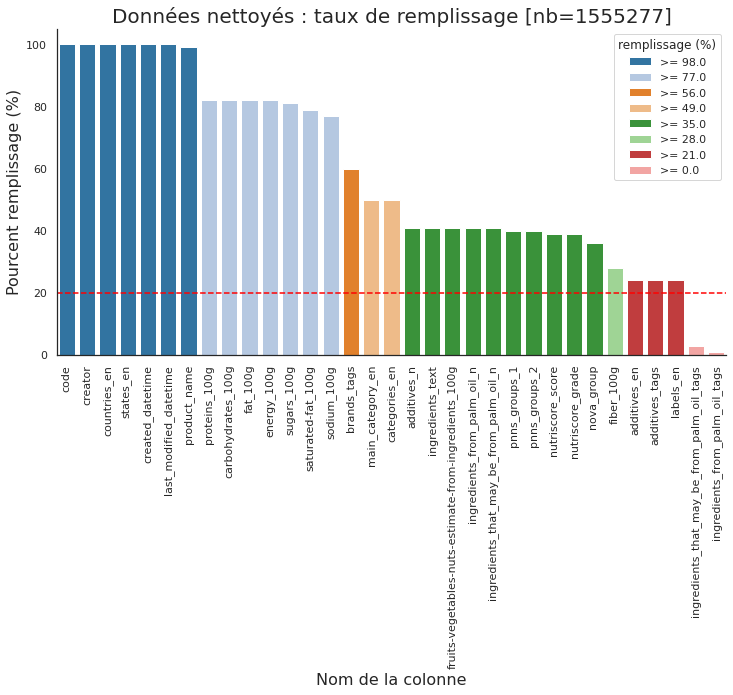

In [169]:
data_df.pipe(plot_colonne_remplissage,titre='Données nettoyés : taux de remplissage',
figsize=(12, 6))
to_png('10_cleaned_data_taux_de_remplissage_barplot')

### 9.2.1 Données pour l'analyse des additifs - taux de remplissage

Pour la reste de l'analyse exploratoire,  les produits sans information sur les additifs sont supprimés (après des tests statistiques)

Ci-dessous, le taux de remplissage des données sans information sur les additifs

drop_produits_sans_info_additif (nb = 912745 = 912747)


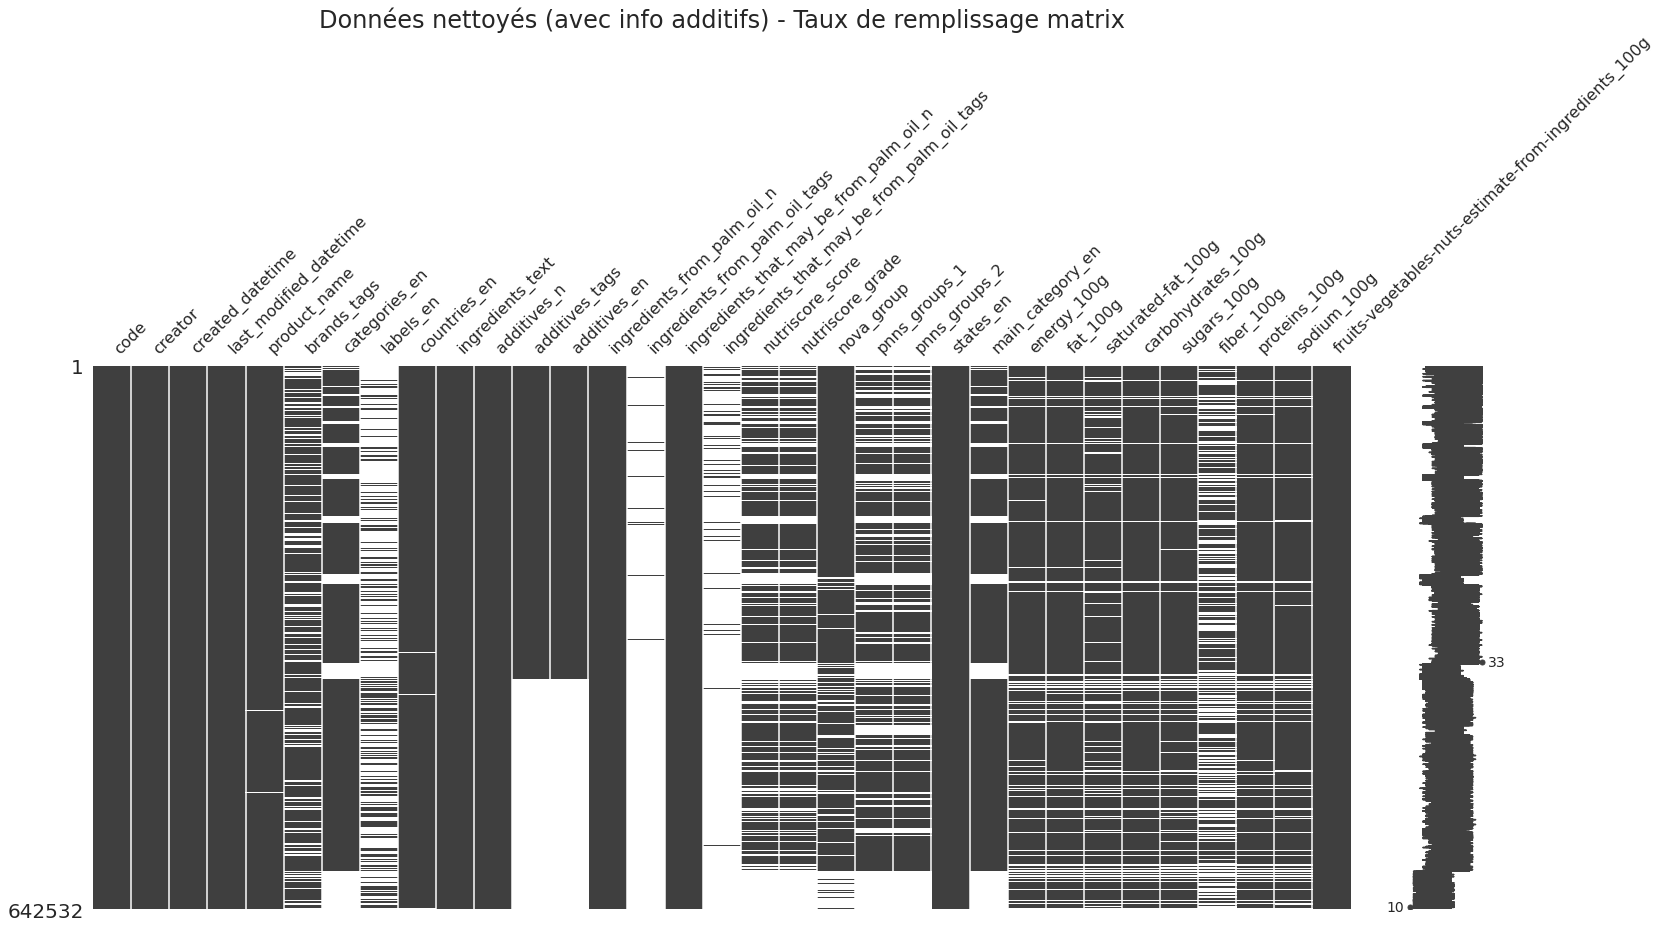

In [170]:
(data_df
 .pipe(drop_produits_sans_info_additif)
 .pipe(sort_by_priority)
 .pipe(msno.matrix))
plt.title(label="Données nettoyés (avec info additifs) - Taux de remplissage matrix", size=24)
to_png('10_cleaned_data_additifs_taux_de_remplissage_matrix')

drop_produits_sans_info_additif (nb = 912745 = 912747)


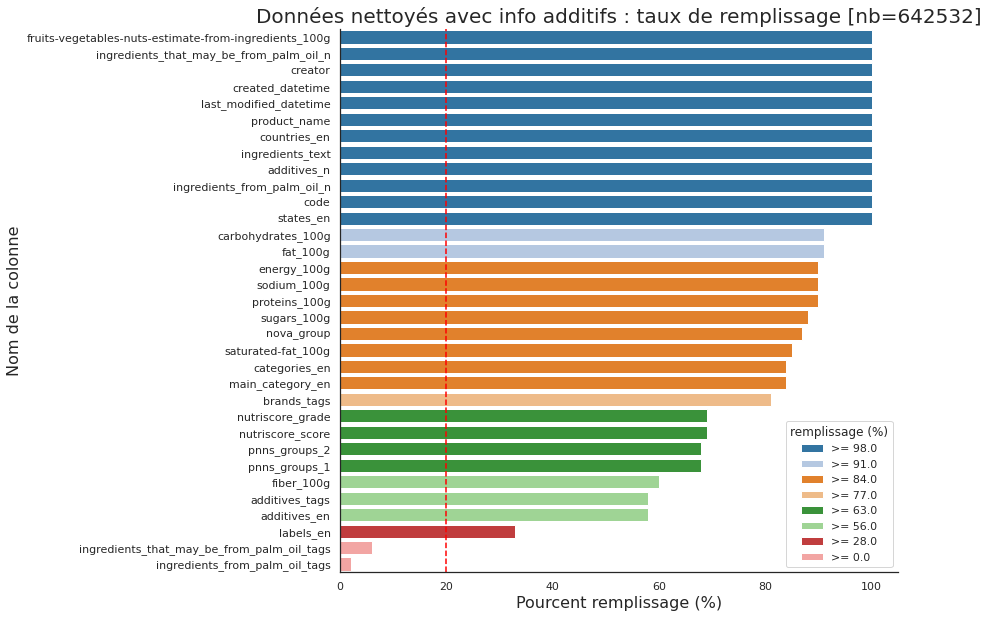

In [171]:
(data_df
   .pipe(drop_produits_sans_info_additif)
   .pipe(plot_bar_remplissage,
         titre='Données nettoyés avec info additifs : taux de remplissage',
         figsize=(10, 10))
)
to_png('10_cleaned_data_additifs_taux_de_remplissage_barplot')

# 10. Conversion des données supplémentaires des additives (du site Open Food Facts)
Nombre de produits qui contient des additives :
- https://world.openfoodfacts.org/additives
- https://world.openfoodfacts.org/additives.json

## 10.1 Télécharge le fichier json du site `openfoodfacts.org`

Les détails des propriétés des additives sont disponibles sur :
-  https://world.openfoodfacts.org/data/taxonomies/additives.json

In [172]:
import json

def load_json(file):
    with open(file, encoding='UTF-8') as f:
        return json.load(f)

def save_json(obj,file):
    with open(file, 'w', encoding='UTF-8') as outfile:
        json.dump(obj, outfile)

def load_json_file_or_url(file,url):
    if os.path.exists(file):
        try:
            return load_json(file)
        except IOError:
            print(f'error loading json file : {file}')
    f=requests.get(url).json()
    save_json(f,file)
    return f

def get_file_or_url(file,url):
    if os.path.exists(file):
            return file
    else:
        response=requests.get(url)
        with open(file, "w",encoding='UTF-8') as f:
            f.write(response.text)
        return file

off_additives_detail_json_url='https://world.openfoodfacts.org/data/taxonomies/additives.json'
local_additives_detail_json=os_path_join(OUT_FOLDER,'additives_detail.json')

additives_detail_json = load_json_file_or_url(local_additives_detail_json,off_additives_detail_json_url)
print(list(additives_detail_json.values())[0])

{'efsa_evaluation': {'en': 'Scientific Opinion on the re-evaluation of canthaxanthin -E 161 g- as a food additive'}, 'name': {'fr': 'E161e - Violaxanthine', 'lt': 'E161e - Violaksantinas', 'cs': 'E161e - E161e food additive', 'et': 'E161e - E161e food additive', 'nl': 'E161e - Violoxanthine', 'ca': 'E161e - Violaxantina', 'mt': 'E161e - E161e food additive', 'en': 'E161e - Violaxanthin', 'pt': 'E161e - E161e food additive', 'fi': 'E161e - Violaksantiini', 'sl': 'E161e - E161e food additive', 'sv': 'E161e - Violaxantin', 'da': 'E161e - E161e food additive', 'ro': 'E161e - Violoxantină', 'bg': 'E161e - E161e food additive', 'es': 'E161e - Violaxantina', 'de': 'E161e - E161e food additive', 'it': 'E161e - Violaxantina', 'el': 'E161e - E161e food additive', 'hu': 'E161e - Violaxantin', 'pl': 'E161e - Wiolaksantyna', 'lv': 'E161e - E161e food additive', 'sk': 'E161e - E161e food additive'}, 'efsa_evaluation_date': {'en': '2010-10-22'}, 'vegetarian': {'en': 'yes'}, 'efsa_evaluation_url': {'e

## 10.2 Convertir additives json vers dataframe

In [173]:
pd.DataFrame.from_dict(additives_detail_json, orient='index').head(1)

efsa_evaluation  \
en:e161e  {'en': 'Scientific Opinion on the re-evaluation of canthaxanthin -E 161 g- as a food additive'}   

                                                                                                         name  \
en:e161e  {'fr': 'E161e - Violaxanthine', 'lt': 'E161e - Violaksantinas', 'cs': 'E161e - E161e food additi...   

          efsa_evaluation_date     vegetarian  \
en:e161e  {'en': '2010-10-22'}  {'en': 'yes'}   

                                           efsa_evaluation_url  \
en:e161e  {'en': 'http://dx.doi.org/10.2903/j.efsa.2010.1852'}   

                e_number          vegan wikidata efsa additives_classes  \
en:e161e  {'en': '161e'}  {'en': 'yes'}      NaN  NaN               NaN   

         parents efsa_evaluation_overexposure_risk efsa_evaluation_adi  \
en:e161e     NaN                               NaN                 NaN   

         from_palm_oil efsa_evaluation_exposure_95th_greater_than_adi  \
en:e161e           NaN                                            NaN   

         efsa_evaluation_exposure_mean_greater_than_adi children colour_index  \
en:e161e                                            NaN      NaN          NaN   

         description efsa_evaluation_adi_established  \
en:e161e         NaN                             NaN   

         efsa_evaluation_safety_assessed organic_eu mandatory_additive_class  \
en:e161e                             NaN        NaN                      NaN   

         comment default_additive_class ciqual_food_name ciqual_food_code  \
en:e161e     NaN                    NaN              NaN              NaN   

         carbon_footprint_fr_foodges_ingredient  \
en:e161e                                    NaN   

         carbon_footprint_fr_foodges_value  \
en:e161e                               NaN   

         efsa_evaluation_exposure_95th_greater_than_noael  \
en:e161e                                              NaN   

         efsa_evaluation_exposure_mean_greater_than_noael  
en:e161e                                              NaN

In [174]:
def normalize_additive_json(data):
    """Extraire les champs en anglais du fichier additives.json"""
    data, index = list(data.values()), list(data.keys())
    df = pd.json_normalize(data)
    df.index = index
    df = df.rename_axis('id')
    filtre = df.columns.str.endswith('.en')  #seulement les colonnes en anglais
    df = df[df.columns[filtre]]
    # supprime '.en'
    df.columns = [str(col)[:-3] for col in df.columns]
    return df.reset_index()


additives_detail_df = normalize_additive_json(additives_detail_json)
print(additives_detail_df.shape)
additives_detail_df.head(1)


(655, 28)


id  \
0  en:e161e   

                                                                         efsa_evaluation  \
0  Scientific Opinion on the re-evaluation of canthaxanthin -E 161 g- as a food additive   

                   name efsa_evaluation_date vegetarian  \
0  E161e - Violaxanthin           2010-10-22        yes   

                          efsa_evaluation_url e_number vegan wikidata efsa  \
0  http://dx.doi.org/10.2903/j.efsa.2010.1852     161e   yes      NaN  NaN   

  additives_classes efsa_evaluation_overexposure_risk efsa_evaluation_adi  \
0               NaN                               NaN                 NaN   

  from_palm_oil efsa_evaluation_exposure_95th_greater_than_adi  \
0           NaN                                            NaN   

  efsa_evaluation_exposure_mean_greater_than_adi colour_index description  \
0                                            NaN          NaN         NaN   

  efsa_evaluation_adi_established efsa_evaluation_safety_assessed organic_eu  \
0                             NaN                             NaN        NaN   

  mandatory_additive_class comment default_additive_class ciqual_food_name  \
0                      NaN     NaN                    NaN              NaN   

  ciqual_food_code efsa_evaluation_exposure_95th_greater_than_noael  \
0              NaN                                              NaN   

  efsa_evaluation_exposure_mean_greater_than_noael  
0                                              NaN

## 10.3 Enregistre le fichier 'additive_details.csv' pour l'analyse exploratoire

In [175]:
additives_detail_df.to_csv(os_path_join(OUT_FOLDER, ADDITIVES_DETAIL),
                           encoding='UTF-8',sep='\t',index=False)
